### **Outputs de la entrega final**

A continuación tenemos el código con el cual obtuvimos los resultados para la entrega final. 

*El presente código contiene solo lo imprescindible para obtener las Figuras y Tablas de la entrega final, por lo que no refleja todo el trabajo desarrollado en Python ni tampoco contiene las herramientas a entregar a la CMF.



# Preguntas iniciales


In [ ]:
print('¿Descargamos las figuras en .png? (Y/N)')
d_descargas_figuras= input()

¿Descargamos las figuras en .png? (Y/N)
N


In [ ]:
print('¿Descargamos las tablas en .xlsx? (Y/N)')
d_descargas_tablas= input()

¿Descargamos las tablas en .xlsx? (Y/N)
N


In [ ]:
print('¿Calculamos excentricidad y diámetro? El código se demora mucho más (Y/N)')
d_excentricidad = input()

¿Calculamos excentricidad y diámetro? El código se demora mucho más (Y/N)
N


# I. Carga de bases de datos y librerías 

Importamos las librerías a utilizar en el código, y archivos .csv con datos mensuales desde diciembre de 2018 a agosto de 2022 con: (i) los patrimonios efectivos de los bancos establecidos en Chile y (ii) sus exposiciones bilaterales por créditos interbancarios.

In [ ]:
import io
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.pylab as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
from matplotlib.patches import ConnectionStyle #paquete para estilo de conexión 
from matplotlib.patches import ArrowStyle #paquete para estilo de las flechas
import networkx as nx
import seaborn as sns
from datetime import datetime
import random

In [ ]:
#para traer letra estilo LaTeX
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams["figure.figsize"] = [16, 8]
import matplotlib.pyplot as plt

In [ ]:
#Cargamos el dataset de capitales (GitHub)
url_cap = "https://raw.githubusercontent.com/nmoenne/Proyecto-Profesional-CMF/main/datos_PatrimonioEfectivo_201812-202208_in_v2.csv"
df_cap = pd.read_csv(url_cap, sep=";")

#cambiamos el tipo de datos de algunas columnas
df_cap['fecham'] = pd.to_datetime(df_cap['fecham'], dayfirst = True) #2018-12-01 es 1 de dic de 2018
df_cap["PatEf"] = pd.to_numeric(df_cap["PatEf"])

#preparamos el df para que esté ordenado por (periodo, código, banco) 
df_cap.sort_values(by=['periodo', 'cod_01'], inplace = True) 
df_cap.reset_index(drop = True, inplace = True)
try:
  df_cap.drop(columns = 'Columna1', inplace = True)
except:
  pass

#pasamos los valores a millones de CLP
df_cap['PatEf'] = df_cap['PatEf']/1000000

df_cap

Unnamed: 0  periodo     fecham  cod_01         PatEf
0            17   201812 2018-12-01       3  2.795780e+06
1            10   201812 2018-12-01       4  2.340229e+04
2             3   201812 2018-12-01       5  2.077480e+05
3            15   201812 2018-12-01       6  5.883710e+05
4             7   201812 2018-12-01       8  2.673650e+06
..          ...      ...        ...     ...           ...
799         801   202208 2022-08-01      19  4.008610e+06
800         788   202208 2022-08-01      20  5.331200e+05
801         795   202208 2022-08-01      21  2.369600e+05
802         790   202208 2022-08-01      23  1.022550e+05
803         797   202208 2022-08-01      24  6.318180e+06

[804 rows x 5 columns]

In [ ]:
d_caps = {} #creamos diccionario que se va a llenar con df de patrimonio efectivo para cada período
d_pat_ef_t = {}
for periodo in df_cap.periodo.unique():
  df_aux = df_cap[df_cap['periodo'] == periodo]['PatEf'].to_frame()
  df_aux.set_index(df_cap[df_cap['periodo'] == periodo]['cod_01'].unique(), inplace = True)

  df_aux_f1 = df_aux.transpose()
  df_aux_f1 = df_aux_f1.add_prefix('banco_')
  df_aux_f1 = df_aux_f1.reset_index()
  df_aux_f1 = df_aux_f1.drop(columns = 'index')

 # df_aux.rename('banco_{}'.format, inplace = True)
  d_caps[f"d_cap_{periodo}"] = df_aux
  d_pat_ef_t[f"df_pat_ef_{periodo}"] = df_aux_f1

In [ ]:
#Cargamos la matriz de exposiciones como pandas df y lo pasamos a matriz numpy (a mano)
#Caso créditos interbancarios
url_exp = "https://raw.githubusercontent.com/nmoenne/Proyecto-Profesional-CMF/main/datos_contables_interbank_201812-202208_in.csv"
df_exp_cred = pd.read_csv(url_exp, sep=";")

#preparamos el df para que esté ordenado por (periodo, código, banco) 
df_exp_cred.sort_values(by=['periodo', 'cod_01'], inplace = True) 
df_exp_cred.reset_index(drop = True, inplace = True)
df_exp_cred.drop(columns = 'Columna1', inplace = True)

#pasamos exposiciones a MM CLP
df_exp_cred['tot_deuda'] = df_exp_cred['tot_deuda']/1000000
#df_exp_cred

In [ ]:
d_exp_cred_t = {} #creamos diccionario que se va a llenar con dfs de exposiciones por créditos interbancarios en el tiempo
for periodo in df_cap.periodo.unique():
  df_exp_aux = pd.DataFrame(0, index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique(), columns = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique()).astype(float) #creamos un df temporal con las exposiciones de cada mes en particular, a llenar. El astype(float) es para hacer que el df no convierta a 0 los valores entre 0 y 1
  if periodo in df_exp_cred.periodo.unique():
    df_aux = df_exp_cred[df_exp_cred['periodo'] == periodo] #creamos un df temporal con datos de cada mes en particular (producto de la iteración)
    for prestamista, deudor in zip(df_aux['cod_01'], df_aux['cod_02']): #llenado del df temporal anterior con las exposiciones distintas a 0
      if deudor in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique() and prestamista in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique():
        df_exp_aux.at[prestamista,deudor] = df_aux[df_aux['cod_01'] == prestamista][df_aux['cod_02'] == deudor]['tot_deuda']
  d_exp_cred_t[f"d_mat_cred_{periodo}"] = df_exp_aux #llenado del diccionario de dfs con el df con las exposiciones de cada mes

<ipython-input-9-20fc3fd370e3>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_exp_aux.at[prestamista,deudor] = df_aux[df_aux['cod_01'] == prestamista][df_aux['cod_02'] == deudor]['tot_deuda']


In [ ]:
d_exp_cred_relativa_t = {} #creamos diccionario que se va a llenar con dfs de exposiciones por créditos interbancarios en el tiempo (como % sobre el total)
for periodo in df_cap.periodo.unique():
  df_exp_aux = pd.DataFrame(0, index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique(), columns = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique()).astype(float) #creamos un df temporal con las exposiciones de cada mes en particular, a llenar. El astype(float) es para hacer que el df no convierta a 0 los valores entre 0 y 1
  if periodo in df_exp_cred.periodo.unique():
    df_aux = df_exp_cred[df_exp_cred['periodo'] == periodo] #creamos un df temporal con datos de cada mes en particular (producto de la iteración)
    for prestamista, deudor in zip(df_aux['cod_01'], df_aux['cod_02']): #llenado del df temporal anterior con las exposiciones distintas a 0
      if deudor in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique() and prestamista in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique():
        df_exp_aux.at[prestamista,deudor] = df_aux[df_aux['cod_01'] == prestamista][df_aux['cod_02'] == deudor]['tot_deuda']/d_exp_cred_t[f"d_mat_cred_{periodo}"].to_numpy().sum()
  df_exp_aux = df_exp_aux.add_prefix('banco_')
  d_exp_cred_relativa_t[f"df_mat_cred_relativa_{periodo}"] = df_exp_aux #llenado del diccionario de dfs con el df con las exposiciones de cada mes

<ipython-input-10-63b78557c971>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_exp_aux.at[prestamista,deudor] = df_aux[df_aux['cod_01'] == prestamista][df_aux['cod_02'] == deudor]['tot_deuda']/d_exp_cred_t[f"d_mat_cred_{periodo}"].to_numpy().sum()


In [ ]:
#Cargamos la matriz de exposiciones como pandas df y lo pasamos a matriz numpy (a mano)
#Caso créditos interbancarios
url_exp = "https://raw.githubusercontent.com/nmoenne/Proyecto-Profesional-CMF/main/datos_instrum_interbank_201812-202208_in.csv"
df_exp_inst = pd.read_csv(url_exp, sep=";")

#preparamos el df para que esté ordenado por (periodo, código, banco) 
df_exp_inst.sort_values(by=['periodo', 'cod_01'], inplace = True) 
df_exp_inst.reset_index(drop = True, inplace = True)
df_exp_inst.drop(columns = 'Unnamed: 0', inplace = True)

#pasamos exposiciones a MM CLP
df_exp_inst['valor'] = df_exp_inst['valor']/1000000
#df_exp_inst

In [ ]:
d_exp_inst_t = {} #creamos diccionario que se va a llenar con dfs de exposiciones por créditos interbancarios en el tiempo
for periodo in df_cap.periodo.unique():
  df_exp_aux = pd.DataFrame(0, index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique(), columns = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique()).astype(float) #creamos un df temporal con las exposiciones de cada mes en particular, a llenar. El astype(float) es para hacer que el df no convierta a 0 los valores entre 0 y 1
  if periodo in df_exp_inst.periodo.unique():
    df_aux = df_exp_inst[df_exp_inst['periodo'] == periodo] #creamos un df temporal con datos de cada mes en particular (producto de la iteración)
    for prestamista, deudor in zip(df_aux['cod_01'], df_aux['cod_02']): #llenado del df temporal anterior con las exposiciones distintas a 0
      if deudor in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique() and prestamista in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique():
        df_exp_aux.at[prestamista,deudor] = df_aux[df_aux['cod_01'] == prestamista][df_aux['cod_02'] == deudor]['valor'].values[0]
  d_exp_inst_t[f"d_mat_inst_{periodo}"] = df_exp_aux #llenado del diccionario de dfs con el df con las exposiciones de cada mes

<ipython-input-12-1d64f99c3334>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_exp_aux.at[prestamista,deudor] = df_aux[df_aux['cod_01'] == prestamista][df_aux['cod_02'] == deudor]['valor'].values[0]


In [ ]:
d_exp_inst_relativa_t  = {} #creamos diccionario que se va a llenar con dfs de exposiciones por créditos interbancarios en el tiempo (como % sobre el total)
for periodo in df_cap.periodo.unique():
  df_exp_aux = pd.DataFrame(0, index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique(), columns = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique()).astype(float) #creamos un df temporal con las exposiciones de cada mes en particular, a llenar. El astype(float) es para hacer que el df no convierta a 0 los valores entre 0 y 1
  if periodo in df_exp_inst.periodo.unique():
    df_aux = df_exp_inst[df_exp_inst['periodo'] == periodo] #creamos un df temporal con datos de cada mes en particular (producto de la iteración)
    for prestamista, deudor in zip(df_aux['cod_01'], df_aux['cod_02']): #llenado del df temporal anterior con las exposiciones distintas a 0
      if deudor in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique() and prestamista in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique():
        df_exp_aux.at[prestamista,deudor] = df_aux[df_aux['cod_01'] == prestamista][df_aux['cod_02'] == deudor]['valor'].values[0]/d_exp_inst_t[f"d_mat_inst_{periodo}"].to_numpy().sum()
  df_exp_aux = df_exp_aux.add_prefix('banco_')
  d_exp_inst_relativa_t [f"df_mat_inst_relativa_{periodo}"] = df_exp_aux #llenado del diccionario de dfs con el df con las exposiciones de cada mes

<ipython-input-13-381dcd1bcec6>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_exp_aux.at[prestamista,deudor] = df_aux[df_aux['cod_01'] == prestamista][df_aux['cod_02'] == deudor]['valor'].values[0]/d_exp_inst_t[f"d_mat_inst_{periodo}"].to_numpy().sum()


In [ ]:
d_exp_inst_relativa_t  = {} #creamos diccionario que se va a llenar con dfs de exposiciones por créditos interbancarios en el tiempo (como % sobre el total)
for periodo in df_cap.periodo.unique():
  df_exp_aux = pd.DataFrame(0, index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique(), columns = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique()).astype(float) #creamos un df temporal con las exposiciones de cada mes en particular, a llenar. El astype(float) es para hacer que el df no convierta a 0 los valores entre 0 y 1
  if periodo in df_exp_inst.periodo.unique():
    df_aux = df_exp_inst[df_exp_inst['periodo'] == periodo] #creamos un df temporal con datos de cada mes en particular (producto de la iteración)
    for prestamista, deudor in zip(df_aux['cod_01'], df_aux['cod_02']): #llenado del df temporal anterior con las exposiciones distintas a 0
      if deudor in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique() and prestamista in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique():
        df_exp_aux.at[prestamista,deudor] = df_aux[df_aux['cod_01'] == prestamista][df_aux['cod_02'] == deudor]['valor'].values[0]/d_exp_inst_t[f"d_mat_inst_{periodo}"].to_numpy().sum()
  df_exp_aux = df_exp_aux.add_prefix('banco_')
  d_exp_inst_relativa_t [f"df_mat_inst_relativa_{periodo}"] = df_exp_aux #llenado del diccionario de dfs con el df con las exposiciones de cada mes

<ipython-input-14-381dcd1bcec6>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_exp_aux.at[prestamista,deudor] = df_aux[df_aux['cod_01'] == prestamista][df_aux['cod_02'] == deudor]['valor'].values[0]/d_exp_inst_t[f"d_mat_inst_{periodo}"].to_numpy().sum()


In [ ]:
d_exp_cred_inst_relativa_t = {}
for periodo in df_cap['periodo'].unique():
  df_exp_cred_inst_aux = pd.DataFrame(0, index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique(), columns = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique()).astype(float)
  for prestamista in d_exp_cred_t[f"d_mat_cred_{periodo}"].index:
    for deudor in d_exp_cred_t[f"d_mat_cred_{periodo}"].index:
      df_exp_cred_inst_aux.at[prestamista, deudor] = d_exp_cred_t[f"d_mat_cred_{periodo}"].at[prestamista, deudor] + d_exp_inst_t[f"d_mat_inst_{periodo}"].at[prestamista, deudor]
  df_exp_cred_inst_relativa_aux = df_exp_cred_inst_aux/df_exp_cred_inst_aux.to_numpy().sum()
  df_exp_cred_inst_relativa_aux = df_exp_cred_inst_relativa_aux.add_prefix('banco_')
  d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo}"] = df_exp_cred_inst_relativa_aux

# Construcción de indicadores en el tiempo

In [ ]:
d_metricas_f1 = {} #diccionario que va a guardar los indicadores por período

#creamos df que guarda número de bancos participantes y no participantes
df_part_bancos = pd.DataFrame(np.zeros((len(df_cap['periodo'].unique()), 2)), columns = ['bancos_participantes (nodos)', 'bancos_no_participantes'], index = df_cap['periodo'].unique())


#iteramos sobre los períodos, generamos grafos y obtenemos métricas
for periodo in df_cap['periodo'].unique(): #iteramos sobre todos los periodos de la matriz de exposiciones de crédito
  print(periodo)
  bancos = d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo}"].columns
  G = nx.DiGraph() #Se crea espacio para hacer un dígrafo
  G.clear()


  data1 = []
  for index, banco_1 in zip(d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo}"].index, bancos): #recorremos todas las filas
    for banco_2 in bancos: #para cada fila, recorremos todas las columnas
      if d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo}"]._get_value(index, banco_2) != 0 and banco_1 != banco_2: #si banco_2 le debe a banco_1
        data1_tup = (banco_1, banco_2)
        data1_tup = list(data1_tup)
        data1_tup.append(d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo}"]._get_value(index, banco_2))
        data1_tup = tuple(data1_tup)
        data1.append(data1_tup)


  G.add_weighted_edges_from(data1) #agregamos a la edgelist de bancos
 
  bancos_participantes = [] #llenamos una lista con nodos (bancos participantes)
  for i in list(G.nodes()):
    bancos_participantes.append(f"{i}".strip())

  df_part_bancos.at[periodo, 'bancos_participantes (nodos)'] = len(bancos_participantes) #número de bancos participantes en el período
  df_part_bancos.at[periodo, 'bancos_no_participantes'] = len(df_cap[df_cap['periodo'] == periodo]['cod_01'].unique()) - len(bancos_participantes) #número de bancos no participantes en el período



  #creamos df con los indicadores de interés para cada nodo



  ####extracción tipo 1: hacer listas desde los códigos que devuelven indicadores y luego dfs#################################################################################

  lista_grado_entrante = []
  for i,j in G.in_degree:
    lista_grado_entrante.append(j)

  lista_grado_saliente = []
  for i,j in G.out_degree:
    lista_grado_saliente.append(j)

  lista_fuerza_entrante = []
  for i,j in G.in_degree(weight = "weight"):
    lista_fuerza_entrante.append(j)

  lista_fuerza_saliente = []
  for i,j in G.out_degree(weight = "weight"):
    lista_fuerza_saliente.append(j)


  d_grado_entrante = {'grado_entrante' : lista_grado_entrante}
  df_grado_entrante = pd.DataFrame(d_grado_entrante, index = bancos_participantes)

  d_grado_saliente = {'grado_saliente' : lista_grado_saliente}
  df_grado_saliente = pd.DataFrame(d_grado_saliente, index = bancos_participantes)

  d_fuerza_entrante = {'fuerza_entrante' : lista_fuerza_entrante}
  df_fuerza_entrante = pd.DataFrame(d_fuerza_entrante, index = bancos_participantes)

  d_fuerza_saliente = {'fuerza_saliente' : lista_fuerza_saliente}
  df_fuerza_saliente = pd.DataFrame(d_fuerza_saliente, index = bancos_participantes)



  ####extracción tipo 2: hacer df directo desde los códigos que devuelven indicadores#################################################################################

  df_betweenness= pd.DataFrame(nx.betweenness_centrality(G).items(), index = bancos_participantes, columns = ['bancos', 'betweenness'])
  df_betweenness.drop(columns = 'bancos', inplace = True)

  df_closeness_entrante = pd.DataFrame(nx.closeness_centrality(G).items(), index = bancos_participantes, columns = ['bancos', 'closeness_entrante'])
  df_closeness_entrante.drop(columns = 'bancos', inplace = True)

  df_closeness_saliente = pd.DataFrame(nx.closeness_centrality(G.reverse()).items(), index = bancos_participantes, columns = ['bancos', 'closeness_saliente'])
  df_closeness_saliente.drop(columns = 'bancos', inplace = True)


  try:
    df_vector_propio_entrante_w = pd.DataFrame(nx.eigenvector_centrality(G, max_iter= 10000, weight='weight').items(), index = bancos_participantes, columns = ['bancos', 'vector_propio_entrante_w'])
    df_vector_propio_entrante_w.drop(columns = 'bancos', inplace = True)
  except: #reporte en caso de que la obtención del indicador lleve a un error
    df_vector_propio_entrante_w['vector_propio_entrante_w'] = np.nan
    print(f"Problema calculando vector_propio_entrante_w en el período {periodo}: función no converge en 10000 iteraciones")


  try:
    G0=G.reverse(copy="True")
    vector_propio_saliente_w = nx.eigenvector_centrality(G0, weight="weight", max_iter= 10000) #sacamos eigenvector para G1 (out)
    df_vector_propio_saliente_w = pd.DataFrame(vector_propio_saliente_w.items(), index = bancos_participantes, columns = ['bancos', 'vector_propio_saliente_w'])
    df_vector_propio_saliente_w.drop(columns = 'bancos', inplace = True)
  except: #reporte en caso de que la obtención del indicador lleve a un error
    df_vector_propio_saliente_w['vector_propio_saliente_w'] = np.nan
    print(f"Problema calculando vector_propio_saliente_w en el período {periodo}: función no converge en 10000 iteraciones")




  ####extracción tipo 3: para computar los HHI index 

  df_aux = d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo}"]**2
  IHH = df_aux.to_numpy().sum()

  ####contrucción de índices extra#####################################################################################################################


  if d_excentricidad == 'Y':
    #excentricidad_saliente
    excentricidad_saliente = []
    for banco_from in bancos_participantes: #recorremos todos los bancos
      lista_aux = [] #lista que va a guardar el camino más largo posible para cada nodo posible de llegada de banco_from
      for banco_to in bancos_participantes: #para cada banco, recorremos todos los bancos
        if banco_from != banco_to: #si banco_to es distinto a banco_from
          largo = 0 #buscamos el camino más largo de banco_from a banco_to
          for caminos in list(nx.all_simple_paths(G, source = f'{banco_from}', target = f'{banco_to}')):
            if len(caminos) > largo:
              largo = len(caminos) - 1
          lista_aux.append(largo) #guardamos cada largo máximo para cada nodo posible de llegada de banco_from
      df_help = pd.DataFrame(lista_aux, columns = ['column_name'])
      largo_mayor_nodo = df_help.max()[0]
      excentricidad_saliente.append(largo_mayor_nodo)


  ###############################################################################################################################################################


  #hacemos merge de dfs

  df_metricas_cred_inst = pd.DataFrame()
  df_metricas_cred_inst = df_grado_entrante.merge(df_grado_saliente, how = 'inner', left_index = True, right_index = True)
  df_metricas_cred_inst = df_fuerza_entrante.merge(df_metricas_cred_inst, how = 'inner', left_index = True, right_index = True)
  df_metricas_cred_inst = df_fuerza_saliente.merge(df_metricas_cred_inst, how = 'inner', left_index = True, right_index = True)
  df_metricas_cred_inst = df_betweenness.merge(df_metricas_cred_inst, how = 'inner', left_index = True, right_index = True)
  df_metricas_cred_inst = df_closeness_entrante.merge(df_metricas_cred_inst, how = 'inner', left_index = True, right_index = True)
  df_metricas_cred_inst = df_closeness_saliente.merge(df_metricas_cred_inst, how = 'inner', left_index = True, right_index = True)
  df_metricas_cred_inst = df_vector_propio_entrante_w.merge(df_metricas_cred_inst, how = 'inner', left_index = True, right_index = True)
  df_metricas_cred_inst = df_vector_propio_saliente_w.merge(df_metricas_cred_inst, how = 'inner', left_index = True, right_index = True)
  df_metricas_cred_inst = df_metricas_cred_inst
  df_metricas_cred_inst['n_nodos'] = G.number_of_nodes()
  df_metricas_cred_inst['n_aristas'] = G.number_of_edges()
  df_metricas_cred_inst['densidad'] = nx.density(G)
  df_metricas_cred_inst['IHH'] = IHH

  df_aux_IHH_entrante = pd.DataFrame(d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo}"].sum(axis=0), index = d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo}"].columns, columns = ['suma_vertical'])
  df_IHH_entrante = pd.DataFrame(columns = ['IHH_entrante'], index = bancos_participantes)
  for banco in d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo}"].columns:
    IHH_entrante = 0
    for indice in d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo}"].index:
      if df_aux_IHH_entrante.at[f'{banco}', 'suma_vertical'] != 0:
        IHH_entrante = IHH_entrante + (d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo}"].at[indice, f'{banco}']/df_aux_IHH_entrante.at[f'{banco}', 'suma_vertical'])**2
    if banco in bancos_participantes:
      df_IHH_entrante.at[banco, 'IHH_entrante'] = IHH_entrante

  df_aux_IHH_saliente = pd.DataFrame(list(d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo}"].sum(axis=1)), index = d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo}"].index, columns = ['suma_horizontal'])
  df_IHH_saliente = pd.DataFrame(columns = ['IHH_saliente'], index = bancos_participantes)
  for indice_banco, banco in zip(d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo}"].index, d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo}"].columns):
    IHH_saliente = 0
    for columna in d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo}"].columns:
      if df_aux_IHH_saliente.at[indice_banco, 'suma_horizontal'] != 0:
          IHH_saliente = IHH_saliente + (d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo}"].at[indice_banco, f'{columna}']/df_aux_IHH_saliente.at[indice_banco, 'suma_horizontal'])**2
      if banco in bancos_participantes:
        df_IHH_saliente.at[banco, 'IHH_saliente'] = IHH_saliente


  df_metricas_cred_inst = df_IHH_entrante.merge(df_metricas_cred_inst, how = 'inner', left_index = True, right_index = True)
  df_metricas_cred_inst = df_IHH_saliente.merge(df_metricas_cred_inst, how = 'inner', left_index = True, right_index = True)
  df_metricas_cred_inst['afinidad_saliente'] = 0
  df_metricas_cred_inst['afinidad_saliente'] = df_metricas_cred_inst['afinidad_saliente'].astype(float)
  for index in df_metricas_cred_inst.index:
    if df_metricas_cred_inst.at[index, 'grado_saliente'] == 0:
      df_metricas_cred_inst.at[index, 'afinidad_saliente'] = 0
    if df_metricas_cred_inst.at[index, 'grado_saliente'] != 0:
      df_metricas_cred_inst.at[index, 'afinidad_saliente'] = nx.average_neighbor_degree(G, source = 'out', target = 'out')[f'{index}']/df_metricas_cred_inst.at[index, 'grado_saliente']

  df_metricas_cred_inst['afinidad_entrante'] = 0
  df_metricas_cred_inst['afinidad_entrante'] = df_metricas_cred_inst['afinidad_entrante'].astype(float)

  avg = {} #afinidad in necesita hacerse "a mano ya que el código por defecto no funciona correctamente"
  for banco in df_metricas_cred_inst.index:
    G_P = G_S = {n: {} for n in G}
    if dict(G.in_degree)[f'{banco}'] == 0:
      avg[banco] = 0
    else:
      if G.is_directed():
        G_P = G.pred
        avg[banco] = (sum(dict(G.in_degree)[nbr] for nbr in G_P[f'{banco}']) + sum(dict(G.in_degree)[nbr] for nbr in G_S[f'{banco}'])) / dict(G.in_degree)[f'{banco}'] 


  for index in df_metricas_cred_inst.index:
    if df_metricas_cred_inst.at[index, 'grado_entrante'] != 0:
      df_metricas_cred_inst.at[index, 'afinidad_entrante'] = avg[f'{index}']/df_metricas_cred_inst.at[index, 'grado_entrante']



  try:
    df_metricas_cred_inst['reciprocidad'] = nx.overall_reciprocity(G)
  except:
    print(f'Problema calculando reciprocidad en el período {periodo}: grafo vacío (no hay exposiciones)')

  if d_excentricidad == 'Y':
    try:
      df_ayuda = pd.DataFrame(excentricidad_saliente, columns = ['column_name'])
      df_metricas_cred_inst['diametro'] = df_ayuda.max()[0]
    except:
      print(f'Problema calculando diametro en el período {periodo}: grafo vacío (no hay exposiciones)')

  df_metricas_cred_inst.index = df_metricas_cred_inst.index.map(str)
  d_metricas_f1[f'df_metricas_cred_inst_f1_{periodo}'] = df_metricas_cred_inst

df_part_bancos['suma_bancos'] = df_part_bancos['bancos_participantes (nodos)'] + df_part_bancos['bancos_no_participantes']


201812
201901
201902
201903
201904
201905
201906
201907
201908
201909
201910
201911
201912
202001
202002
202003
202004
202005
202006
202007
202008
202009
202010
202011
202012
202101
202102
202103
202104
202105
202106
202107
202108
202109
202110
202111
202112
202201
202202
202203
202204
202205
202206
202207
202208


In [ ]:
#guardamos los mínimos, promedios y máximos de cada métrica en el tiempo

d_metricas_extra_f1 = {}

for periodo in df_cap['periodo'].unique():
  d_metricas_extra_f1[f'df_metricas_cred_inst_promedio_f1_{periodo}'] = pd.DataFrame(d_metricas_f1[f'df_metricas_cred_inst_f1_{periodo}'].min(axis=0)).T
  d_metricas_extra_f1[f'df_metricas_cred_inst_promedio_f1_{periodo}'] = pd.concat([d_metricas_extra_f1[f'df_metricas_cred_inst_promedio_f1_{periodo}'], pd.DataFrame(d_metricas_f1[f'df_metricas_cred_inst_f1_{periodo}'].mean(axis=0)).T], ignore_index=True)
  d_metricas_extra_f1[f'df_metricas_cred_inst_promedio_f1_{periodo}'] = pd.concat([d_metricas_extra_f1[f'df_metricas_cred_inst_promedio_f1_{periodo}'], pd.DataFrame(d_metricas_f1[f'df_metricas_cred_inst_f1_{periodo}'].max(axis=0)).T], ignore_index=True)



# Creación de gráficos de evolución de indicadores

In [ ]:
#preparamos listas para loops de gráficos

#lista de todos los indicadores, sacado de alguno de los df de metricas
for periodo in df_cap['periodo'].unique():
  if d_metricas_f1[f'df_metricas_cred_inst_f1_{periodo}'].empty:
    print('DataFrame is empty!')
  else:
    lista_indicadores = list(d_metricas_f1[f'df_metricas_cred_inst_f1_{periodo}'].columns)
    break

#lista de indicadores locales

lista_indicadores_locales = lista_indicadores.copy()
lista_indicadores_locales.remove('n_nodos')
lista_indicadores_locales.remove('n_aristas')
lista_indicadores_locales.remove('densidad')
lista_indicadores_locales.remove('IHH')
lista_indicadores_locales.remove('reciprocidad')

if d_excentricidad == 'Y':
  lista_indicadores_locales.remove('diametro')

lista_indicadores_globales = [elemento for elemento in lista_indicadores if elemento not in lista_indicadores_locales]
lista_indicadores_escalar = ['afinidad_entrante', 'afinidad_saliente', 'grado_entrante', 'grado_saliente', 'n_aristas', 'n_aristas', 'n_nodos']

if d_excentricidad == 'Y':
  lista_indicadores_escalar = ['diametro', 'afinidad_entrante', 'afinidad_saliente', 'grado_entrante', 'grado_saliente', 'n_aristas']


lista_indicadores_porcentaje = [elemento for elemento in lista_indicadores if elemento not in lista_indicadores_escalar]

In [ ]:
d_indicadores_locales = {}
#d_indicadores_locales[f'd_{indicador_local}']
#d_indicadores_locales[f'df_{indicador_local}_t']

for indicador_local in lista_indicadores_locales:

  d_indicadores_locales[f'd_{indicador_local}'] = {}
  for bancos in df_cap['cod_01'].unique():
    d_indicadores_locales[f'd_{indicador_local}'][f'lista_banco_{bancos}'] = []
    for periodo in df_cap['periodo'].unique():
      if f'banco_{bancos}' in d_metricas_f1[f'df_metricas_cred_inst_f1_{periodo}'].index:
        d_indicadores_locales[f'd_{indicador_local}'][f'lista_banco_{bancos}'].append(d_metricas_f1[f'df_metricas_cred_inst_f1_{periodo}'].at[f'banco_{bancos}', f'{indicador_local}'])
      else:
        d_indicadores_locales[f'd_{indicador_local}'][f'lista_banco_{bancos}'].append(0)
    
  d_indicadores_locales[f'df_{indicador_local}_t'] = pd.DataFrame(np.zeros((len(df_cap['periodo'].unique()), len(df_cap['cod_01'].unique()))), columns = df_cap['cod_01'].unique(), index = df_cap['periodo'].unique())
  d_indicadores_locales[f'df_{indicador_local}_t'] = d_indicadores_locales[f'df_{indicador_local}_t'].add_prefix('banco_')

  for bancos in df_cap['cod_01'].unique():
    d_indicadores_locales[f'df_{indicador_local}_t'][f'banco_{bancos}'] = d_indicadores_locales[f'd_{indicador_local}'][f'lista_banco_{bancos}']

  #pasamos los periodos a un formato de fecha
  d_indicadores_locales[f'df_{indicador_local}_t'].index = d_indicadores_locales[f'df_{indicador_local}_t'].index.map(str)
  for indexes, fecha in enumerate(d_indicadores_locales[f'df_{indicador_local}_t'].index):
    datetime.strptime(d_indicadores_locales[f'df_{indicador_local}_t'].index[indexes], '%Y%m')

#indicadores globales
d_indicadores_globales = {}

for indicador_global in lista_indicadores_globales:

  d_indicadores_globales[f'lista_{indicador_global}'] = []

  for periodo in df_cap['periodo'].unique():
    try:
      d_indicadores_globales[f'lista_{indicador_global}'].append(d_metricas_f1[f'df_metricas_cred_inst_f1_{periodo}'][f'{indicador_global}'][0])
    except:
      d_indicadores_globales[f'lista_{indicador_global}'].append(0)

  d_indicadores_globales[f'df_{indicador_global}_t']= pd.DataFrame(d_indicadores_globales[f'lista_{indicador_global}'], columns = [f'{indicador_global}'], index = df_cap['periodo'].unique())


  #pasamos los periodos a un formato de fecha
  d_indicadores_globales[f'df_{indicador_global}_t'].index = d_indicadores_globales[f'df_{indicador_global}_t'].index.map(str)
  for indexes, fecha in enumerate(d_indicadores_globales[f'df_{indicador_global}_t'].index):
    datetime.strptime(d_indicadores_globales[f'df_{indicador_global}_t'].index[indexes], '%Y%m')



In [ ]:
d_indicadores_extra = {}



for indicador_local in lista_indicadores_locales:

  d_indicadores_extra[f'd_{indicador_local}_extras'] = {}
  for index in range(0,3):
    d_indicadores_extra[f'd_{indicador_local}_extras'][f'lista_metrica_{index}'] = []
    for periodo in df_cap['periodo'].unique():
      if index in d_metricas_extra_f1[f'df_metricas_cred_inst_promedio_f1_{periodo}'].index:
        d_indicadores_extra[f'd_{indicador_local}_extras'][f'lista_metrica_{index}'].append(d_metricas_extra_f1[f'df_metricas_cred_inst_promedio_f1_{periodo}'].at[index, f'{indicador_local}'])
      else:
        d_indicadores_extra[f'd_{indicador_local}_extras'][f'lista_metrica_{index}'].append(0)
    


  d_indicadores_extra[f'df_{indicador_local}_extras_t'] = pd.DataFrame(np.zeros((len(df_cap['periodo'].unique()), 3)), columns = ['min', 'prom', 'max'], index = df_cap['periodo'].unique())
  d_indicadores_extra[f'df_{indicador_local}_extras_t'] = d_indicadores_extra[f'df_{indicador_local}_extras_t'].add_prefix(f'{indicador_local}_')


  d_indicadores_extra[f'df_{indicador_local}_extras_t'][f'{indicador_local}_min'] = d_indicadores_extra[f'd_{indicador_local}_extras'][f'lista_metrica_0']
  d_indicadores_extra[f'df_{indicador_local}_extras_t'][f'{indicador_local}_prom'] = d_indicadores_extra[f'd_{indicador_local}_extras'][f'lista_metrica_1']
  d_indicadores_extra[f'df_{indicador_local}_extras_t'][f'{indicador_local}_max'] = d_indicadores_extra[f'd_{indicador_local}_extras'][f'lista_metrica_2']

  #pasamos los periodos a un formato de fecha
  d_indicadores_extra[f'df_{indicador_local}_extras_t'].index = d_indicadores_extra[f'df_{indicador_local}_extras_t'].index.map(str)
  for indexes, fecha in enumerate(d_indicadores_extra[f'df_{indicador_local}_extras_t'].index):
    datetime.strptime(d_indicadores_extra[f'df_{indicador_local}_extras_t'].index[indexes], '%Y%m')


## **Outputs 4.1** 

Grafo 2022-01

In [ ]:
#juntamos en un df los patrimonios efectivos de bancos que hayan tenido exposiciones y sus patrimonios efectivos

df_aux_cap = df_cap.groupby(['periodo', 'cod_01'])['PatEf'].sum().to_frame()
df_aux_cap = df_aux_cap.rename_axis(['periodo', 'banco'])

#sumamos créditos interbancarios adeudados por cada banco en el tiempo
df_aux_exp_cred = df_exp_cred.groupby(['periodo', 'cod_02'])['tot_deuda'].sum().to_frame()
df_aux_exp_cred = df_aux_exp_cred.rename_axis(['periodo', 'banco'])

#sumamos instrumentos bancarios adeudados por cada banco en el tiempo
df_aux_exp_inst = df_exp_inst.groupby(['periodo', 'cod_02'])['valor'].sum().to_frame()
df_aux_exp_inst = df_aux_exp_inst.rename_axis(['periodo', 'banco'])

#sumamos créditos interbancarios mantenidos como activos por cada banco en el tiempo
df_aux_act_cred = df_exp_cred.groupby(['periodo', 'cod_01'])['tot_deuda'].sum().to_frame()
df_aux_act_cred = df_aux_act_cred.rename_axis(['periodo', 'banco'])

#sumamos instrumentos bancarios mantenidos como activos por cada banco en el tiempo
df_aux_act_inst = df_exp_inst.groupby(['periodo', 'cod_01'])['valor'].sum().to_frame()
df_aux_act_inst = df_aux_act_inst.rename_axis(['periodo', 'banco'])


df_deuda_relativa = df_aux_cap.copy()


#llenamos df con pat efectivo, créditos interbancarios e instrumentos bancarios
#la regla es: banco debe tener un patrimonio efectivo en el período, y si no tiene deudas se rellena con 0
for periodo, banco in df_aux_cap.index.values:
    if (periodo, banco) in df_aux_exp_cred.index and (periodo, banco) in df_aux_cap.index:
      df_deuda_relativa.at[(periodo, banco), 'total_creditos_interbancarios_pasivo'] = df_aux_exp_cred.at[(periodo, banco), 'tot_deuda']
    if (periodo, banco) not in df_aux_exp_cred.index and (periodo, banco) in df_aux_cap.index:
      df_deuda_relativa.at[(periodo, banco), 'total_creditos_interbancarios_pasivo'] = 0
    if (periodo, banco) in df_aux_exp_inst.index and (periodo, banco) in df_aux_cap.index:
      df_deuda_relativa.at[(periodo, banco), 'total_instrumentos_bancarios_pasivo'] = df_aux_exp_inst.at[(periodo, banco), 'valor']
    if (periodo, banco) not in df_aux_exp_inst.index and (periodo, banco) in df_aux_cap.index:
      df_deuda_relativa.at[(periodo, banco), 'total_instrumentos_bancarios_pasivo'] = 0
    if (periodo, banco) in df_aux_act_cred.index and (periodo, banco) in df_aux_cap.index:
      df_deuda_relativa.at[(periodo, banco), 'total_creditos_interbancarios_activo'] = df_aux_act_cred.at[(periodo, banco), 'tot_deuda']
    if (periodo, banco) not in df_aux_act_cred.index and (periodo, banco) in df_aux_cap.index:
      df_deuda_relativa.at[(periodo, banco), 'total_creditos_interbancarios_activo'] = 0
    if (periodo, banco) in df_aux_act_inst.index and (periodo, banco) in df_aux_cap.index:
      df_deuda_relativa.at[(periodo, banco), 'total_instrumentos_bancarios_activo'] = df_aux_act_inst.at[(periodo, banco), 'valor']
    if (periodo, banco) not in df_aux_act_inst.index and (periodo, banco) in df_aux_cap.index:
      df_deuda_relativa.at[(periodo, banco), 'total_instrumentos_bancarios_activo'] = 0

df_deuda_relativa.columns = ['patrimonio_efectivo', 'total_creditos_interbancarios_pasivo', 'total_instrumentos_bancarios_pasivo', 'total_creditos_interbancarios_activo', 'total_instrumentos_bancarios_activo']

#creamos exposiciones totales como créditos + instrumentos
df_deuda_relativa['exposiciones_pasivo'] = df_deuda_relativa['total_creditos_interbancarios_pasivo'] + df_deuda_relativa['total_instrumentos_bancarios_pasivo']
df_deuda_relativa['exposiciones_activo'] = df_deuda_relativa['total_creditos_interbancarios_activo'] + df_deuda_relativa['total_instrumentos_bancarios_activo']

#creamos el ratio exposición/patrimonio_efectivo
df_deuda_relativa['exposiciones_pasivo/patrimonio_efectivo'] = df_deuda_relativa['exposiciones_pasivo']/df_deuda_relativa['patrimonio_efectivo']
df_deuda_relativa['exposiciones_activo/patrimonio_efectivo'] = df_deuda_relativa['exposiciones_activo']/df_deuda_relativa['patrimonio_efectivo']


#dropeamos una observación que tenía pat_efectivo = 0
df_deuda_relativa = df_deuda_relativa[df_deuda_relativa['patrimonio_efectivo'] > 0]

In [ ]:
df_deuda_relativa_sistema = df_deuda_relativa[['patrimonio_efectivo', 'exposiciones_pasivo']]
df_deuda_relativa_sistema = df_deuda_relativa_sistema.groupby('periodo').sum()
df_deuda_relativa_sistema['exposicion_relativa'] = df_deuda_relativa_sistema['exposiciones_pasivo']/df_deuda_relativa_sistema['patrimonio_efectivo']

#agregamos las exposiciones adeudadas consolidadas de los 3 bancos más grandes (15, 18 y 24)
for periodo in df_deuda_relativa_sistema.index:
  df_deuda_relativa_sistema.at[periodo, 'exposiciones_top_3_pasivo'] = df_deuda_relativa.loc[(int(periodo), 15)]['exposiciones_pasivo'] + df_deuda_relativa.loc[(int(periodo), 18)]['exposiciones_pasivo'] + df_deuda_relativa.loc[(int(periodo), 24)]['exposiciones_pasivo']
  df_deuda_relativa_sistema.at[periodo, 'exposiciones_top_3_activo'] = df_deuda_relativa.loc[(int(periodo), 15)]['exposiciones_activo'] + df_deuda_relativa.loc[(int(periodo), 18)]['exposiciones_activo'] + df_deuda_relativa.loc[(int(periodo), 24)]['exposiciones_activo']


#dividimos las exposiciones adeudadas consolidadas de los 3 bancos más grandes sobre el patrimonio total del sistema
df_deuda_relativa_sistema['exposicion_relativa_top_3_pasivo'] = df_deuda_relativa_sistema['exposiciones_top_3_pasivo']/df_deuda_relativa_sistema['patrimonio_efectivo']
df_deuda_relativa_sistema['exposicion_relativa_top_3_activo'] = df_deuda_relativa_sistema['exposiciones_top_3_activo']/df_deuda_relativa_sistema['patrimonio_efectivo']


#pasamos los periodos a un formato de fecha
df_deuda_relativa_sistema.index = df_deuda_relativa_sistema.index.map(str)
for indexes, fecha in enumerate(df_deuda_relativa_sistema.index):
  datetime.strptime(df_deuda_relativa_sistema.index[indexes], '%Y%m')
 

<ipython-input-23-bc50cd7ffd2c>:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  node_size.append(homotecia_nodos*int(df_cap[df_cap['periodo'] == periodo_elegido_grafo][df_cap['cod_01'] == nodo]['PatEf'].values)/df_deuda_relativa_sistema.at[f"{periodo_elegido_grafo}", "patrimonio_efectivo"])


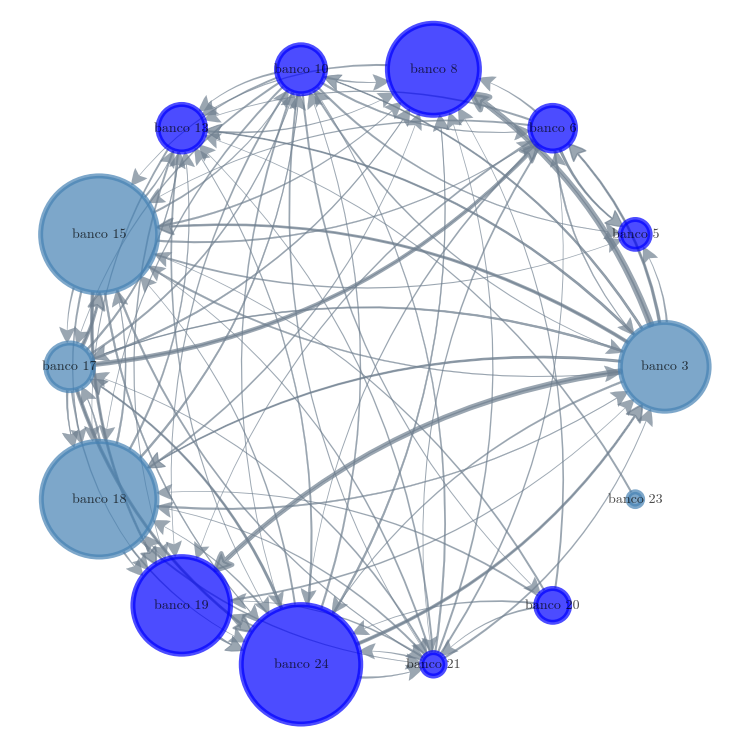

In [ ]:
#Sacamos la suma de cada una de las columnas y cada una de las filas de la matriz de los créditos interbancarios
#Restamos el total de la suma horizontal (filas) con el total de la suma vertical (columnas) para obtener la posición neta de cada uno de los bancos (Total de créditos otorgado a otros bancos- Total adeudado a otros bancos)

periodo_elegido_grafo = 202201
homotecia_nodos = 80000 #valor por el cual se multiplica el diámetro de nodos cuando se utiliza el patrimonio efectivo para una mejor visualización del grafo
homotecia_flechas = 40 #valor por el cual se multiplica el tamaño de las flechas para una mejor visualización del grafo



suma_vertical_cred = []
for columna in d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo_elegido_grafo}"].columns:
  suma_vertical_cred.append(d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo_elegido_grafo}"][f"{columna}"].sum()) #optenemos suma vertical

suma_horizontal_cred = d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo_elegido_grafo}"].sum(axis=1)
suma_horizontal_cred = suma_horizontal_cred.tolist() #obtenemos suma horizontal

neto_cred = [] #creamos una lista con la exposición neta de cada banco en créditos, restando ambos totales
for i,j in zip(suma_horizontal_cred, suma_vertical_cred):
  neto_cred.append(i - j)

neto_cred = pd.DataFrame(neto_cred, index =d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo_elegido_grafo}"].columns, columns = ["neto_creditos"]) #convertimos la lista anterior a un dataframe
neto_cred #obtenemos posición neta de cada uno de los bancos para asignarle un color a cada banco según su posición






bancos_ej1 = d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo_elegido_grafo}"].columns
G_ej1 = nx.DiGraph() #Se crea espacio para hacer un dígrafo


data_ej1 = []
for index, banco_1 in zip(d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo_elegido_grafo}"].index, bancos_ej1): #recorremos todas las filas
  for banco_2 in bancos_ej1: #para cada fila, recorremos todas las columnas
    if d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo_elegido_grafo}"]._get_value(index, banco_2) != 0 and banco_1 != banco_2: #si banco_2 le debe a banco_1
      data_ej1_tup = (banco_1, banco_2)
      data_ej1_tup = list(data_ej1_tup)
      data_ej1_tup.append(d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo_elegido_grafo}"]._get_value(index, banco_2))
      data_ej1_tup = tuple(data_ej1_tup)
      data_ej1.append(data_ej1_tup)

G_ej1.add_weighted_edges_from(data_ej1) #agregamos a la edgelist de bancos

#node_size
node_size = []
lista_nodos_aux = []
for i in G.nodes():
  if len(i) == 7:
    lista_nodos_aux.append(int(i[6]))
  if len(i) == 8:
    lista_nodos_aux.append(int(i[6:8]))
  if len(i) == 9:
    lista_nodos_aux.append(int(i[6:9]))

for nodo in lista_nodos_aux:
  node_size.append(homotecia_nodos*int(df_cap[df_cap['periodo'] == periodo_elegido_grafo][df_cap['cod_01'] == nodo]['PatEf'].values)/df_deuda_relativa_sistema.at[f"{periodo_elegido_grafo}", "patrimonio_efectivo"])

width = [] #generamos una lista con ponderadores según % que representa cada crédito sobre el total y con la opción de ponderar estos valores con un parámetro de homotecia (hace crecer el grosor de todas las flechas en la misma proporción para la presentación)
for index, banco_1 in zip(d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo_elegido_grafo}"].index, bancos_ej1): 
    for banco_2 in bancos_ej1:
        if d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo_elegido_grafo}"]._get_value(index, banco_2) != 0:
          width.append(d_exp_cred_inst_relativa_t[f"df_mat_cred_inst_relativa_{periodo_elegido_grafo}"]._get_value(index, banco_2)*homotecia_flechas)

plt.rcParams["figure.figsize"] = (10,10)

#asignamos color a los bancos según sean prestatarios o prestamistas netos calculados anteriormente
#"Steelblue" para prestamista y "blue" para prestatarios
node_color = []

for i in list(G.nodes()): 
  if neto_cred.at[f"{i}".strip(), "neto_creditos"] >=0:
    node_color.append("steelblue")
  else:
    node_color.append("blue")

lista_nodos_ok = []
for i in G.nodes():
 lista_nodos_ok.append(i.replace("_", " "))

d_nodos_ok = {}

for nodo, nodo_ok in zip(G.nodes(), lista_nodos_ok):
  d_nodos_ok[f'{nodo}'] = nodo_ok

#Graficamos Grafo de redes de la matriz créditos interbancarios con el tamaño de los nodos en función del % del patrimonio efectivo sobre el total.
f1 = ArrowStyle.Fancy(head_length=0.8, head_width=0.8, tail_width=0.1) #configuración de las flechas del grafo 
nx.draw_circular(G , label="Interconexión en el sistema bancario chileno - créditos interbancarios",arrowsize=20, 
                 arrowstyle=f1, alpha=0.7, connectionstyle="arc3,rad=0.2", linewidths=5, font_size=14, with_labels=True, 
                 edge_color="slategrey", width = width, node_color = node_color, node_size = node_size, font_family = 'serif', labels = d_nodos_ok
) 

if d_descargas_figuras == 'Y':
  plt.savefig(f"grafo.pdf")
  files.download(f"grafo.pdf") 

In [ ]:
df_part_binario = pd.DataFrame(index = df_cap['periodo'].unique(), columns = df_cap['cod_01'].unique())
for periodo in df_cap['periodo'].unique():
  for banco in df_cap['cod_01'].unique():
    if banco in list(df_exp_cred[df_exp_cred['periodo'] == periodo][df_exp_cred['tot_deuda'] != 0]['cod_01']) or banco in list(df_exp_cred[df_exp_cred['periodo'] == periodo][df_exp_cred['tot_deuda'] != 0]['cod_02']) or banco in list(df_exp_inst[df_exp_inst['periodo'] == periodo][df_exp_inst['valor'] != 0]['cod_01']) or banco in list(df_exp_inst[df_exp_inst['periodo'] == periodo][df_exp_inst['valor'] != 0]['cod_02']):
      df_part_binario.at[periodo, banco] = 1
    else:
      df_part_binario.at[periodo, banco] = 0
df_part_binario = df_part_binario.add_prefix('banco_')

<ipython-input-24-cb5bfa33cd0c>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if banco in list(df_exp_cred[df_exp_cred['periodo'] == periodo][df_exp_cred['tot_deuda'] != 0]['cod_01']) or banco in list(df_exp_cred[df_exp_cred['periodo'] == periodo][df_exp_cred['tot_deuda'] != 0]['cod_02']) or banco in list(df_exp_inst[df_exp_inst['periodo'] == periodo][df_exp_inst['valor'] != 0]['cod_01']) or banco in list(df_exp_inst[df_exp_inst['periodo'] == periodo][df_exp_inst['valor'] != 0]['cod_02']):


Número de bancos que nunca participaron

In [ ]:
total_bancos = len(list(df_cap['cod_01'].unique()))
print(f'De un total de {total_bancos} bancos presentes en la muestra,',f'{sum(x == 0 for x in list(df_part_binario.sum(axis=0)))} bancos no participaron de las exposiciones')

De un total de 19 bancos presentes en la muestra, 2 bancos no participaron de las exposiciones


Duración promedio de un banco en el sistema: cada vez que entra un banco cuánto dura

In [ ]:
lista_duraciones = []
for banco in df_part_binario.columns:
  lista_aux = []
  duracion_acumulada = 0
  n_participacion_banco = 0
  for i, periodo in enumerate(df_part_binario.index):
    if i == 0 and df_part_binario.at[periodo, f'{banco}'] == 1: #partimos el caso donde el banco participa desde el primer período
      duracion_acumulada = 1
    if i > 0 and df_part_binario.at[periodo, f'{banco}'] == 1 and df_part_binario.at[list(enumerate(df_part_binario.index))[i-1][1], f'{banco}'] == 1: #acumulamos la duracion
      duracion_acumulada = duracion_acumulada + 1
    if i > 0 and df_part_binario.at[periodo, f'{banco}'] == 0 and df_part_binario.at[list(enumerate(df_part_binario.index))[i-1][1], f'{banco}'] == 1: #cortamos la duracion donde deja de participar y la guardamos
      lista_aux.append(duracion_acumulada)
    if i == (len(df_part_binario.index) - 1) and 0 not in df_part_binario[f'{banco}']:
      lista_aux.append(duracion_acumulada)
  lista_duraciones.append(sum(lista_aux)/len(lista_aux))

print(f'El promedio de la duración de un banco en el sistema es de: {"{:.3f}".format(sum(lista_duraciones)/len(lista_duraciones))} meses. Este promedio considera un rango de {len(df_part_binario.index)} meses en los que los bancos pudieron haber participado en las exposiciones')


El promedio de la duración de un banco en el sistema es de: 34.182 meses. Este promedio considera un rango de 45 meses en los que los bancos pudieron haber participado en las exposiciones


Probabilidad de participar condicional a que se participó el período anterior

In [ ]:

lista_condicional = [] #guarda participaciones condicional a que se participó el período pasado, considerando todos los bancos
for banco in df_part_binario.columns:
  for i, periodo in enumerate(df_part_binario.index):
    if i > 0: #no rellenamos nunca con datos del primer período ya que depende de uno anterior inexistente
      if df_part_binario.at[periodo, f'{banco}'] == 1 and df_part_binario.at[list(enumerate(df_part_binario.index))[i-1][1], f'{banco}'] == 1: 
        lista_condicional.append(1)
      if df_part_binario.at[periodo, f'{banco}'] == 0 and df_part_binario.at[list(enumerate(df_part_binario.index))[i-1][1], f'{banco}'] == 1:
        lista_condicional.append(0)

print(f'La probabilidad de que un banco participe en cierto período condicional a que participó en el período anterior es de {"{:.3%}".format(sum(lista_condicional)/len(lista_condicional))}')

La probabilidad de que un banco participe en cierto período condicional a que participó en el período anterior es de 98.343%


G1

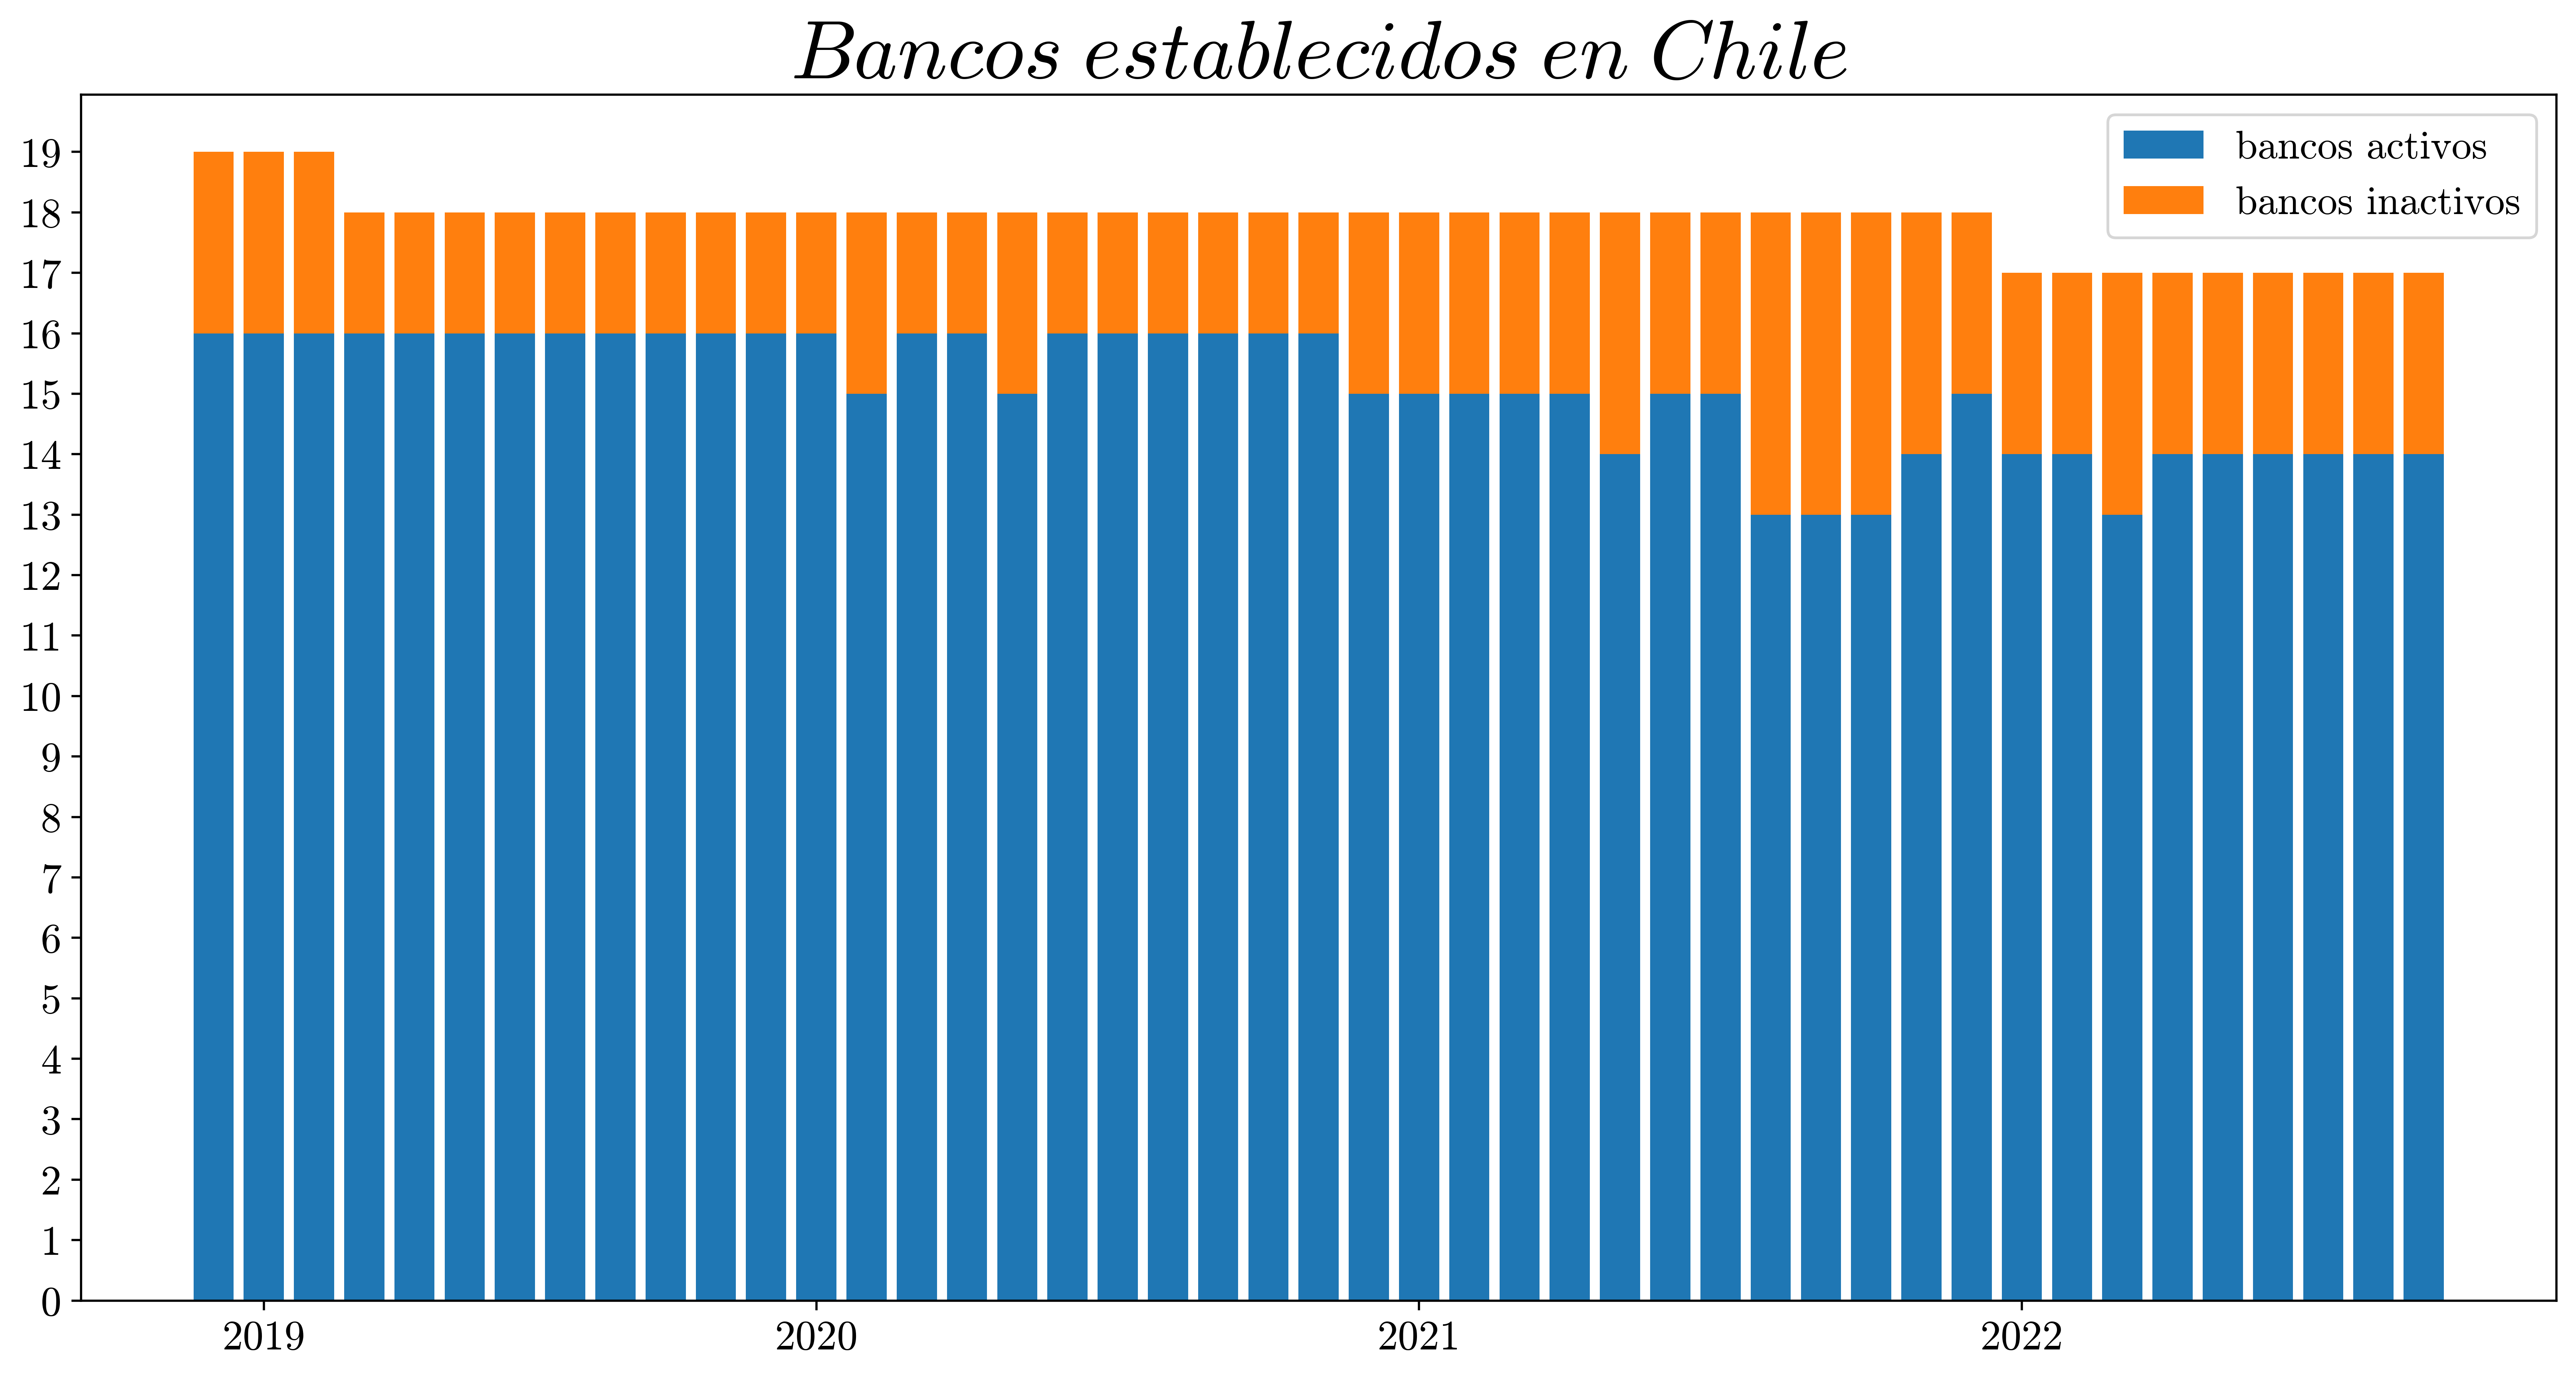

In [ ]:
#pasamos los periodos del df anterior a un formato de fecha
df_part_bancos.index = df_part_bancos.index.map(str)
for indexes, fecha in enumerate(df_part_bancos.index):
  datetime.strptime(df_part_bancos.index[indexes], '%Y%m')


# tamaño figura
plt.figure(figsize=(16, 8), dpi=500)

p1 = plt.bar(df_part_bancos.index, df_part_bancos['bancos_participantes (nodos)'])
p2 = plt.bar(df_part_bancos.index, df_part_bancos['bancos_no_participantes'], bottom = df_part_bancos['bancos_participantes (nodos)'])
 

#plt.xticks(ind, df_part_bancos.index)
plt.yticks(np.arange(0, df_part_bancos['suma_bancos'].max()+1, 1), size = 15)
plt.legend((p1[0], p2[0]), ('bancos_participantes (nodos)', 'bancos_no_participantes'))


 
# título
plt.title(r'$Bancos\;establecidos\;en\;Chile$', size = 30)

# nombre eje x
plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15)
    


  # leyenda
plt.legend(['bancos activos', 'bancos inactivos'], fontsize = 'x-large')




#plt.savefig(f"bancos_participantes_cred_inst.png")
#files.download(f"bancos_participantes_cred_inst.png") 

if d_descargas_figuras == 'Y':
  plt.savefig(f"1. bancos_participantes_cred_inst.pdf")
  files.download(f"1. bancos_participantes_cred_inst.pdf") 



plt.show()


  
#plt.cla() #limpiamos memoria
#plt.close()



G2

In [ ]:
media_pat_efectivo = df_cap['PatEf'].mean()
desv_est_pat_efectivo = np.std(df_cap['PatEf'])
mediana_pat_efectivo = np.percentile(df_cap['PatEf'], 50)
print(f'La media del patrimonio efectivo es de ${round(media_pat_efectivo/1000, 0)} +/- ${round(desv_est_pat_efectivo/1000, 0)} miles de millones de pesos, mientras que la mediana es de ${round(mediana_pat_efectivo/1000, 0)} miles de millones de pesos')

La media del patrimonio efectivo es de $1652.0 +/- $1867.0 miles de millones de pesos, mientras que la mediana es de $785.0 miles de millones de pesos


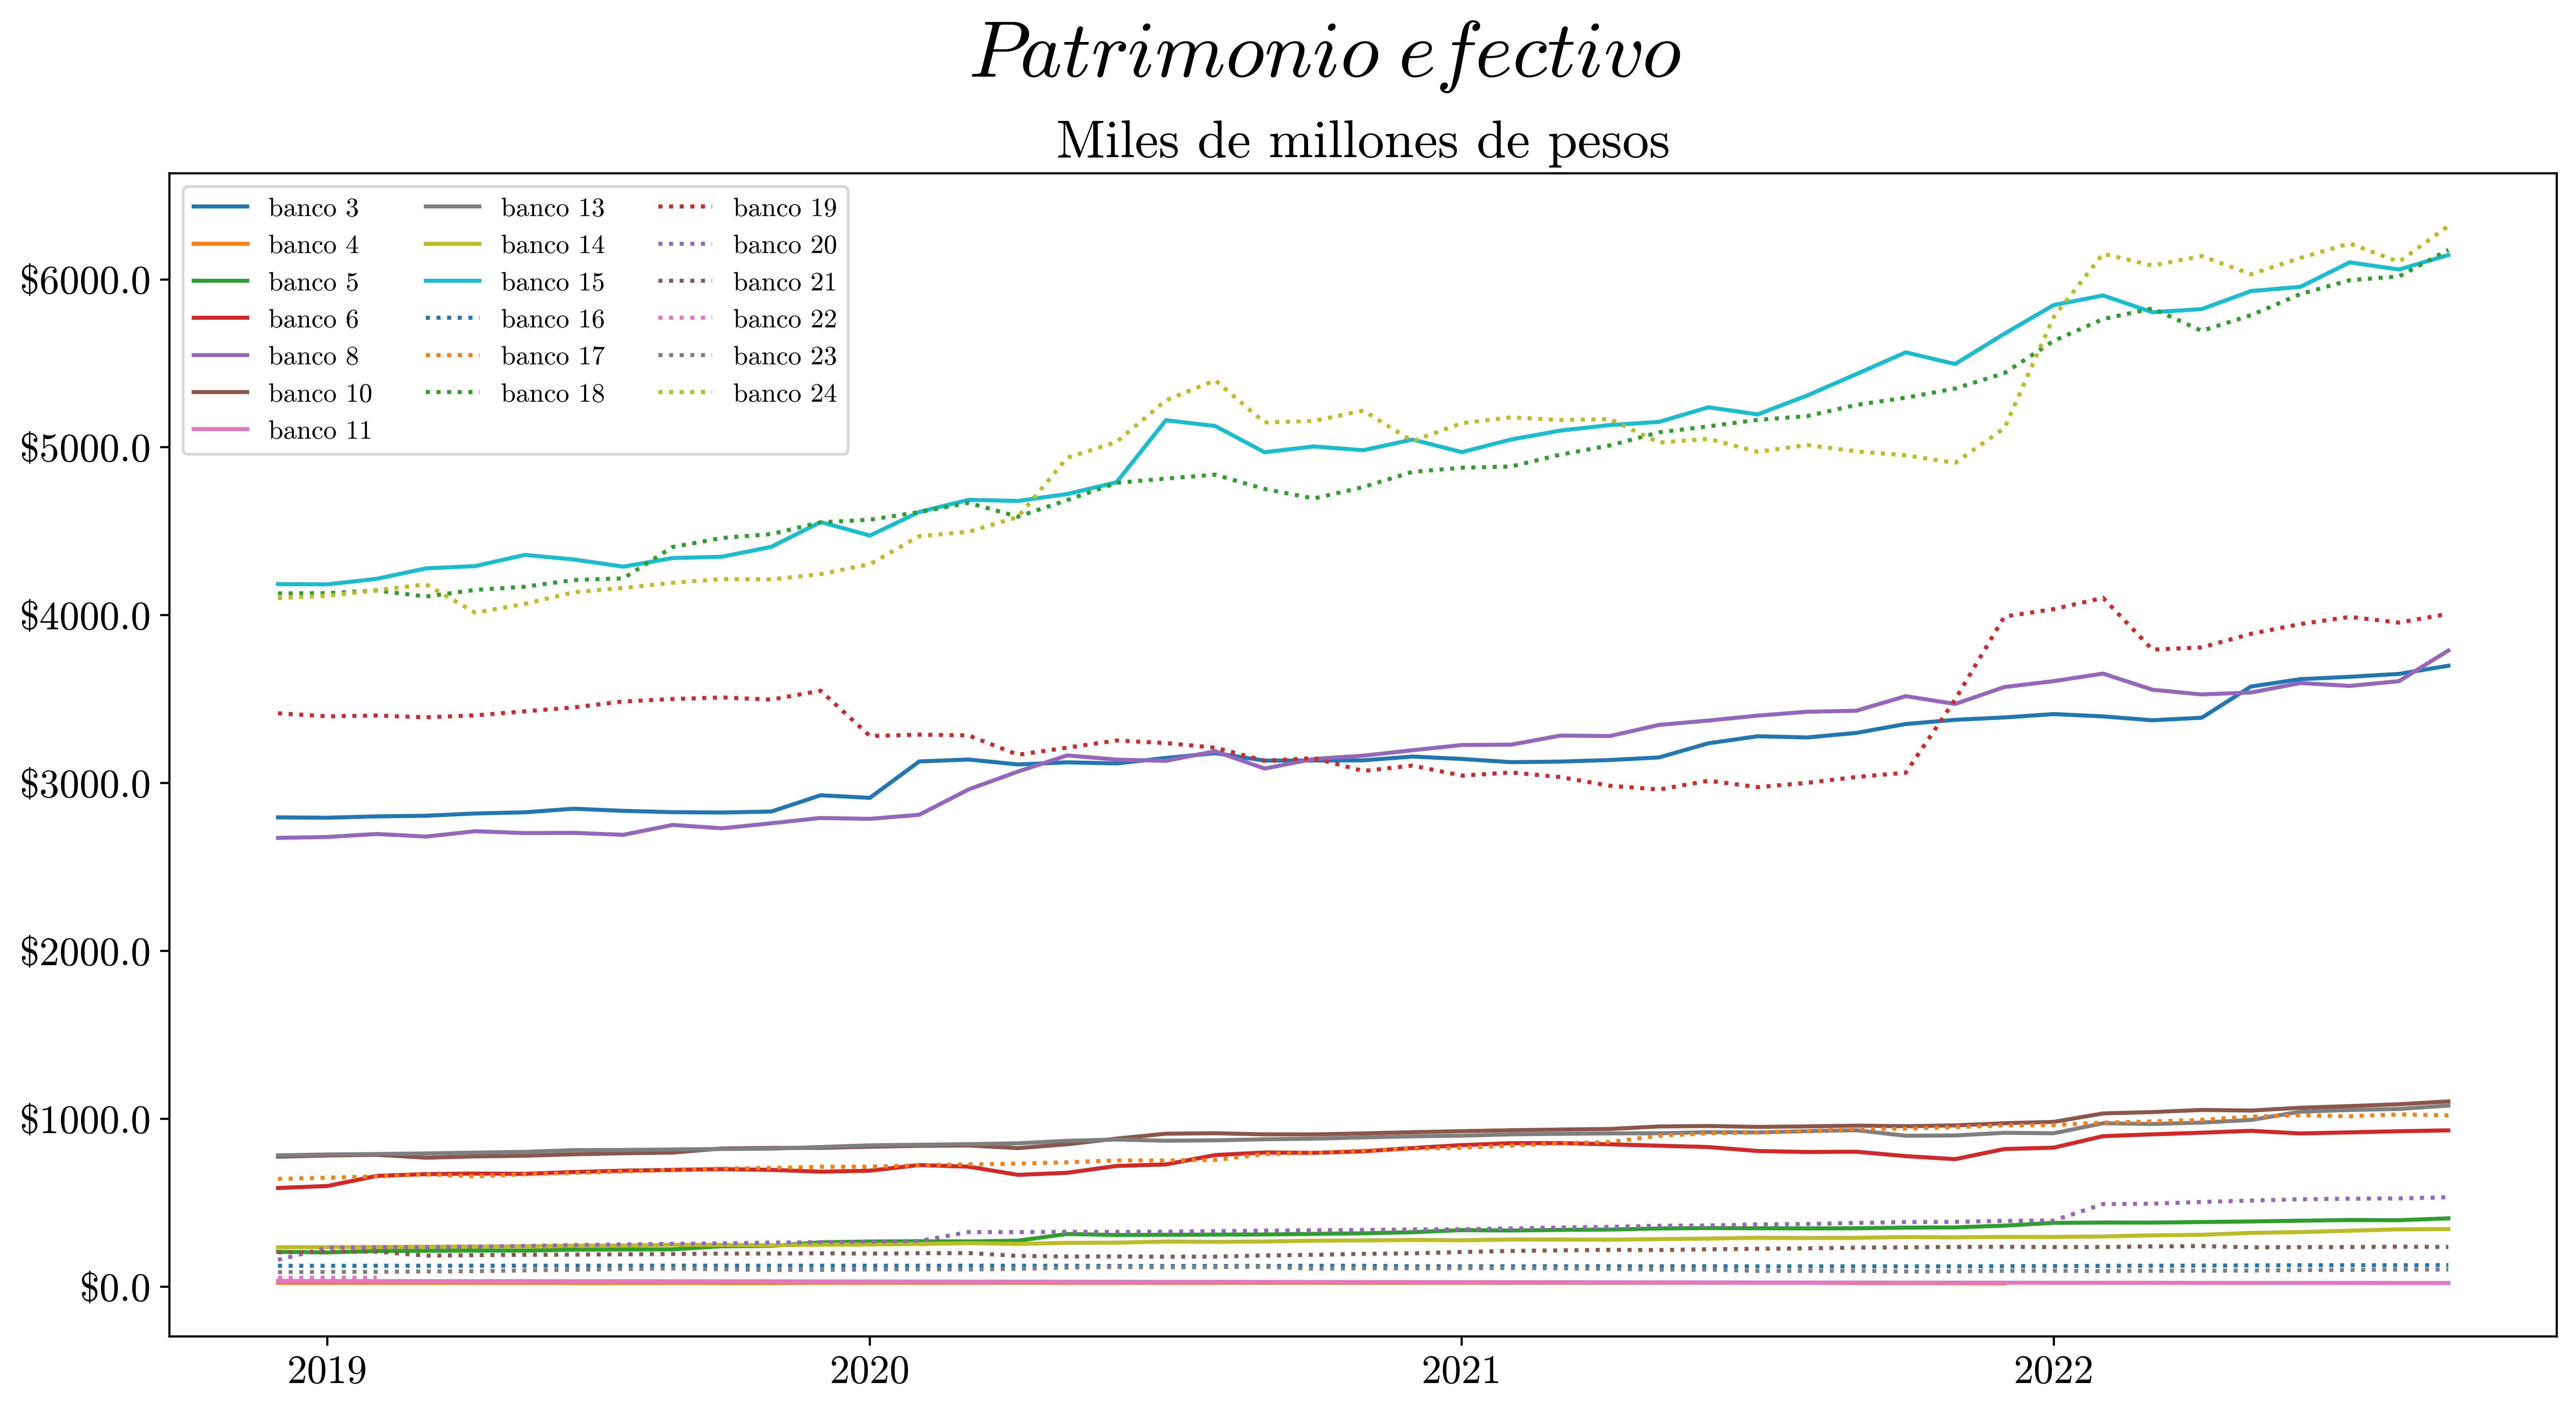

In [ ]:
# tamaño figura
plt.figure(figsize=(16, 8), dpi=500)
    


for i, banco in enumerate (df_cap['cod_01'].unique()):
  df_aux_patef = pd.DataFrame(list(df_cap[df_cap['cod_01'] == banco]['PatEf']/1000), index = df_cap[df_cap['cod_01'] == banco]['periodo'], columns = ['PatEf'])

  #pasamos los periodos a un formato de fecha
  df_aux_patef.index = df_aux_patef.index.map(str)
  for indexes, fecha in enumerate(df_aux_patef.index):
    datetime.strptime(df_aux_patef.index[indexes], '%Y%m')

  if i<=9:
    df_aux_patef['PatEf'].plot( linestyle = 'solid')
    plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15)
    
  if i<=19 and i>9:
    df_aux_patef['PatEf'].plot( linestyle = 'dotted')
    plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15)    
    
  if i<=29 and i>19:
    df_aux_patef['PatEf'].plot( linestyle = 'dashed')
    plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15)
    
  if i<=39 and i>29:
    df_aux_patef['PatEf'].plot( linestyle = 'dashdot')
    plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15)   





# título
plt.suptitle(r'$Patrimonio\;efectivo$', size = 30)
plt.title('Miles de millones de pesos', size = 20)

#formato eje
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('$%s'))

plt.xlabel('')

plt.yticks(size = 15)



#leyenda
lista_bancos_aux = []
for i in list(df_cap['cod_01'].unique()):
  lista_bancos_aux.append(f'banco {str(i)}')
plt.legend(lista_bancos_aux, ncol = 3)

if d_descargas_figuras == 'Y':
  plt.savefig(f"2. ev_pat_efectivo_bancos.pdf")
  files.download(f"2. ev_pat_efectivo_bancos.pdf") 

G3

In [ ]:
recuento_exp_cred = df_exp_cred[df_exp_cred['tot_deuda'] > 0]['tot_deuda'].count()
recuento_exp_inst = df_exp_inst[df_exp_inst['valor'] > 0]['valor'].count()
recuento_periodos = len(df_cap['periodo'].unique())
print(f'El número de exposiciones por créditos mayores a 0 fue de {recuento_exp_cred} y el de instrumentos fue de {recuento_exp_inst}, ambos considerando {recuento_periodos} períodos.')

El número de exposiciones por créditos mayores a 0 fue de 341 y el de instrumentos fue de 2848, ambos considerando 45 períodos.


In [ ]:
#utilizamos un código de la creación de las bases de datos originales para recuperar el total de exposiciones por período

lista_total_exp = []
for periodo in df_cap['periodo'].unique():
  df_exp_cred_inst_aux = pd.DataFrame(0, index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique(), columns = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique()).astype(float)
  for prestamista in d_exp_cred_t[f"d_mat_cred_{periodo}"].index:
    for deudor in d_exp_cred_t[f"d_mat_cred_{periodo}"].index:
      df_exp_cred_inst_aux.at[prestamista, deudor] = d_exp_cred_t[f"d_mat_cred_{periodo}"].at[prestamista, deudor] + d_exp_inst_t[f"d_mat_inst_{periodo}"].at[prestamista, deudor]
  lista_total_exp.append(int(df_exp_cred_inst_aux.to_numpy().sum()))

df_total_exp = pd.DataFrame(lista_total_exp, index = df_cap['periodo'].unique(), columns = ['total_exposiciones'])
df_total_exp['total_exposiciones'] = df_total_exp['total_exposiciones']/1000


#pasamos los periodos a un formato de fecha
df_total_exp.index = df_total_exp.index.map(str)
for indexes, fecha in enumerate(df_total_exp.index):
  datetime.strptime(df_total_exp.index[indexes], '%Y%m')

max_exp_total = df_total_exp['total_exposiciones'].max()
mes_max_exp_total = int(df_total_exp[['total_exposiciones']].idxmax())

lista_exp = []

max_exp_aux = 0 #vamos buscando en todos los períodos la máxima exposición
periodo_max_exp_aux = 0 #guardamos el período de la máxima exposición
for periodo in df_cap['periodo'].unique():
  lista_exp_aux = []
  df_exp_cred_inst_aux = pd.DataFrame(0, index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique(), columns = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique()).astype(float)
  for prestamista in d_exp_cred_t[f"d_mat_cred_{periodo}"].index:
    for deudor in d_exp_cred_t[f"d_mat_cred_{periodo}"].index:
      #guardamos todas las exposiciones de cierto período
     lista_exp_aux.append((d_exp_cred_t[f"d_mat_cred_{periodo}"].at[prestamista, deudor] + d_exp_inst_t[f"d_mat_inst_{periodo}"].at[prestamista, deudor])/1000) #en miles de millones de pesos
     if (d_exp_cred_t[f"d_mat_cred_{periodo}"].at[prestamista, deudor] + d_exp_inst_t[f"d_mat_inst_{periodo}"].at[prestamista, deudor]) > 0:
      lista_exp.append((d_exp_cred_t[f"d_mat_cred_{periodo}"].at[prestamista, deudor] + d_exp_inst_t[f"d_mat_inst_{periodo}"].at[prestamista, deudor])/1000) #en miles de millones de pesos
  if max(lista_exp_aux) > max_exp_aux:
    max_exp_aux = max(lista_exp_aux)



max_exp_bilateral = max_exp_aux
mes_max_exp_bilateral = periodo_max_exp_aux


print(f'La mayor exposición total del sistema fue de ${round(max_exp_total, 0)} miles de millones de pesos en el período {mes_max_exp_total}, mientras que la mayor exposición bilateral fue de ${round(max_exp_bilateral, 0)} miles de millones de pesos en el período {mes_max_exp_bilateral}')

La mayor exposición total del sistema fue de $5574.0 miles de millones de pesos en el período 202201, mientras que la mayor exposición bilateral fue de $1069.0 miles de millones de pesos en el período 0


In [ ]:
mediana_exposiciones_bilaterales = np.percentile(lista_exp, 50)
media_exposiciones_bilaterales = sum(lista_exp)/len(lista_exp)
desv_est_exposiciones_bilaterales = np.std(lista_exp)
print(f'La media de las exposiciones bilaterales es de ${round(media_exposiciones_bilaterales, 0)} +/- ${round(desv_est_exposiciones_bilaterales, 0)} miles de millones de pesos, mientras que la mediana es de ${round(mediana_exposiciones_bilaterales, 0)} miles de millones de pesos')

La media de las exposiciones bilaterales es de $29.0 +/- $66.0 miles de millones de pesos, mientras que la mediana es de $7.0 miles de millones de pesos


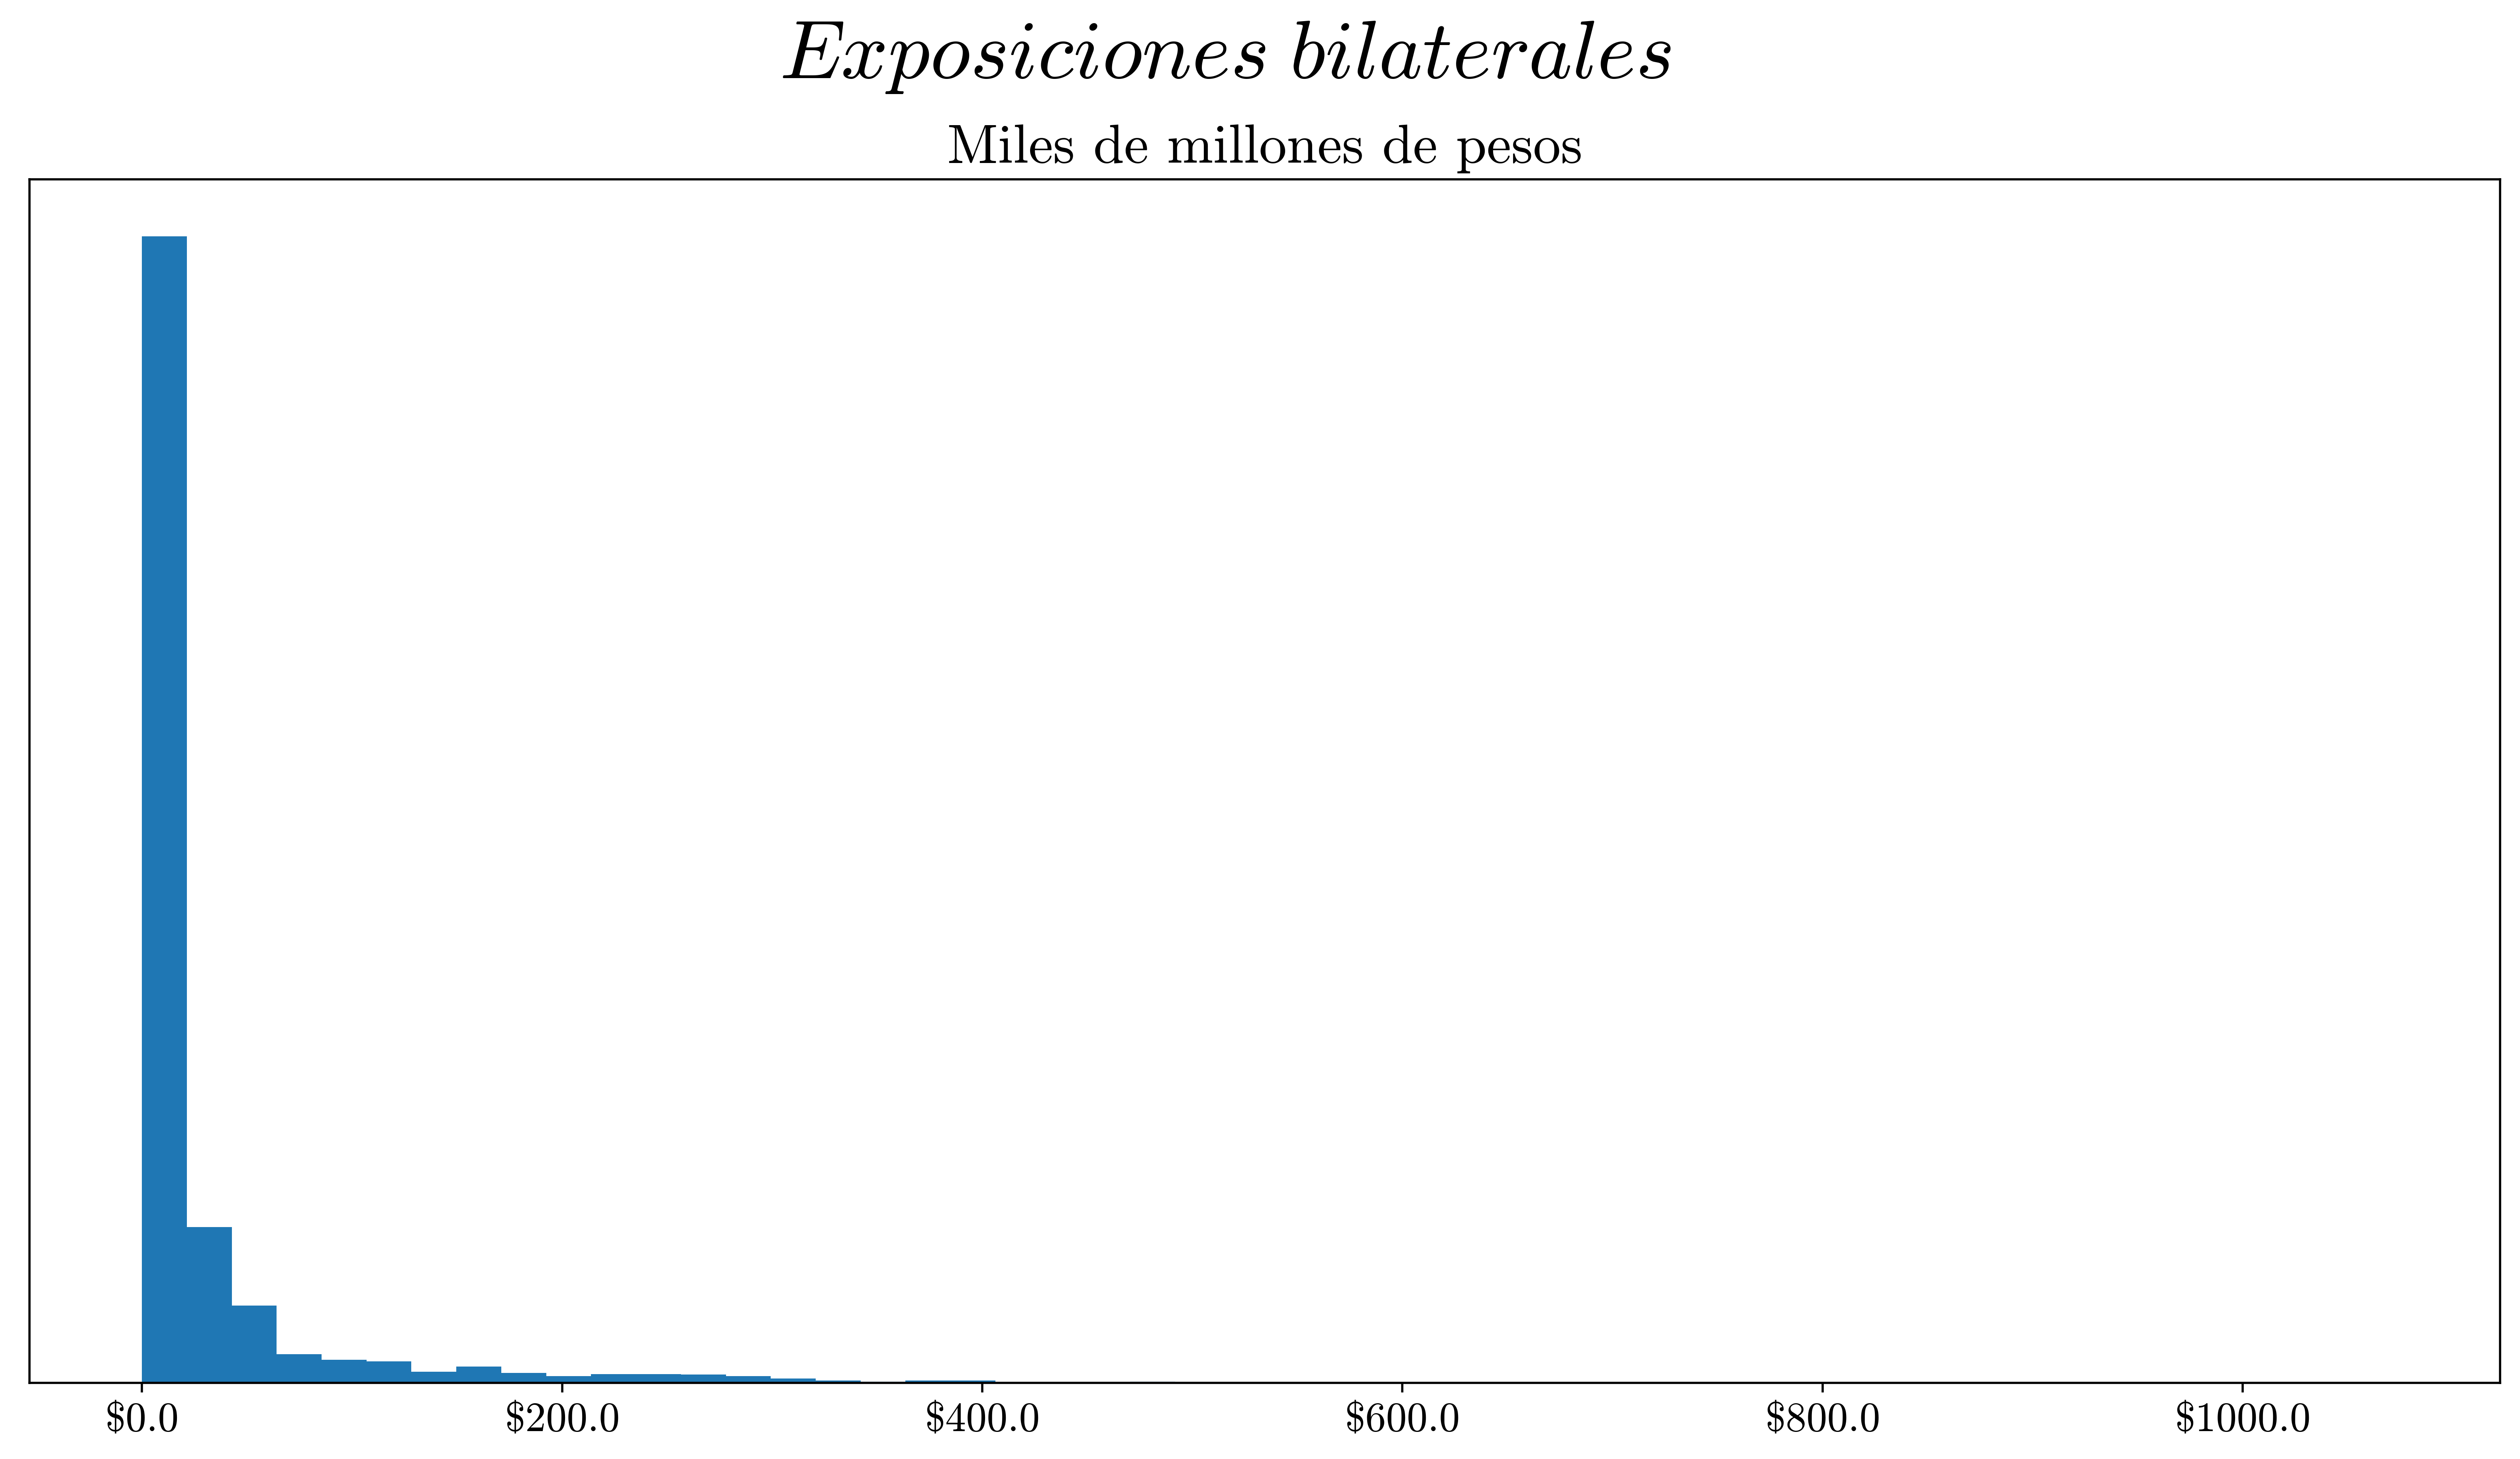

In [ ]:
# tamaño figura
plt.figure(figsize=(16, 8), dpi=500)

plt.hist(lista_exp, bins = 50)

# título
plt.suptitle(r'$Exposiciones\;bilaterales$', size = 30)
plt.title(f'Miles de millones de pesos', size = 20)

#formato eje
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('$%s'))

plt.xticks(size = 15)
plt.yticks(size = 15)

#borramos nombres de ejes
plt.gca().get_yaxis().set_visible(False)

if d_descargas_figuras == 'Y':
  plt.savefig(f"3. dist_exp_bilaterales.pdf")
  files.download(f"3. dist_exp_bilaterales.pdf") 


G4

In [ ]:
#creamos df de totales
df_totales = df_cap.groupby('periodo')['PatEf'].sum().to_frame()
df_totales = df_totales.merge(df_exp_cred.groupby('periodo')['tot_deuda'].sum().to_frame(), left_index = True, right_index = True)
df_totales = df_totales.merge(df_exp_inst.groupby('periodo')['valor'].sum().to_frame(), left_index = True, right_index = True)

#renombramos columnas
df_totales.columns = (['patrimonio_efectivo', 'creditos_interbancarios', 'instrumentos_bancarios'])

#pasamos los periodos a un formato de fecha
df_totales.index = df_totales.index.map(str)
for indexes, fecha in enumerate(df_totales.index):
  datetime.strptime(df_totales.index[indexes], '%Y%m')

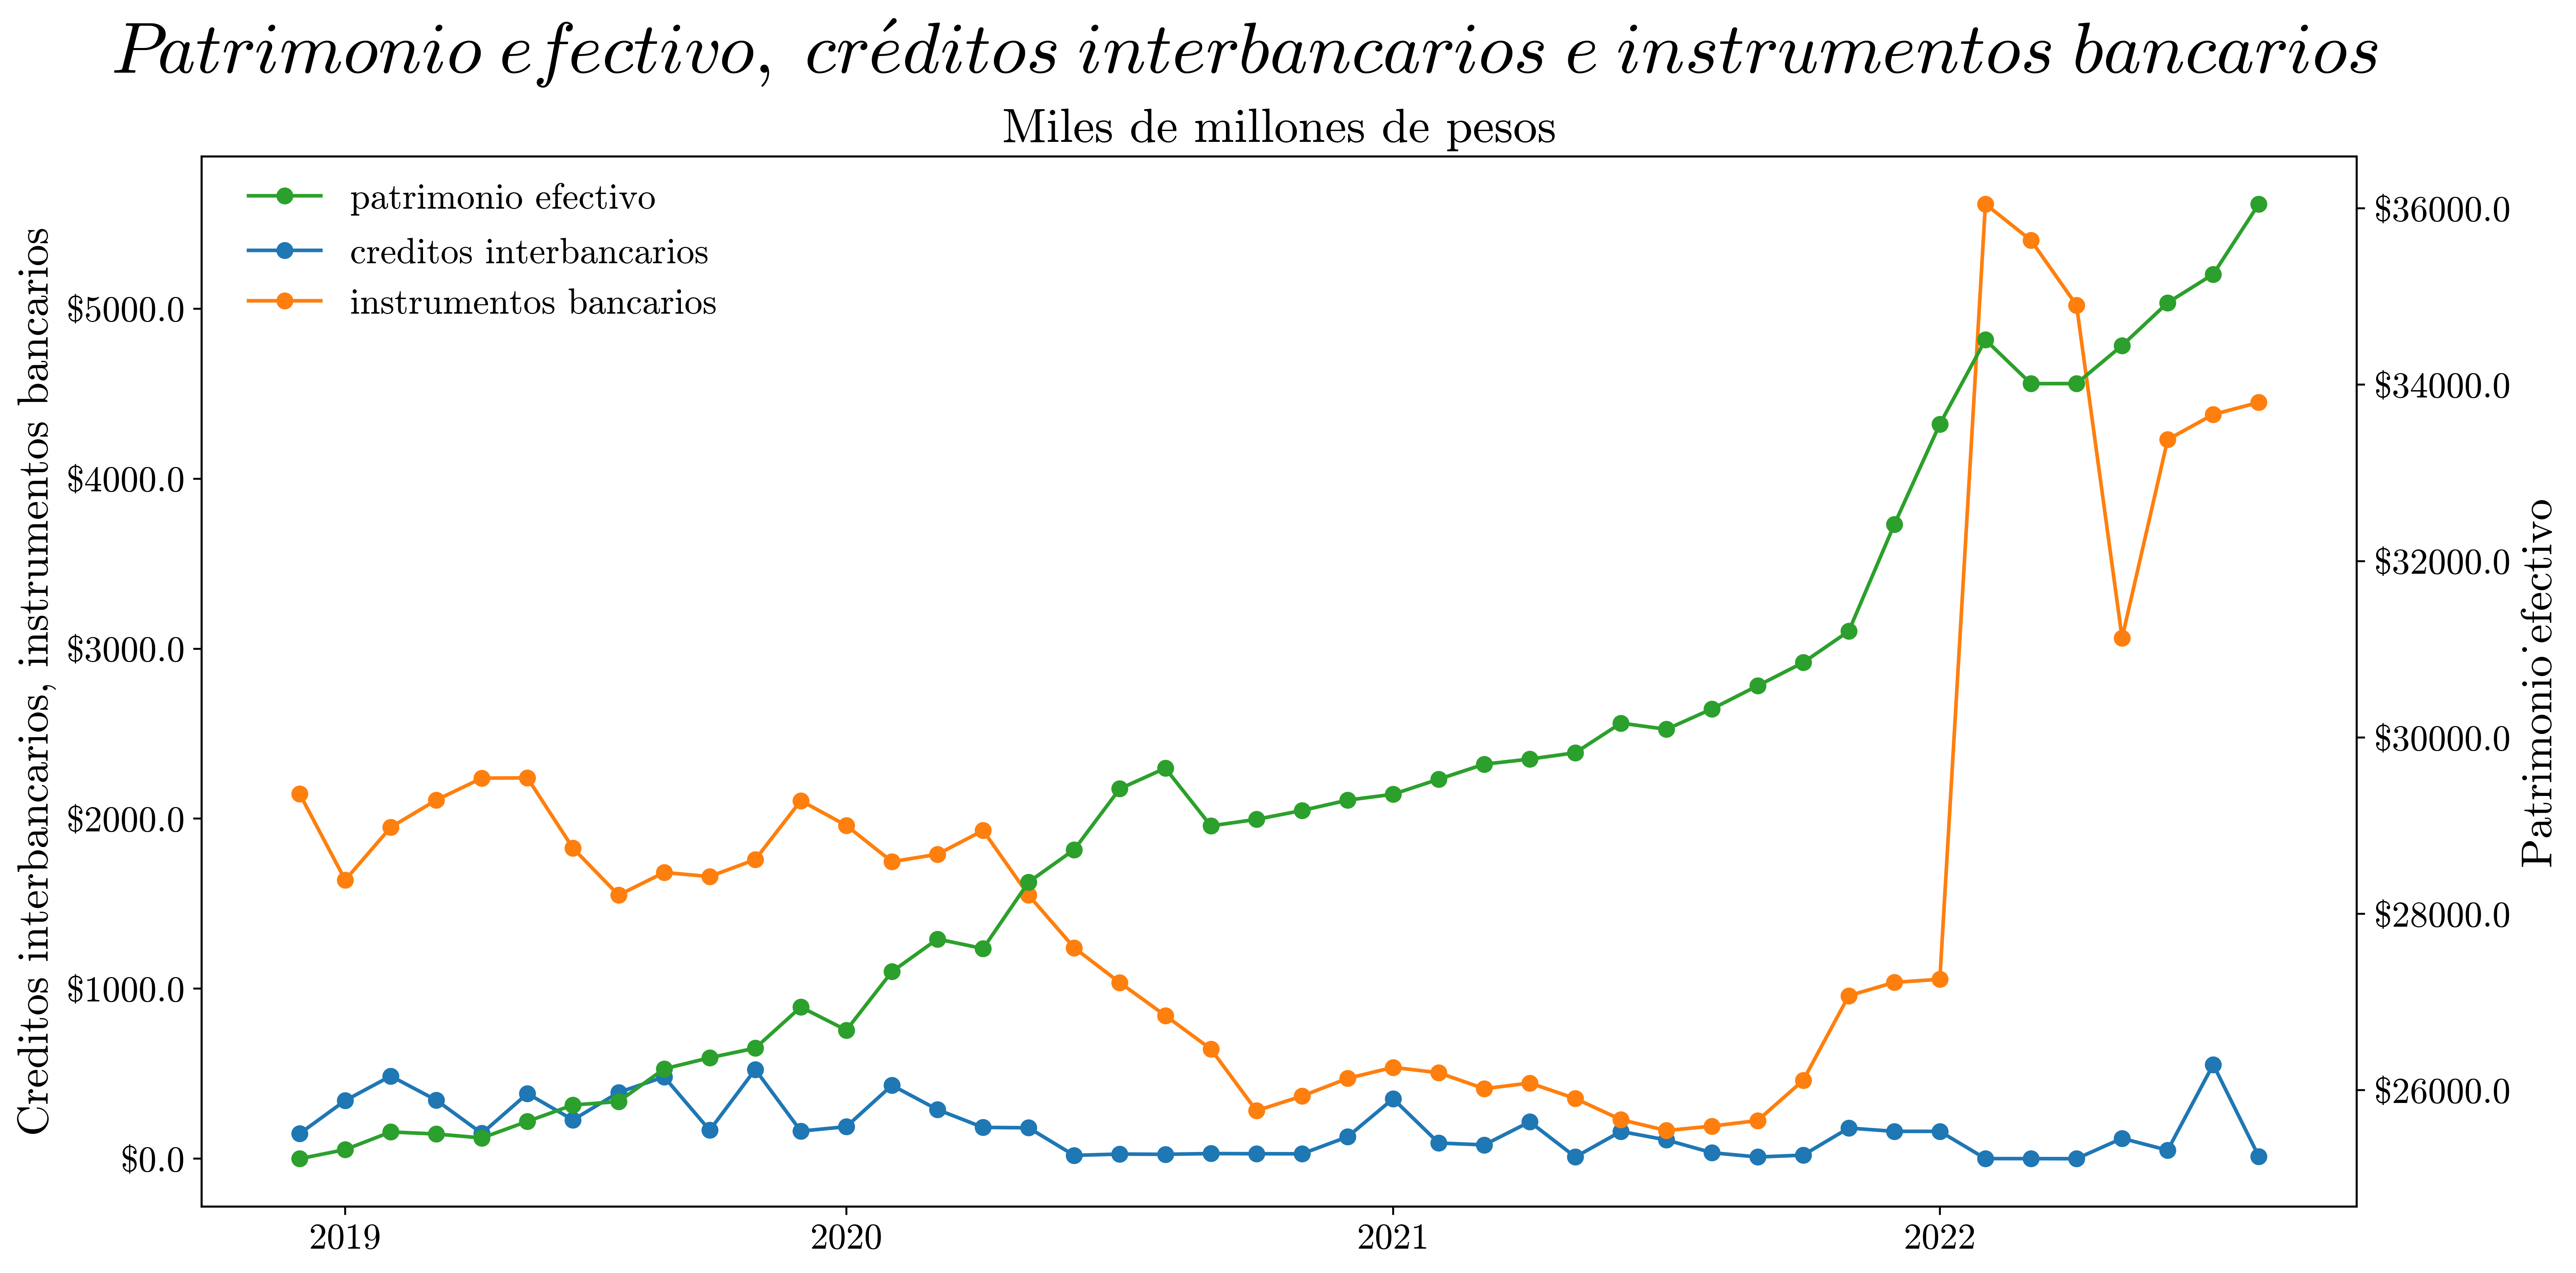

In [ ]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(16,8), dpi=500)

# make a plot
a = ax.plot(df_totales['creditos_interbancarios'].index,
        df_totales['creditos_interbancarios']/1000, color = 'C0',
        marker="o")

b = ax.plot(df_totales['instrumentos_bancarios'].index,
        df_totales['instrumentos_bancarios']/1000, color = 'C1',
        marker="o")



#eje x
# nombre eje x
plt.xticks([1, 6, 12, 18, 24, 30, 36, 42], ['', '2019', '',  '2020', '',  '2021', '', '2022'], size = 15)
plt.yticks(size = 15)
# título
plt.suptitle(r'$Patrimonio\;efectivo,\;cr\acute{e}ditos\;interbancarios\;e\;instrumentos\;bancarios$', size = 30)
plt.title(f'Miles de millones de pesos', size = 20)
plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15) 
# set y-axis label
ax.set_ylabel("Creditos interbancarios, instrumentos bancarios", fontsize=18)


#formato eje
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%s'))



#grupo 2
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
c = ax2.plot(df_totales['patrimonio_efectivo'].index,
        df_totales['patrimonio_efectivo']/1000,marker="o", color = 'C2')
ax2.set_ylabel("Patrimonio_efectivo",fontsize=18)

#formato eje
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%s'))
plt.yticks(size = 15)

plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15) 


ax.legend(['creditos interbancarios', 'instrumentos bancarios'], loc = (0.015,0.83), frameon = False, fontsize = 15)
ax2.legend(['patrimonio efectivo'], loc = (0.015,0.93), frameon = False, fontsize = 15)

if d_descargas_figuras == 'Y':
  plt.savefig(f"4. ev_patef_cred_inst.pdf")
  files.download(f"4. ev_patef_cred_inst.pdf") 

plt.show()

G5

In [ ]:
media_deuda_relativa = "{:.2%}".format(df_deuda_relativa['exposiciones_pasivo/patrimonio_efectivo'].to_numpy().mean())
desv_est_deuda_relativa = "{:.2%}".format(np.std(df_deuda_relativa['exposiciones_pasivo/patrimonio_efectivo'].to_numpy()))
mediana_deuda_relativa = "{:.2%}".format(np.percentile(df_deuda_relativa['exposiciones_pasivo/patrimonio_efectivo'].to_numpy(), 50))
print(f'La media de la exposición relativa es de {media_deuda_relativa} +/- {desv_est_deuda_relativa} sobre el patrimonio efectivo del banco expuesto, mientras que la mediana es de {mediana_deuda_relativa}')


La media de la exposición relativa es de 6.29% +/- 7.73% sobre el patrimonio efectivo del banco expuesto, mientras que la mediana es de 3.59%


In [ ]:
max_deuda_relativa = "{:.2%}".format(df_deuda_relativa['exposiciones_pasivo/patrimonio_efectivo'].to_numpy().max())
print(f'El máximo de la exposición relativa es de {max_deuda_relativa}')

El máximo de la exposición relativa es de 43.11%


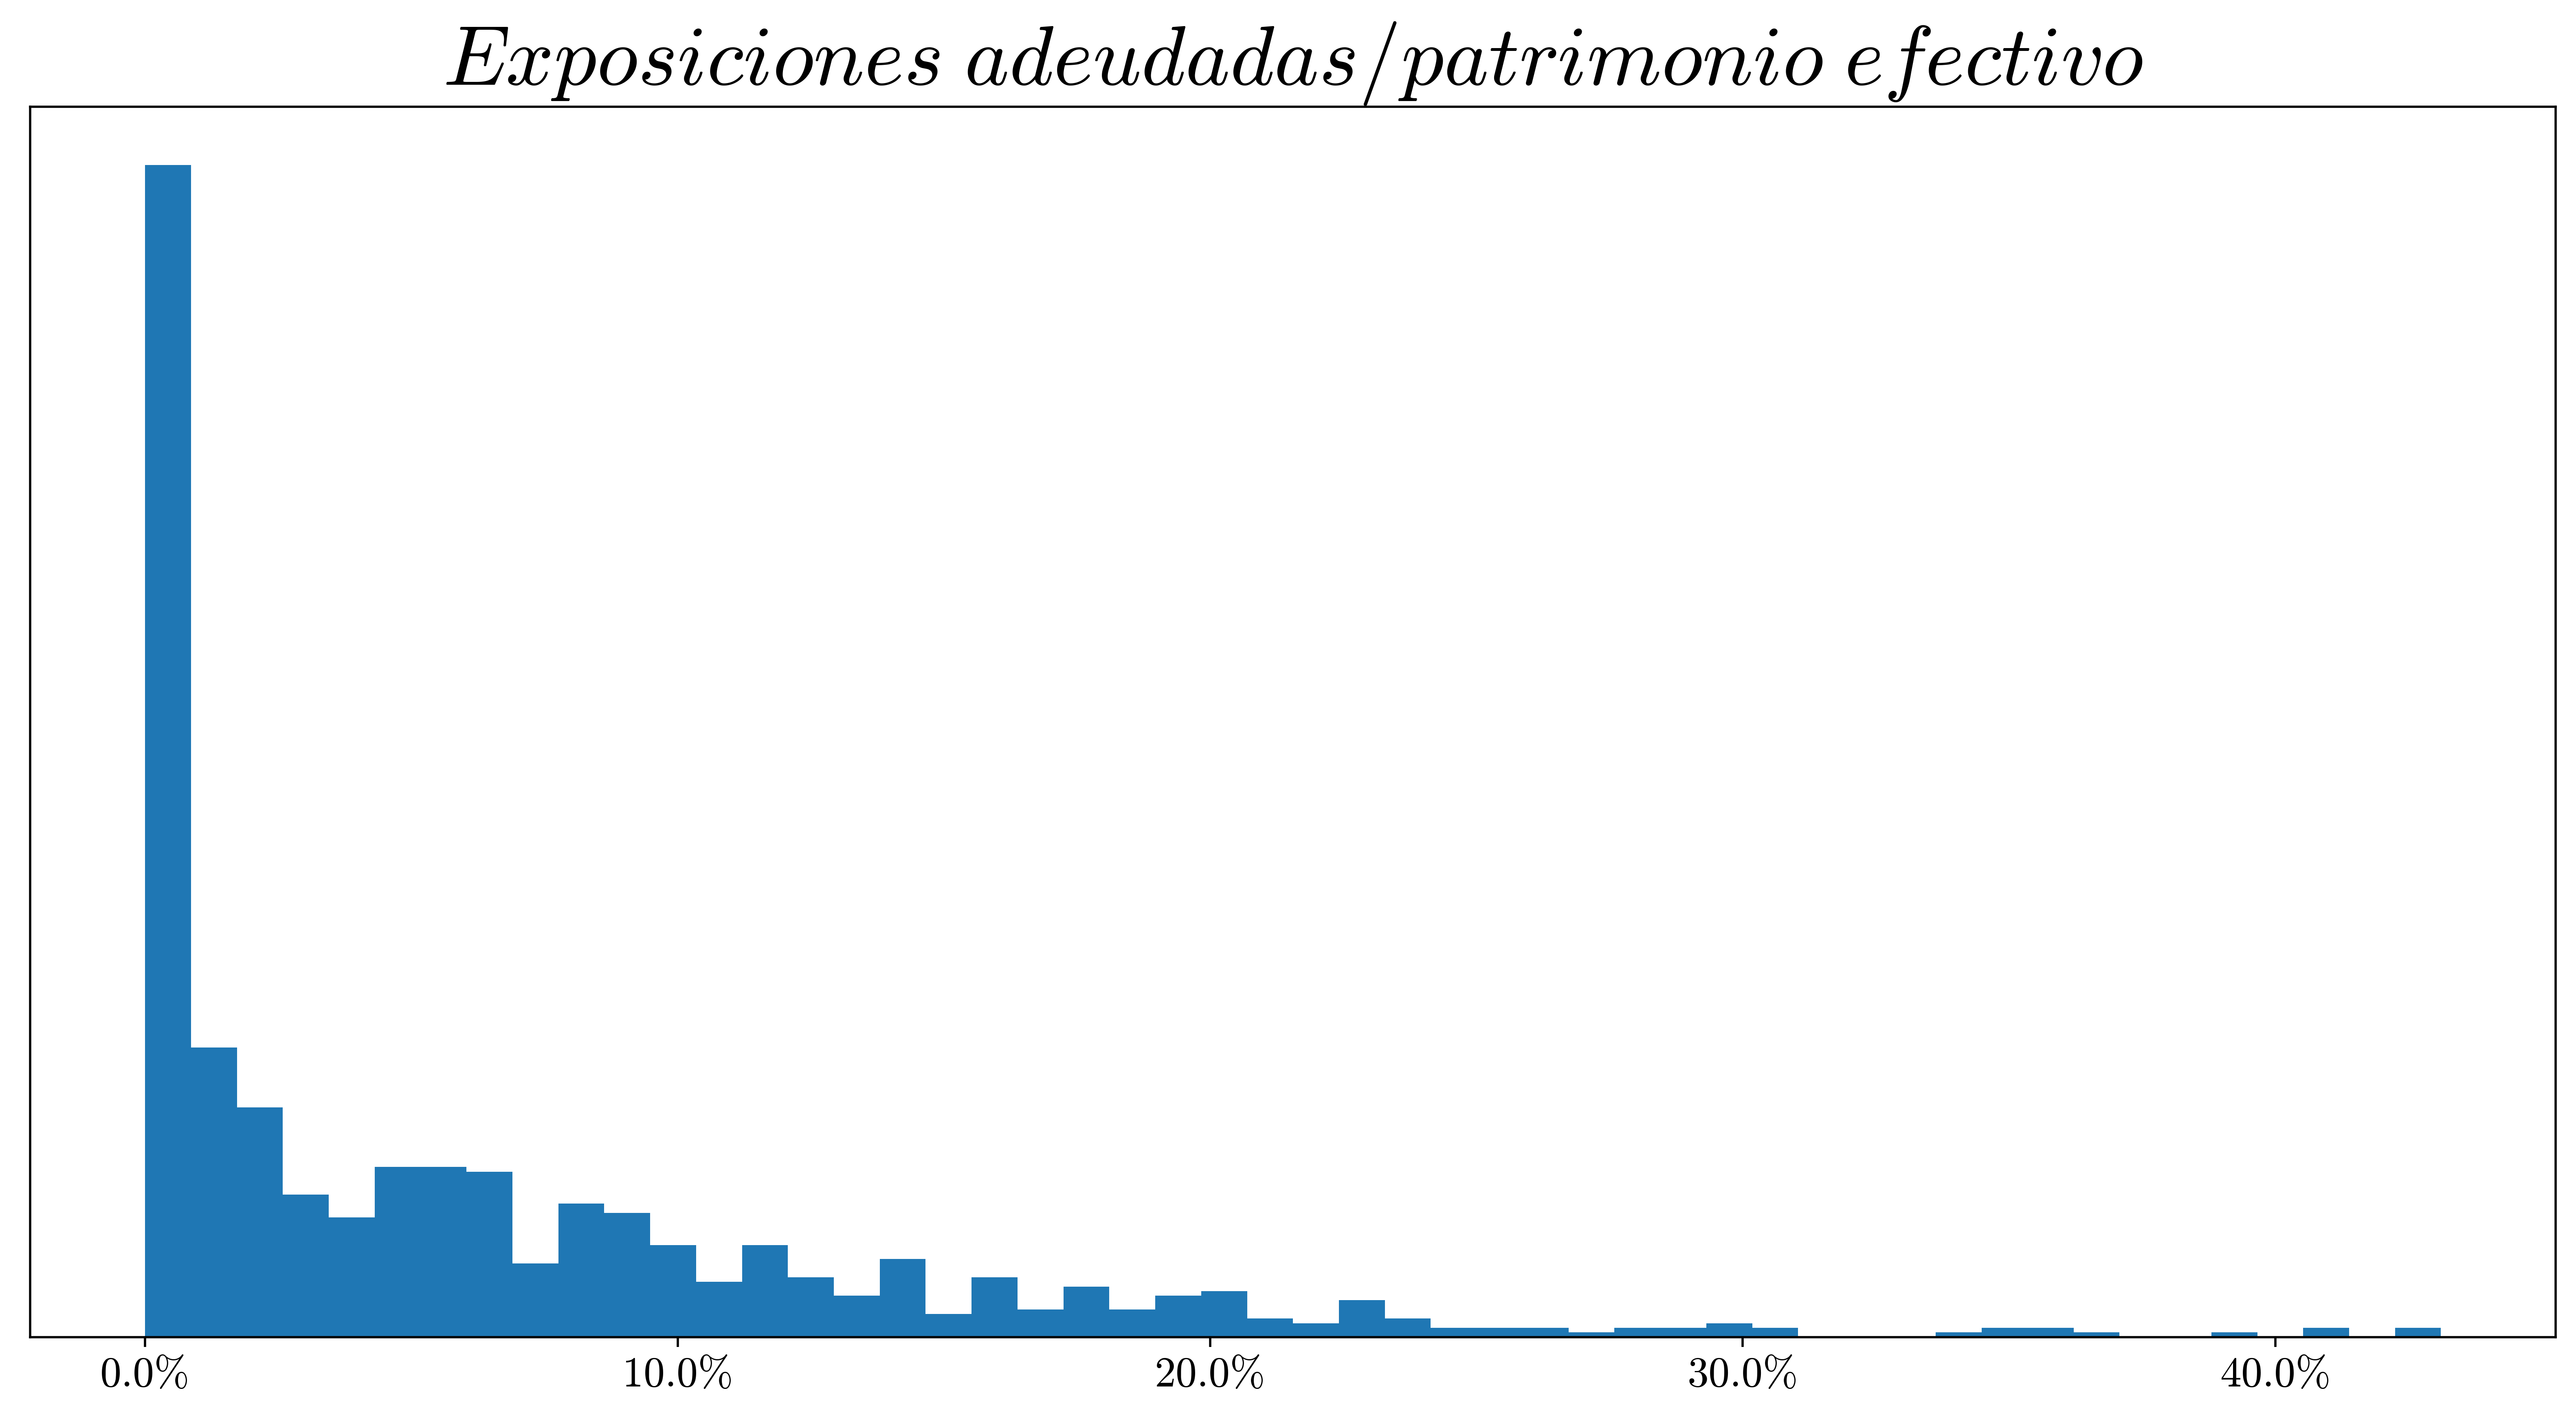

In [ ]:
#gráfico distribución exposiciones/pat_efectivo
# tamaño figura
plt.figure(figsize=(16, 8), dpi=500)

plt.hist(df_deuda_relativa['exposiciones_pasivo/patrimonio_efectivo'], bins = 50)

# título
plt.title(r'$Exposiciones\;adeudadas/patrimonio\;efectivo$', size = 30)

plt.xticks(size = 15)

#formato eje
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('$%s'))   
# nombre eje x


#borramos nombres de ejes
plt.gca().get_yaxis().set_visible(False)

plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

if d_descargas_figuras == 'Y':
  plt.savefig(f"5. dist_deudas_patef.pdf")
  files.download(f"5. dist_deudas_patef.pdf") 

G6

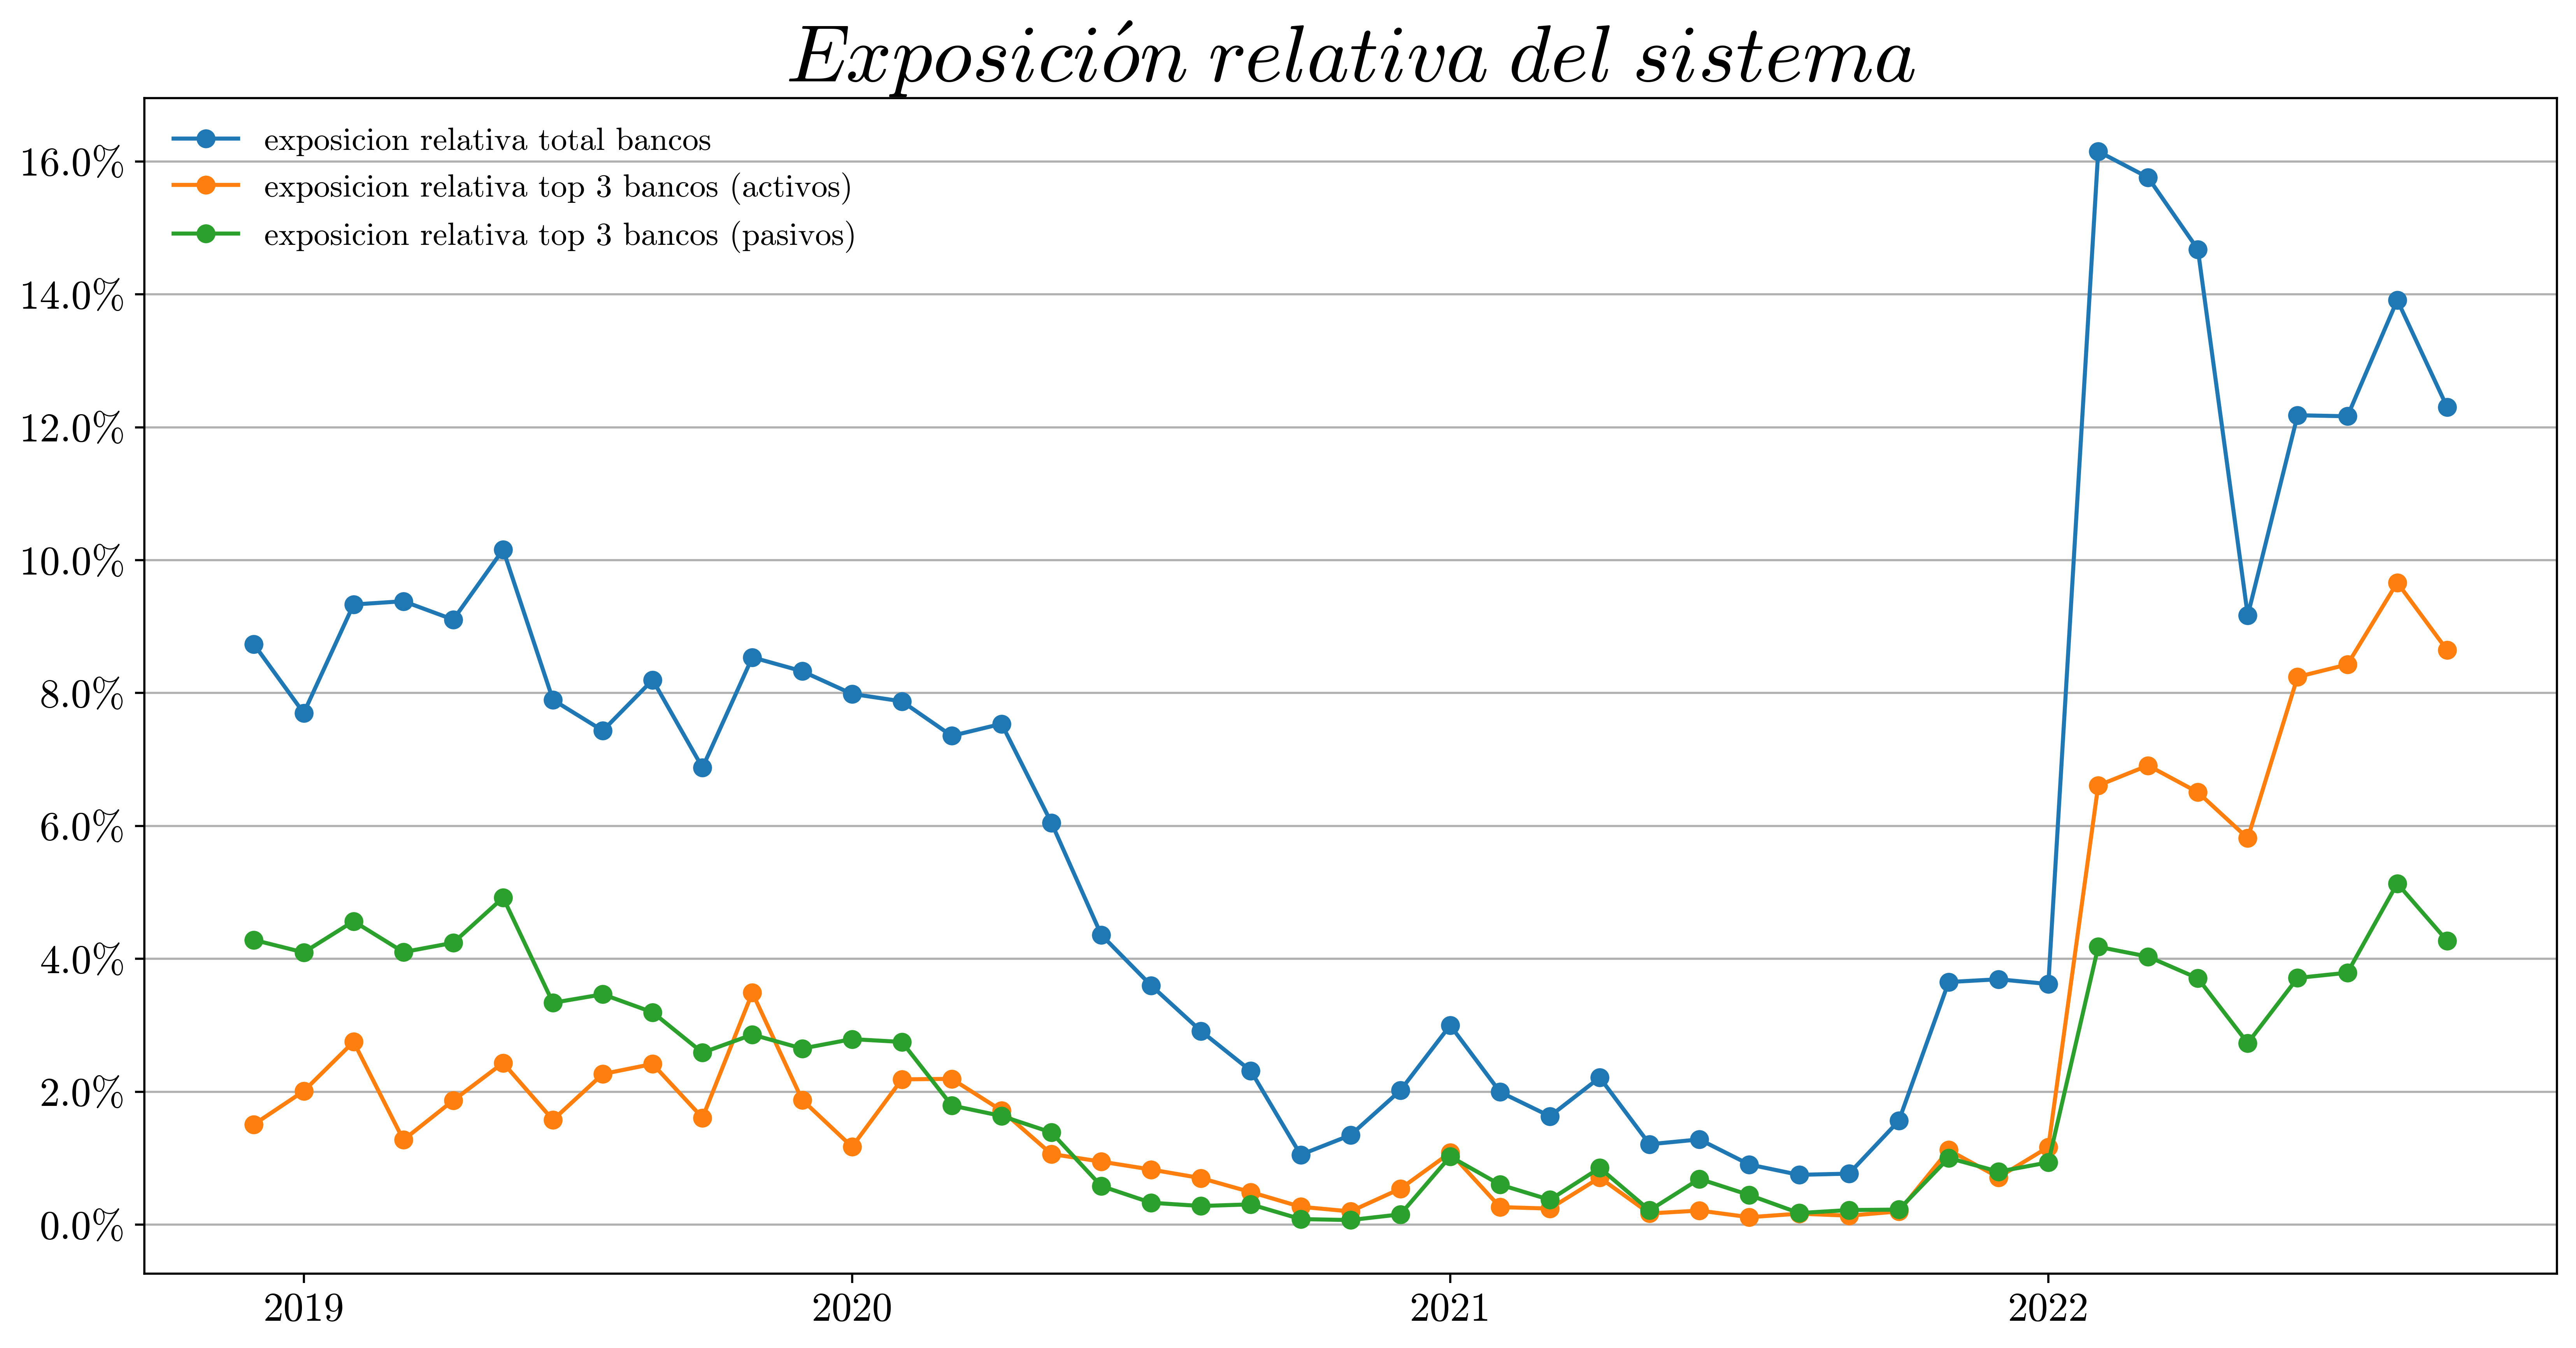

In [ ]:
plt.figure(figsize=(16, 8), dpi=500)
#generamos gráficos de líneas para cada banco
plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15) 
plt.plot(df_deuda_relativa_sistema['exposicion_relativa'], marker = 'o')
plt.plot(df_deuda_relativa_sistema['exposicion_relativa_top_3_activo'], marker = 'o')
plt.plot(df_deuda_relativa_sistema['exposicion_relativa_top_3_pasivo'], marker = 'o')




#grid
plt.grid(axis = 'y')

# título
plt.title(r'$Exposici\acute{o}n\;relativa\;del\;sistema$', size = 30)
    

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.legend(['exposicion relativa total bancos', 'exposicion relativa top 3 bancos (activos)', 'exposicion relativa top 3 bancos (pasivos)'], fontsize = 12, frameon = False)



plt.xticks(size = 15)
plt.yticks(size = 15)

if d_descargas_figuras == 'Y':
  plt.savefig(f"6. exp_relativa_sistema.pdf")
  files.download(f"6. exp_relativa_sistema.pdf") 

In [ ]:
print(df_deuda_relativa_sistema['exposicion_relativa'].max(), df_deuda_relativa_sistema['exposicion_relativa'].min())

0.16151236493613175 0.007493049072583626


## **Outputs 5.2** 

In [ ]:
if d_excentricidad == 'Y':
  fig, (ax_a, ax_b) = plt.subplots(2, figsize=(16, 16))


  ax_a.plot(d_indicadores_globales[f'df_densidad_t'].index,
          d_indicadores_globales[f'df_densidad_t'], color = 'C0',
          marker="o")

  ax_a.plot(d_indicadores_globales[f'df_reciprocidad_t'].index,
          d_indicadores_globales[f'df_reciprocidad_t'], color = 'C1',
          marker="o")


  ax_a.set_title(r'$Densidad,\;reciprocidad,\;n\acute{u}mero\;de\;aristas$', fontdict = {'fontsize': 30})

  ax_a.set_xticks([1, 12, 24, 36], minor=False)
  ax_a.set_xticklabels(['2019','2020','2021','2022'])
  ax_a.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
  ax_a.set_ylabel("Densidad, reciprocidad", fontsize=18)

  ax_a.tick_params(axis='both', which='major', labelsize=15)

  #grupo 2
  # twin object for two different y-axis on the sample plot
  ax_a_2=ax_a.twinx()
  # make a plot with different y-axis using second axis object
  c = ax_a_2.plot(d_indicadores_globales[f'df_n_aristas_t'].index,
          d_indicadores_globales[f'df_n_aristas_t'],marker="o", color = 'C2')
  ax_a_2.set_ylabel("Numero de aristas",fontsize=18)

  ax_a_2.set_xticks([1, 12, 24, 36], minor=False)
  ax_a_2.set_xticklabels(['2019','2020','2021','2022'])
  ax_a_2.tick_params(axis='both', which='major', labelsize=15)
  #plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15) 


  ax_a.legend(['densidad', 'reciprocidad'], loc = (0.015,0.83), frameon = False, fontsize = 15)
  ax_a_2.legend(['numero de aristas'], loc = (0.015,0.93), frameon = False, fontsize = 15)



  #below
  indicador_global = 'diametro'
    

  ax_b.plot(d_indicadores_globales[f'df_{indicador_global}_t'], marker="o")

  # título
  ax_b.set_title(r'$Di\acute{a}metro$', fontdict = {'fontsize': 30})

  ax_b.set_xticks([1, 12, 24, 36], minor=False)
  ax_b.set_xticklabels(['2019','2020','2021','2022'])
  ax_b.tick_params(axis='both', which='major', labelsize=15)




  #grid
  ax_a.grid(axis = 'y')
  ax_b.grid(axis = 'y')

  if d_descargas_figuras == 'Y':
    plt.savefig(f"1. subplot_1.pdf")
    files.download(f"1. subplot_1.pdf") 

## **Outputs 5.3** 

Subplots

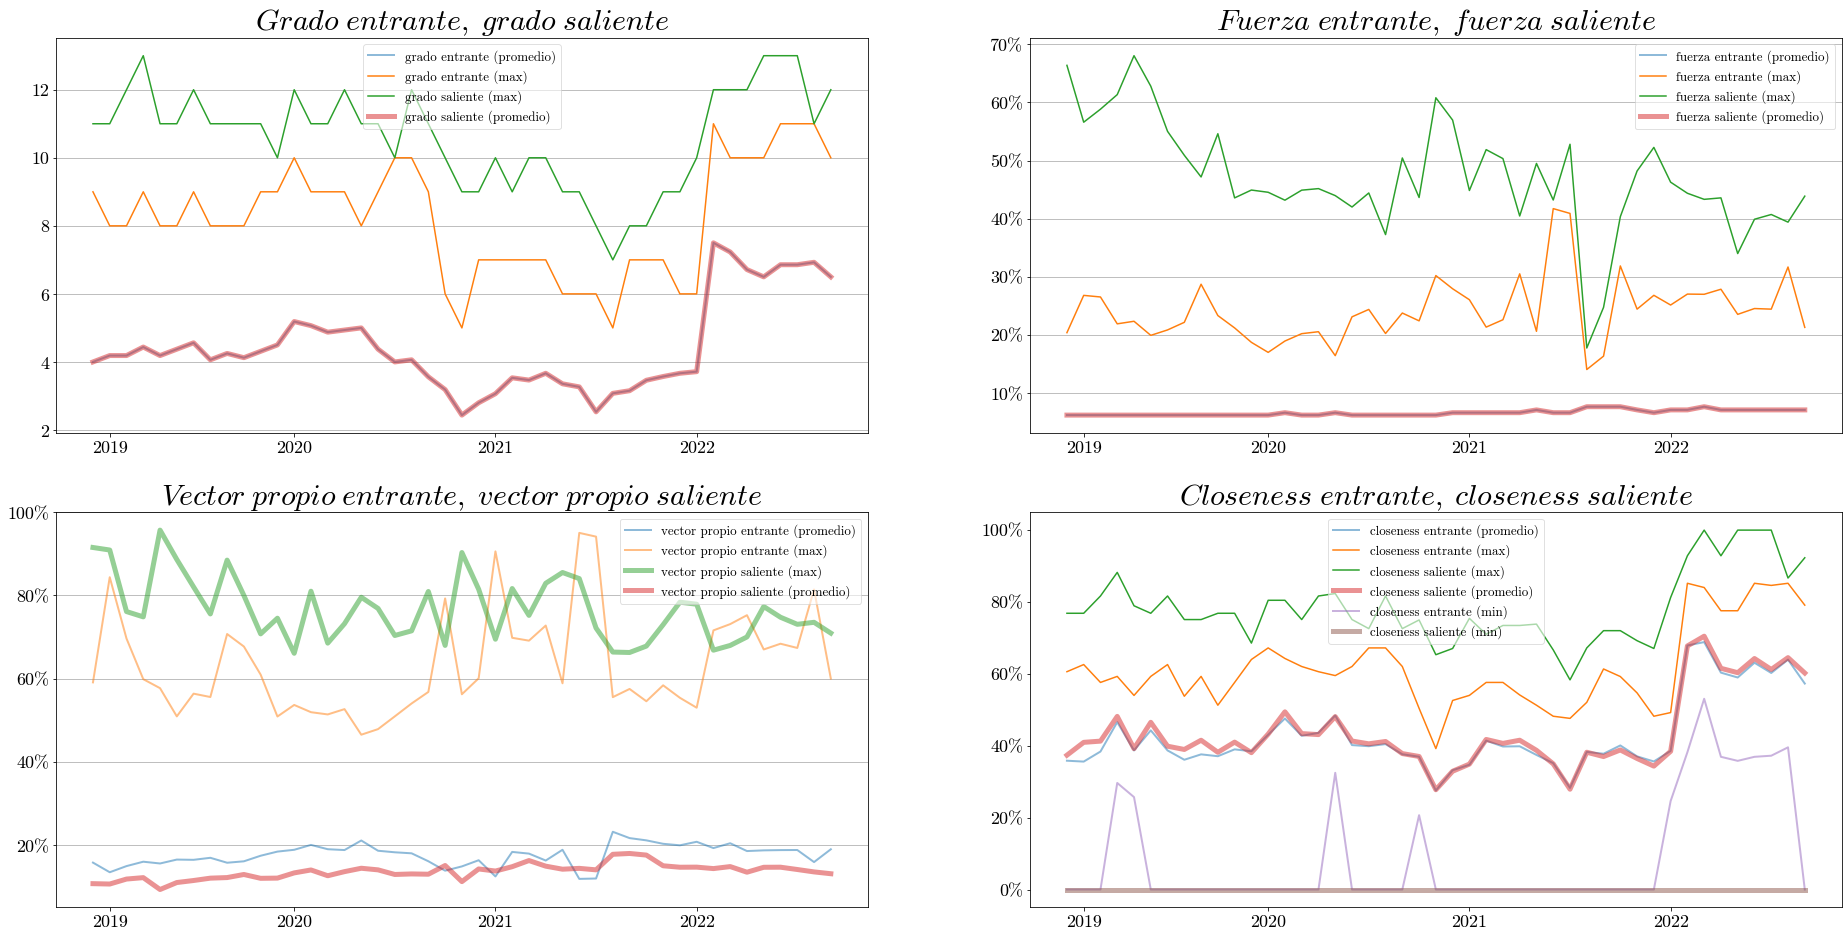

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (32, 16))

overlapping = 0.5


#grafo [0,0]

axs[0, 0].plot(d_indicadores_extra[f'df_grado_entrante_extras_t'][f'grado_entrante_prom'], alpha=overlapping, linewidth = 2)
axs[0, 0].plot(d_indicadores_extra[f'df_grado_entrante_extras_t'][f'grado_entrante_max'])
axs[0, 0].plot(d_indicadores_extra[f'df_grado_saliente_extras_t'][f'grado_saliente_max'])
axs[0, 0].plot(d_indicadores_extra[f'df_grado_saliente_extras_t'][f'grado_saliente_prom'], alpha=overlapping, linewidth = 5)


axs[0, 0].set_title(r'$Grado\;entrante,\;grado\;saliente$', fontdict = {'fontsize': 30})

    

#grid
plt.grid(axis = 'y')

axs[0, 0].set_xticks([1, 12, 24, 36], minor=False)
axs[0, 0].set_xticklabels(['2019','2020','2021','2022'])

axs[0, 0].grid(axis='y')

axs[0, 0].legend(['grado entrante (promedio)', 'grado entrante (max)', 'grado saliente (max)', 'grado saliente (promedio)'], fontsize = 13, framealpha = 0.6)
axs[0, 0].tick_params(axis='both', which='major', labelsize = 18)

#grafo [0,1]

axs[0, 1].plot(d_indicadores_extra[f'df_fuerza_entrante_extras_t'][f'fuerza_entrante_prom'], alpha=overlapping, linewidth = 2)
axs[0, 1].plot(d_indicadores_extra[f'df_fuerza_entrante_extras_t'][f'fuerza_entrante_max'])
axs[0, 1].plot(d_indicadores_extra[f'df_fuerza_saliente_extras_t'][f'fuerza_saliente_max'])
axs[0, 1].plot(d_indicadores_extra[f'df_fuerza_saliente_extras_t'][f'fuerza_saliente_prom'], alpha=overlapping, linewidth = 5)


axs[0, 1].set_title(r'$Fuerza\;entrante,\;fuerza\;saliente$', fontdict = {'fontsize': 30})

axs[0, 1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


axs[0, 1].set_xticks([1, 12, 24, 36], minor=False)
axs[0, 1].set_xticklabels(['2019','2020','2021','2022'])
axs[0, 1].tick_params(axis='both', which='major', labelsize = 18)
axs[0, 1].grid(axis='y')

axs[0, 1].legend(['fuerza entrante (promedio)', 'fuerza entrante (max)', 'fuerza saliente (max)', 'fuerza saliente (promedio)'], fontsize = 13, framealpha = 0.6)

#grafo [1,0]

axs[1, 0].plot(d_indicadores_extra[f'df_vector_propio_entrante_w_extras_t'][f'vector_propio_entrante_w_prom'], alpha=overlapping, linewidth = 2)
axs[1, 0].plot(d_indicadores_extra[f'df_vector_propio_entrante_w_extras_t'][f'vector_propio_entrante_w_max'], alpha=overlapping, linewidth = 2)
axs[1, 0].plot(d_indicadores_extra[f'df_vector_propio_saliente_w_extras_t'][f'vector_propio_saliente_w_max'], alpha=overlapping, linewidth = 5)
axs[1, 0].plot(d_indicadores_extra[f'df_vector_propio_saliente_w_extras_t'][f'vector_propio_saliente_w_prom'], alpha=overlapping, linewidth = 5)


axs[1, 0].set_title(r'$Vector\;propio\;entrante,\;vector\;propio\;saliente$', fontdict = {'fontsize': 30})

axs[1, 0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


axs[1, 0].set_xticks([1, 12, 24, 36], minor=False)
axs[1, 0].set_xticklabels(['2019','2020','2021','2022'])
axs[1, 0].tick_params(axis='both', which='major', labelsize = 18)
axs[1, 0].grid(axis='y')

axs[1, 0].legend(['vector propio entrante (promedio)', 'vector propio entrante (max)', 'vector propio saliente (max)', 'vector propio saliente (promedio)'], fontsize = 13, framealpha = 0.6)


#grafo [1,1]

axs[1, 1].plot(d_indicadores_extra[f'df_closeness_entrante_extras_t'][f'closeness_entrante_prom'], alpha=overlapping, linewidth = 2)
axs[1, 1].plot(d_indicadores_extra[f'df_closeness_entrante_extras_t'][f'closeness_entrante_max'])
axs[1, 1].plot(d_indicadores_extra[f'df_closeness_saliente_extras_t'][f'closeness_saliente_max'])
axs[1, 1].plot(d_indicadores_extra[f'df_closeness_saliente_extras_t'][f'closeness_saliente_prom'], alpha=overlapping, linewidth = 5)
axs[1, 1].plot(d_indicadores_extra[f'df_closeness_entrante_extras_t'][f'closeness_entrante_min'], alpha=overlapping, linewidth = 2)
axs[1, 1].plot(d_indicadores_extra[f'df_closeness_saliente_extras_t'][f'closeness_saliente_min'], alpha=overlapping, linewidth = 5)


axs[1, 1].set_title(r'$Closeness\;entrante,\;closeness\;saliente$', fontdict = {'fontsize': 30})

axs[1, 1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


axs[1, 1].set_xticks([1, 12, 24, 36], minor=False)
axs[1, 1].set_xticklabels(['2019','2020','2021','2022'])
axs[1, 1].tick_params(axis='both', which='major', labelsize = 18)
axs[1, 1].grid(axis='y')

axs[1, 1].legend(['closeness entrante (promedio)', 'closeness entrante (max)', 'closeness saliente (max)', 'closeness saliente (promedio)', 'closeness entrante (min)', 'closeness saliente (min)'], fontsize = 13, framealpha = 0.6)

if d_descargas_figuras == 'Y':
  plt.savefig(f"2. subplot_2.pdf")
  files.download(f"2. subplot_2.pdf") 


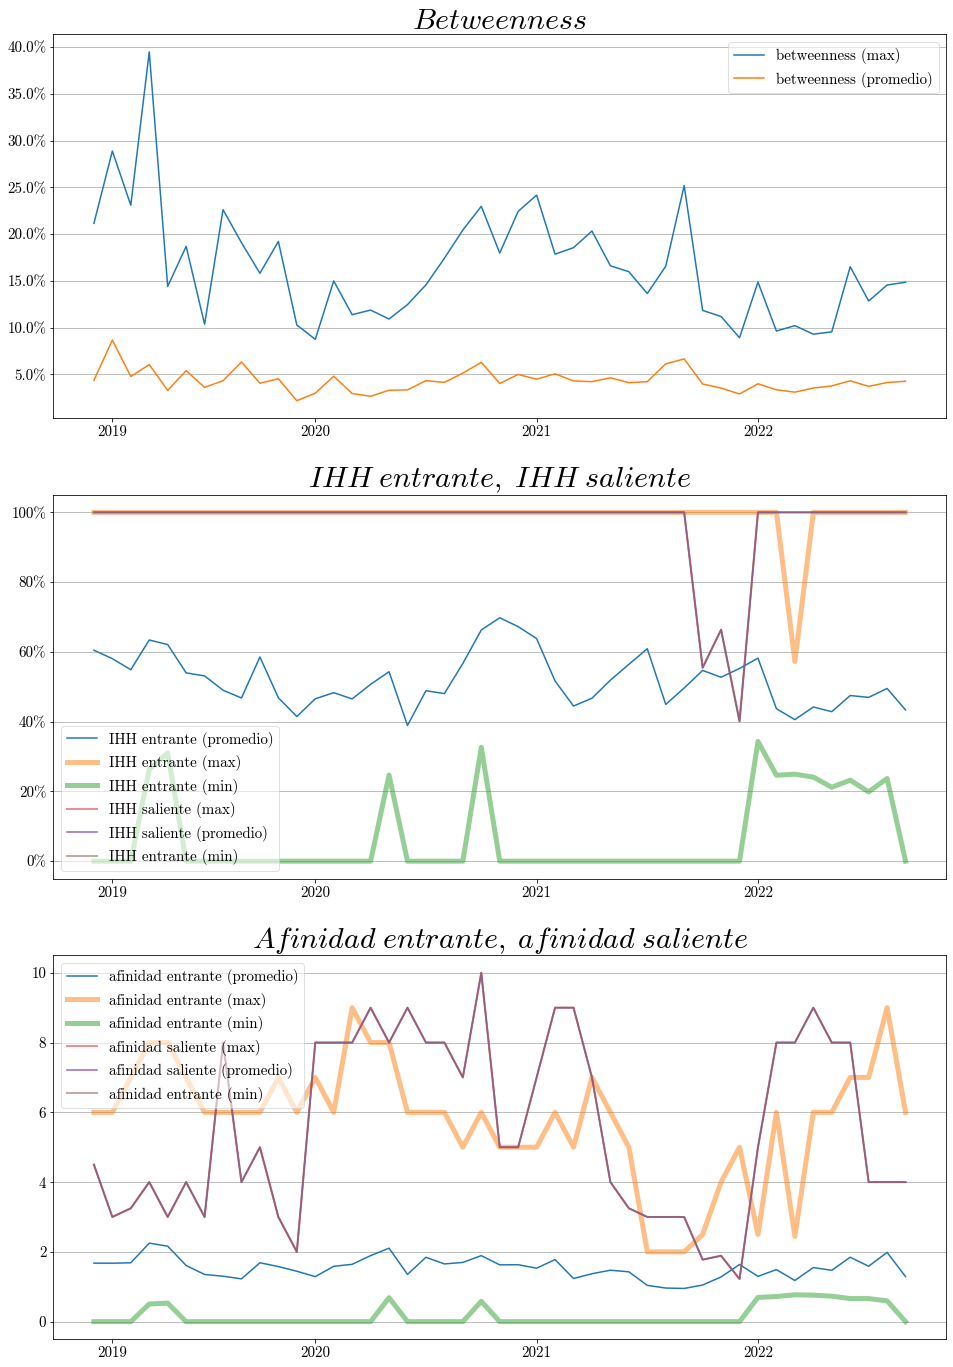

In [ ]:
fig, (ax_a, ax_b, ax_c) = plt.subplots(3, figsize=(16, 24))




ax_a.plot(d_indicadores_extra[f'df_betweenness_extras_t'][f'betweenness_max'].index,
        d_indicadores_extra[f'df_betweenness_extras_t'][f'betweenness_max'])
ax_a.plot(d_indicadores_extra[f'df_betweenness_extras_t'][f'betweenness_prom'].index,
        d_indicadores_extra[f'df_betweenness_extras_t'][f'betweenness_prom'], 
        )



ax_a.set_title(r'$Betweenness$', fontdict = {'fontsize': 30})

ax_a.set_xticks([1, 12, 24, 36], minor=False)
ax_a.set_xticklabels(['2019','2020','2021','2022'])
ax_a.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


ax_a.tick_params(axis='both', which='major', labelsize=15)

ax_a.legend(['betweenness (max)', 'betweenness (promedio)'], fontsize = 15, framealpha = 0.6)

#below 1
ax_b.plot(d_indicadores_extra[f'df_IHH_entrante_extras_t'][f'IHH_entrante_prom'].index,
        d_indicadores_extra[f'df_IHH_entrante_extras_t'][f'IHH_entrante_prom'])
ax_b.plot(d_indicadores_extra[f'df_IHH_entrante_extras_t'][f'IHH_entrante_max'].index,
        d_indicadores_extra[f'df_IHH_entrante_extras_t'][f'IHH_entrante_max'], 
         alpha=overlapping, linewidth = 5)
ax_b.plot(d_indicadores_extra[f'df_IHH_entrante_extras_t'][f'IHH_entrante_min'].index,
        d_indicadores_extra[f'df_IHH_entrante_extras_t'][f'IHH_entrante_min'], 
         alpha=overlapping, linewidth = 5)



ax_b.plot(d_indicadores_extra[f'df_IHH_saliente_extras_t'][f'IHH_saliente_max'].index,
        d_indicadores_extra[f'df_IHH_saliente_extras_t'][f'IHH_saliente_max'], 
         alpha=overlapping, linewidth = 2)
ax_b.plot(d_indicadores_extra[f'df_IHH_saliente_extras_t'][f'IHH_saliente_prom'].index,
        d_indicadores_extra[f'df_IHH_saliente_extras_t'][f'IHH_saliente_max'], 
        )
ax_b.plot(d_indicadores_extra[f'df_IHH_saliente_extras_t'][f'IHH_saliente_min'].index,
        d_indicadores_extra[f'df_IHH_saliente_extras_t'][f'IHH_saliente_max'], 
         alpha=overlapping, linewidth = 2)






ax_b.set_title(r'$IHH\;entrante,\;IHH\;saliente$', fontdict = {'fontsize': 30})

ax_b.set_xticks([1, 12, 24, 36], minor=False)
ax_b.set_xticklabels(['2019','2020','2021','2022'])
ax_b.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


ax_b.tick_params(axis='both', which='major', labelsize=15)

ax_b.legend(['IHH entrante (promedio)', 'IHH entrante (max)', 'IHH entrante (min)', 'IHH saliente (max)', 'IHH saliente (promedio)', 'IHH entrante (min)'], fontsize = 15, framealpha = 0.6)


#below 2
ax_c.plot(d_indicadores_extra[f'df_afinidad_entrante_extras_t'][f'afinidad_entrante_prom'].index,
        d_indicadores_extra[f'df_afinidad_entrante_extras_t'][f'afinidad_entrante_prom'])
ax_c.plot(d_indicadores_extra[f'df_afinidad_entrante_extras_t'][f'afinidad_entrante_max'].index,
        d_indicadores_extra[f'df_afinidad_entrante_extras_t'][f'afinidad_entrante_max'], 
         alpha=overlapping, linewidth = 5)
ax_c.plot(d_indicadores_extra[f'df_afinidad_entrante_extras_t'][f'afinidad_entrante_min'].index,
        d_indicadores_extra[f'df_afinidad_entrante_extras_t'][f'afinidad_entrante_min'], 
         alpha=overlapping, linewidth = 5)



ax_c.plot(d_indicadores_extra[f'df_afinidad_saliente_extras_t'][f'afinidad_saliente_max'].index,
        d_indicadores_extra[f'df_afinidad_saliente_extras_t'][f'afinidad_saliente_max'], 
         alpha=overlapping, linewidth = 2)
ax_c.plot(d_indicadores_extra[f'df_afinidad_saliente_extras_t'][f'afinidad_saliente_prom'].index,
        d_indicadores_extra[f'df_afinidad_saliente_extras_t'][f'afinidad_saliente_max'], 
        )
ax_c.plot(d_indicadores_extra[f'df_afinidad_saliente_extras_t'][f'afinidad_saliente_min'].index,
        d_indicadores_extra[f'df_afinidad_saliente_extras_t'][f'afinidad_saliente_max'], 
         alpha=overlapping, linewidth = 2)






ax_c.set_title(r'$Afinidad\;entrante,\;afinidad\;saliente$', fontdict = {'fontsize': 30})

ax_c.set_xticks([1, 12, 24, 36], minor=False)
ax_c.set_xticklabels(['2019','2020','2021','2022'])


ax_c.tick_params(axis='both', which='major', labelsize=15)

ax_c.legend(['afinidad entrante (promedio)', 'afinidad entrante (max)', 'afinidad entrante (min)', 'afinidad saliente (max)', 'afinidad saliente (promedio)', 'afinidad entrante (min)'], fontsize = 15, framealpha = 0.6)


#grid
ax_a.grid(axis = 'y')
ax_b.grid(axis = 'y')
ax_c.grid(axis = 'y')

if d_descargas_figuras == 'Y':
  plt.savefig(f"3. subplot_3.pdf")
  files.download(f"3. subplot_3.pdf") 

Ex-gráficos (ahora en subplots)


In [ ]:

# tamaño figura
#plt.figure(dpi = 500)
    

#ya que los promedios se pueden traslapar, usamos parámetro alfa de "transparencia"
#overlapping = 0.5

#generamos gráficos de líneas para cada estadística



#d_indicadores_extra[f'df_grado_entrante_extras_t'][f'grado_entrante_prom'].plot(label = f'grado_entrante_prom', linestyle = 'solid', color = 'red', alpha=overlapping, linewidth = 2)

#d_indicadores_extra[f'df_grado_entrante_extras_t'][f'grado_entrante_max'].plot(label = f'grado_entrante_max', linestyle = 'solid')

#d_indicadores_extra[f'df_grado_saliente_extras_t'][f'grado_saliente_max'].plot(label = f'grado_saliente_max', linestyle = 'solid')

#d_indicadores_extra[f'df_grado_saliente_extras_t'][f'grado_saliente_prom'].plot(label = f'grado_saliente_prom', linestyle = 'solid', alpha=overlapping, linewidth = 5)


# título
#plt.title(f'Grado entrante, grado saliente', size = 30)
    
# nombre eje x
#plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15) 
#plt.yticks(size = 15)


#grid
#plt.grid(axis = 'y')
    
# leyenda
#plt.legend(['grado entrante (promedio)', 'grado entrante (max)', 'grado saliente (promedio)', 'grado saliente (max)'], fontsize = 13, framealpha = 0.6)

#if d_descargas_figuras == 'Y':
#  plt.savefig(f"9. grado_entrante_saliente.pdf")
#  files.download(f"9. grado_entrante_saliente.pdf") 

In [ ]:

# tamaño figura
#plt.figure(dpi = 500)
    

#ya que los promedios se pueden traslapar, usamos parámetro alfa de "transparencia"
#overlapping = 0.5

#generamos gráficos de líneas para cada estadística



#d_indicadores_extra[f'df_fuerza_entrante_extras_t'][f'fuerza_entrante_prom'].plot(label = f'fuerza_entrante_prom', linestyle = 'solid', color = 'red', alpha=overlapping, linewidth = 2)

#d_indicadores_extra[f'df_fuerza_entrante_extras_t'][f'fuerza_entrante_max'].plot(label = f'fuerza_entrante_max', linestyle = 'solid')

#d_indicadores_extra[f'df_fuerza_saliente_extras_t'][f'fuerza_saliente_max'].plot(label = f'fuerza_saliente_max', linestyle = 'solid')

#d_indicadores_extra[f'df_fuerza_saliente_extras_t'][f'fuerza_saliente_prom'].plot(label = f'fuerza_saliente_prom', linestyle = 'solid', alpha=overlapping, linewidth = 5)




# título
#plt.title(f'Fuerza entrante, fuerza saliente', size = 30)
    
# nombre eje x
#plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15) 
#plt.yticks(size = 15)

#plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

#grid
#plt.grid(axis = 'y')
    
# leyenda
#plt.legend(['fuerza entrante (promedio)', 'fuerza entrante (max)', 'fuerza saliente (max)', 'fuerza saliente (promedio)'], fontsize = 13, framealpha = 0.6)

#if d_descargas_figuras == 'Y':
#  plt.savefig(f"10. fuerza_entrante_saliente.pdf")
#  files.download(f"10. fuerza_entrante_saliente.pdf") 

In [ ]:

# tamaño figura
#plt.figure(dpi = 500)
    

#ya que los promedios se pueden traslapar, usamos parámetro alfa de "transparencia"
#overlapping = 0.5

#generamos gráficos de líneas para cada estadística



#d_indicadores_extra[f'df_vector_propio_entrante_w_extras_t'][f'vector_propio_entrante_w_prom'].plot(label = f'vector_propio_entrante_w_prom', linestyle = 'solid', color = 'red', alpha=overlapping, linewidth = 2)

#d_indicadores_extra[f'df_vector_propio_entrante_w_extras_t'][f'vector_propio_entrante_w_max'].plot(label = f'vector_propio_entrante_w_max', linestyle = 'solid', alpha=overlapping, linewidth = 2)

#d_indicadores_extra[f'df_vector_propio_saliente_w_extras_t'][f'vector_propio_saliente_w_max'].plot(label = f'vector_propio_saliente_w_max', linestyle = 'solid', alpha=overlapping, linewidth = 5)

#d_indicadores_extra[f'df_vector_propio_saliente_w_extras_t'][f'vector_propio_saliente_w_prom'].plot(label = f'vector_propio_saliente_w_prom', linestyle = 'solid', alpha=overlapping, linewidth = 5)


# título
#plt.title(f'Vector propio entrante, vector propio saliente', size = 30)
    
# nombre eje x
#plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15) 
#plt.yticks(size = 15)

#plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

#grid
#plt.grid(axis = 'y')
    
# leyenda
#plt.legend(['vector propio entrante (promedio)', 'vector propio entrante (max)', 'vector propio saliente (max)', 'vector propio saliente (promedio)'], fontsize = 13, framealpha = 0.6)

#if d_descargas_figuras == 'Y':
#  plt.savefig(f"11. vector_propio_entrante_saliente.pdf")
#  files.download(f"11. vector_propio_entrante_saliente.pdf") 

In [ ]:

# tamaño figura
#plt.figure(dpi = 500)
    

#ya que los promedios se pueden traslapar, usamos parámetro alfa de "transparencia"
#overlapping = 0.5

#generamos gráficos de líneas para cada estadística



#d_indicadores_extra[f'df_closeness_entrante_extras_t'][f'closeness_entrante_prom'].plot(label = f'closeness_entrante_prom', linestyle = 'solid', alpha=overlapping, linewidth = 2)

#d_indicadores_extra[f'df_closeness_entrante_extras_t'][f'closeness_entrante_max'].plot(label = f'closeness_entrante_max', linestyle = 'solid')

#d_indicadores_extra[f'df_closeness_entrante_extras_t'][f'closeness_entrante_min'].plot(label = f'closeness_entrante_min', linestyle = 'solid', alpha=overlapping, linewidth = 2)

#d_indicadores_extra[f'df_closeness_saliente_extras_t'][f'closeness_saliente_max'].plot(label = f'closeness_saliente_max', linestyle = 'solid')

#d_indicadores_extra[f'df_closeness_saliente_extras_t'][f'closeness_saliente_prom'].plot(label = f'closeness_saliente_prom', linestyle = 'solid', alpha=overlapping, linewidth = 5)

#d_indicadores_extra[f'df_closeness_saliente_extras_t'][f'closeness_saliente_min'].plot(label = f'closeness_saliente_min', linestyle = 'solid', alpha=overlapping, linewidth = 5)

# título
#plt.title(f'Closeness entrante, closeness saliente', size = 30)
    
# nombre eje x
#plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15) 
#plt.yticks(size = 15)

#plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

#grid
#plt.grid(axis = 'y')
    
# leyenda
#plt.legend(['closeness entrante (promedio)', 'closeness entrante (max)', 'closeness entrante (min)', 'closeness saliente (max)', 'closeness saliente (promedio)', 'closeness entrante (min)'], fontsize = 13, framealpha = 0.6)

#if d_descargas_figuras == 'Y':
#  plt.savefig(f"12. closeness_entrante_saliente.pdf")
#  files.download(f"12. closeness_entrante_saliente.pdf") 

In [ ]:

# tamaño figura
#plt.figure(dpi = 500)
    

#ya que los promedios se pueden traslapar, usamos parámetro alfa de "transparencia"
#overlapping = 0.5

#generamos gráficos de líneas para cada estadística



#d_indicadores_extra[f'df_betweenness_extras_t'][f'betweenness_prom'].plot(label = f'betweenness_prom', linestyle = 'solid')

#d_indicadores_extra[f'df_betweenness_extras_t'][f'betweenness_max'].plot(label = f'betweenness_max', linestyle = 'solid')

#d_indicadores_extra[f'df_betweenness_extras_t'][f'betweenness_min'].plot(label = f'betweenness_min', linestyle = 'solid')



# título
#plt.title(f'Betweenness', size = 30)
    
# nombre eje x
#plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15) 
#plt.yticks(size = 15)

#plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

#grid
#plt.grid(axis = 'y')
    
# leyenda
#plt.legend(['betweenness (promedio)', 'betweenness (max)', 'betweenness (min)'], fontsize = 13, framealpha = 0.6)

#if d_descargas_figuras == 'Y':
#  plt.savefig(f"13. betweenness_entrante_saliente.pdf")
#  files.download(f"13. betweenness_entrante_saliente.pdf") 

In [ ]:

# tamaño figura
#plt.figure(dpi = 500)
    

#ya que los promedios se pueden traslapar, usamos parámetro alfa de "transparencia"
#overlapping = 0.5

#generamos gráficos de líneas para cada estadística



#d_indicadores_extra[f'df_IHH_entrante_extras_t'][f'IHH_entrante_prom'].plot(label = f'IHH_entrante_prom', linestyle = 'solid')

#d_indicadores_extra[f'df_IHH_entrante_extras_t'][f'IHH_entrante_max'].plot(label = f'IHH_entrante_max', linestyle = 'solid', alpha=overlapping, linewidth = 5)

#d_indicadores_extra[f'df_IHH_entrante_extras_t'][f'IHH_entrante_min'].plot(label = f'IHH_entrante_min', linestyle = 'solid', alpha=overlapping, linewidth = 5)

#d_indicadores_extra[f'df_IHH_saliente_extras_t'][f'IHH_saliente_max'].plot(label = f'IHH_saliente_max', linestyle = 'solid', alpha=overlapping, linewidth = 2)

#d_indicadores_extra[f'df_IHH_saliente_extras_t'][f'IHH_saliente_prom'].plot(label = f'IHH_saliente_prom', linestyle = 'solid')

#d_indicadores_extra[f'df_IHH_saliente_extras_t'][f'IHH_saliente_min'].plot(label = f'IHH_saliente_min', linestyle = 'solid', alpha=overlapping, linewidth = 2)


# título
#plt.title(f'IHH entrante, IHH saliente', size = 30)
    
# nombre eje x
#plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15) 
#plt.yticks(size = 15)

#plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

#grid
#plt.grid(axis = 'y')
    
# leyenda
#plt.legend(['IHH entrante (promedio)', 'IHH entrante (max)', 'IHH entrante (min)', 'IHH saliente (max)', 'IHH saliente (promedio)', 'IHH entrante (min)'], fontsize = 13, framealpha = 0.6)

#if d_descargas_figuras == 'Y':
#  plt.savefig(f"14. IHH_entrante_saliente.pdf")
#  files.download(f"14. IHH_entrante_saliente.pdf") 

In [ ]:

# tamaño figura
#plt.figure(dpi = 500)
    

#ya que los promedios se pueden traslapar, usamos parámetro alfa de "transparencia"
#overlapping = 0.5

#generamos gráficos de líneas para cada estadística



#d_indicadores_extra[f'df_afinidad_entrante_extras_t'][f'afinidad_entrante_prom'].plot(label = f'afinidad_entrante_prom', linestyle = 'solid', alpha=overlapping, linewidth = 5)

#d_indicadores_extra[f'df_afinidad_entrante_extras_t'][f'afinidad_entrante_max'].plot(label = f'afinidad_entrante_max', linestyle = 'solid')

#d_indicadores_extra[f'df_afinidad_entrante_extras_t'][f'afinidad_entrante_min'].plot(label = f'afinidad_entrante_min', linestyle = 'solid', alpha=overlapping, linewidth = 5)

#d_indicadores_extra[f'df_afinidad_saliente_extras_t'][f'afinidad_saliente_max'].plot(label = f'afinidad_saliente_max', linestyle = 'solid', alpha=overlapping, linewidth = 2)

#d_indicadores_extra[f'df_afinidad_saliente_extras_t'][f'afinidad_saliente_prom'].plot(label = f'afinidad_saliente_prom', linestyle = 'solid')

#d_indicadores_extra[f'df_afinidad_saliente_extras_t'][f'afinidad_saliente_min'].plot(label = f'afinidad_saliente_min', linestyle = 'solid', alpha=overlapping, linewidth = 2)


# título
#plt.title(f'afinidad entrante, afinidad saliente', size = 30)
    
# nombre eje x
#plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15) 
#plt.yticks(size = 15)


#grid
#plt.grid(axis = 'y')
    
# leyenda
#plt.legend(['afinidad entrante (promedio)', 'afinidad entrante (max)', 'afinidad entrante (min)', 'afinidad saliente (max)', 'afinidad saliente (promedio)', 'afinidad entrante (min)'], fontsize = 13, framealpha = 0.6)

#if d_descargas_figuras == 'Y':
#  plt.savefig(f"15. afinidad_entrante_saliente.pdf")
#  files.download(f"15. afinidad_entrante_saliente.pdf") 

# **Outputs 5.4 (Modelo EVS)**

In [ ]:
d_exp_cred_inst_t = {}
for periodo in df_cap['periodo'].unique():
  df_exp_cred_inst_aux = pd.DataFrame(0, index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique(), columns = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique()).astype(float)
  for prestamista in d_exp_cred_t[f"d_mat_cred_{periodo}"].index:
    for deudor in d_exp_cred_t[f"d_mat_cred_{periodo}"].index:
      df_exp_cred_inst_aux.at[prestamista, deudor] = d_exp_cred_t[f"d_mat_cred_{periodo}"].at[prestamista, deudor] + d_exp_inst_t[f"d_mat_inst_{periodo}"].at[prestamista, deudor]
  df_exp_cred_inst_aux = df_exp_cred_inst_aux
  #df_exp_cred_inst_aux = df_exp_cred_inst_aux.add_prefix('banco_')
  d_exp_cred_inst_t[f"df_mat_cred_inst_{periodo}"] = df_exp_cred_inst_aux

In [ ]:
#simulaciones 1-n_bancos_t, solo credit shock

lgd = 1 #parámetro de pérdida (%) de los créditos entregados a bancos que quiebran

d_mat_cred_inst = {} #hacemos un diccionario que va a guardar todos los dataframe relevantes, para exposiciones por créditos interbancarios
for periodo in df_cap['periodo'].unique(): #iteramos sobre cada período del df de patrimonios efectivos (y no del de exposiciones), para que si no existen exposiciones en cierto período, que se reporte de todas formas esto
  for simulacion, n_banco in enumerate(df_cap[df_cap['periodo'] == periodo]['cod_01'].unique()): #armamos las simulaciones iterando sobre el banco que cae inicialmente, simulación el el número de simulación por período (va de 1 a n bancos), n_banco o trigger_bank es el código del banco que cae inicialmente en cada simulación
    trigger_bank = n_banco

    #primera iteración
    df_cap_sim = d_caps[f"d_cap_{periodo}"].copy() #para la iteración 0 (inicial), copiamos los patrimonios efectivos iniciales de cada banco en el mes correspondiente
    df_cap_sim.rename(columns={"PatEf": "cap0"}, inplace=True) #ponemos nombre a columnas
    df_caidos_sim = pd.DataFrame(np.zeros(len(df_cap[df_cap['periodo'] == periodo]['cod_01'])), columns = [f"iteracion_0"], index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique()) #creamos una matriz de bancos caídos (de dummies) y la poblamos con 0s para la iteración 0, para cada trigger_bank y cada mes

    #iteración 0
    df_cap_sim.at[trigger_bank, f'cap0'] = 0 #partimos haciendo quebrar al trigger bank -> capital = 0
    df_caidos_sim.at[trigger_bank, "iteracion_0"] = 1 #partimos haciendo quebrar al trigger bank -> dummy de quiebra = 1


    #iteraciones 1->n (n es el máximo posible de iteraciones) -> el número de iteraciones se corta en el período donde no hayan más quiebras adicionales
    for it in range(1,len(df_cap[df_cap['periodo'] == periodo]['cod_01'])):

      it_anterior = it - 1 #iteración anterior 
      it_anterior_anterior = it_anterior - 1 #una iteración antes de la anterior a la actual

      if it == 1: #la iteración 1 tiene un trato distinto a la 2,3,4,...,n
        df_cap_sim["cap1"] = df_cap_sim["cap0"].copy() #creamos un df de pat efectivo para la iteración actual a partir de la anterior, luego le haremos descuentos por los shocks de la iteración
        df_caidos_sim["iteracion_1"] = df_caidos_sim["iteracion_0"].copy() #lo mismo para el df de dummies de bancos caidos

        for bancos_it in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique(): #recorremos desde el primer al último banco, para cada simulación y mes
          if df_cap_sim.at[bancos_it, f'cap0'] > 0: #solo aplicamos shocks a bancos con capital positivo al inicio de la iteración 1 (o en la iteración 0)
            df_cap_sim.at[bancos_it, f'cap1'] = df_cap_sim.at[bancos_it, f'cap{it_anterior}'] - lgd*d_exp_cred_inst_t[f"df_mat_cred_inst_{periodo}"][bancos_it][trigger_bank] #primera iteración -> hacemos caer el capital de todos los bancos en los préstamos interbancarios del trigger bank hacia ellos
          if df_cap_sim.at[bancos_it, f'cap1'] < 0: #llenamos con 1s a los bancos que cayeron en la iteración actual, OJO -> caen los con capital <0 y no <=0 para evitar que bancos que inicialmente tenían capital = 0 aparezcan como caídos
            df_caidos_sim.at[bancos_it, f"iteracion_{it}"] = 1 #llenamos el df de bancos caídos acumulados con los que cayeron en la iteración 1 

        total_bancos_caidos = df_caidos_sim[f"iteracion_{it}"].sum()  #acumulamos el total de bancos caídos


      elif it > 1:
        df_caidos_sim[f"iteracion_{it}"] = df_caidos_sim[f"iteracion_{it_anterior}"]
        if df_caidos_sim[f"iteracion_{it_anterior}"].sum() != df_caidos_sim[f"iteracion_{it_anterior_anterior}"].sum(): #si quiebra otro banco luego de la iteración anterior
          for bancos in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique(): #iteramos desde 0 al último banco
            if df_caidos_sim.at[bancos, f"iteracion_{it_anterior}"] != df_caidos_sim.at[bancos, f"iteracion_{it_anterior_anterior}"]: #corre solo para bancos que cayeron en la iteración anterior
              banco_caido_it_anterior = bancos #identificamos a los bancos que cayeron en la iteración anterior
              for bancos_it in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique(): #para todos los bancos
                if df_cap_sim.at[bancos_it, f'cap{it_anterior}'] > 0: #solo aplicamos shocks a bancos con capital positivo al inicio de cada iteración (o en la iteración anterior)
                  df_cap_sim.at[bancos_it, f'cap{it}'] = df_cap_sim.at[bancos_it, f'cap{it_anterior}'] - lgd*d_exp_cred_inst_t[f"df_mat_cred_inst_{periodo}"][bancos_it][banco_caido_it_anterior] #descuento por shock de caídos en la iteración anterior
                if df_cap_sim.at[bancos_it, f'cap{it_anterior}'] < 0:
                  df_cap_sim.at[bancos_it, f'cap{it}'] = df_cap_sim.at[bancos_it, f'cap{it_anterior}']


          for bancos in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique():
            if df_cap_sim.at[bancos, f'cap{it}'] < 0 and df_caidos_sim.at[bancos, f"iteracion_{it_anterior}"] != 1:
              df_caidos_sim.at[bancos, f"iteracion_{it}"] = 1 #llenamos el df de bancos caídos acumulados con los que cayeron en la iteración actual, si no hay caídos, no se define el df
            
          total_bancos_caidos = df_caidos_sim[f"iteracion_{it}"].sum()  
      
        else:
            total_bancos_caidos = df_caidos_sim[f"iteracion_{it_anterior}"].sum()
            break
            
      if total_bancos_caidos !=1: #alerta de períodos en los que se producen contagio (actualmente contagio significa que el shock de crédito inicial sea mayor al patrimonio efectivo -> prácticamente imposible)
        print(f"Ojo, en el período: {periodo}, cuando cae inicialmente el banco: {trigger_bank} hubo contagios a {int(total_bancos_caidos - 1)} banco(s) adicional(es)")

  


    d_mat_cred_inst[f"cap_sim{trigger_bank}_{periodo}_c"] = df_cap_sim #guardamos el df de capitales de bancos según iteraciones para cada simulación
    d_mat_cred_inst[f"cap_caidos{trigger_bank}_{periodo}_c"] = df_caidos_sim #guardamos el df de bancos caídos acumulados según iteraciones para cada simulación
    d_mat_cred_inst[f"cap_caidos{trigger_bank}_{periodo}_c"].fillna(value=0, inplace=True)

In [ ]:
#creación de matriz de pérdidas porcentuales de patrimonio efectivo
#for simulacion, n_banco in enumerate(df_cap[df_cap['periodo'] == periodo]['cod_01'].unique()):

for periodo in df_cap['periodo'].unique():
  for trigger_bank in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique(): #recorremos todas las simulaciones
    d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"] = pd.DataFrame(np.zeros(len(df_cap[df_cap['periodo'] == periodo]['cod_01'])), columns = ["iteracion_0"], index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique()) #creamos una matriz de acumulación de pérdidas porcentuales acumuladas de patrimonio efectivo
    d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"].at[trigger_bank, 'iteracion_0'] = 1
    for iteraciones in range(1, len(d_mat_cred_inst[f"cap_sim{simulacion + 1}_{periodo}_c"].columns)):
      #d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"][f"iteracion_{iteraciones}"] = d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"][f"iteracion_{iteraciones - 1}"].copy()
      d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"][f"iteracion_{iteraciones}"] = -((d_mat_cred_inst[f"cap_sim{trigger_bank}_{periodo}_c"][f'cap{iteraciones}'] - d_mat_cred_inst[f"cap_sim{trigger_bank}_{periodo}_c"]["cap0"]) / d_mat_cred_inst[f"cap_sim{trigger_bank}_{periodo}_c"]["cap0"])
      d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"][f"iteracion_{iteraciones}"] = d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"][f"iteracion_{iteraciones}"].fillna(0)
      

In [ ]:
#creamos dfs de contagio -> columna: deudor, fila: acreedor
d_contagios = {}
for periodo in df_cap['periodo'].unique():
  d_contagios[f'contagios_{periodo}'] = pd.DataFrame(index = list(df_cap[df_cap['periodo'] == periodo]['cod_01'].unique()))
  for banco in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique():
    d_contagios[f'contagios_{periodo}'][f'{banco}'] = list(d_mat_cred_inst[f'df_perdidas{banco}_{periodo}_c'].iloc[:, -1])


#creación de dfs de promedio y máximo de contagios
df_promedio_contagios = pd.DataFrame(index = df_cap['periodo'].unique(), columns = ['promedio_total_contagios'])
df_max_contagios = pd.DataFrame(index = df_cap['periodo'].unique(), columns = ['max_contagios'])

for periodo in df_cap['periodo'].unique():
  df_promedio_contagios.at[periodo, 'promedio_total_contagios'] = d_contagios[f'contagios_{periodo}'].to_numpy().mean()
  df_max_contagios.at[periodo, 'max_contagios'] = d_contagios[f'contagios_{periodo}'].to_numpy().max()

#pasamos los periodos a un formato de fecha
df_max_contagios.index = df_max_contagios.index.map(str)
for indexes, fecha in enumerate(df_max_contagios.index):
  datetime.strptime(df_max_contagios.index[indexes], '%Y%m')

In [ ]:
#contagion index

d_contagion_cred_inst = {} #diccionario que va a guardar los siguientes dfs...

for periodo in df_cap['periodo'].unique(): #creamos dfs de mínimo, promedio y máximo de contagion index (pérdida en % de pat. efectivo que genera la caída de cada trigger bank) para cada período
  d_contagion_cred_inst[f'df_contagion_index_{periodo}_cred_inst'] = pd.DataFrame(np.zeros(len(df_cap[df_cap['periodo'] == periodo]['cod_01'])), columns = ['contagion_index (promedio)'], index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique())
  d_contagion_cred_inst[f'df_contagion_max_{periodo}_cred_inst'] = pd.DataFrame(np.zeros(len(df_cap[df_cap['periodo'] == periodo]['cod_01'])), columns = ['contagion_max'], index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique())
  d_contagion_cred_inst[f'df_contagion_min_{periodo}_cred_inst'] = pd.DataFrame(np.zeros(len(df_cap[df_cap['periodo'] == periodo]['cod_01'])), columns = ['contagion_min'], index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique())

  for trigger_bank in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique():
    d_contagion_cred_inst[f'df_contagion_index_{periodo}_cred_inst'].at[trigger_bank, "contagion_index (promedio)"] = (d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"].iloc[:, -1].sum() - d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"].iloc[:,[-1]].loc[trigger_bank].values[0]) / (d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"].shape[0] - 1)
    d_contagion_cred_inst[f'df_contagion_max_{periodo}_cred_inst'].at[trigger_bank, "contagion_max"] = d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"].iloc[:, -1].max()
    d_contagion_cred_inst[f'df_contagion_min_{periodo}_cred_inst'].at[trigger_bank, "contagion_min"] = d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"].iloc[:, -1].min()


  #arreglo previo de dfs para graficar...
  d_contagion_cred_inst[f'df_contagion_index_{periodo}_cred_inst'] = d_contagion_cred_inst[f'df_contagion_index_{periodo}_cred_inst']["contagion_index (promedio)"].add_prefix('banco_')
  d_contagion_cred_inst[f'df_contagion_index_{periodo}_cred_inst'] = d_contagion_cred_inst[f'df_contagion_index_{periodo}_cred_inst'].to_frame()
  d_contagion_cred_inst[f'df_contagion_max_{periodo}_cred_inst'] = d_contagion_cred_inst[f'df_contagion_max_{periodo}_cred_inst']["contagion_max"].add_prefix('banco_')
  d_contagion_cred_inst[f'df_contagion_max_{periodo}_cred_inst'] = d_contagion_cred_inst[f'df_contagion_max_{periodo}_cred_inst'].to_frame()
  d_contagion_cred_inst[f'df_contagion_min_{periodo}_cred_inst'] = d_contagion_cred_inst[f'df_contagion_min_{periodo}_cred_inst']["contagion_min"].add_prefix('banco_')
  d_contagion_cred_inst[f'df_contagion_min_{periodo}_cred_inst'] = d_contagion_cred_inst[f'df_contagion_min_{periodo}_cred_inst'].to_frame()


In [ ]:
#creación de dfs necesarios para gráfico contagios máximos
d_contagion_max_cred_inst_bancos = {}

for bancos in df_cap['cod_01'].unique():
  d_contagion_max_cred_inst_bancos[f'lista_contagion_{bancos}'] = []
  for periodo in df_cap['periodo'].unique():
    if f'banco_{bancos}' in d_contagion_cred_inst[f'df_contagion_max_{periodo}_cred_inst'].index:
      d_contagion_max_cred_inst_bancos[f'lista_contagion_{bancos}'].append(d_contagion_cred_inst[f'df_contagion_max_{periodo}_cred_inst'].at[f'banco_{bancos}', 'contagion_max'])
    else:
      d_contagion_max_cred_inst_bancos[f'lista_contagion_{bancos}'].append(0)

df_contagion_max_cred_inst_t = pd.DataFrame(np.zeros((len(df_cap['periodo'].unique()), len(df_cap['cod_01'].unique()))), columns = df_cap['cod_01'].unique(), index = df_cap['periodo'].unique())
df_contagion_max_cred_inst_t = df_contagion_max_cred_inst_t.add_prefix('banco_')

for bancos in df_cap['cod_01'].unique():
  df_contagion_max_cred_inst_t[f'banco_{bancos}'] = d_contagion_max_cred_inst_bancos[f'lista_contagion_{bancos}']

#pasamos los periodos a un formato de fecha
df_contagion_max_cred_inst_t.index = df_contagion_max_cred_inst_t.index.map(str)
for indexes, fecha in enumerate(df_contagion_max_cred_inst_t.index):
  datetime.strptime(df_contagion_max_cred_inst_t.index[indexes], '%Y%m')


In [ ]:
#vulnerability index, credit

d_vulnerability_cred_inst = {}

for periodo in df_cap['periodo'].unique():

#creamos dfs donde vamos a guardar el promedio, mínimo y máximo respectivamente de los índices de vulnerabilidad (% de pérdidas de pat. efectivo de cada banco a lo largo de las simulaciones)
  d_vulnerability_cred_inst[f'df_vulnerability_index_{periodo}_cred_inst'] = pd.DataFrame(np.zeros(len(df_cap[df_cap['periodo'] == periodo]['cod_01'])), columns = ["vulnerability_index (promedio)"], index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique())
  d_vulnerability_cred_inst[f'df_vulnerability_max_{periodo}_cred_inst'] = pd.DataFrame(np.zeros(len(df_cap[df_cap['periodo'] == periodo]['cod_01'])), columns = ["vulnerability_max"], index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique())
  d_vulnerability_cred_inst[f'df_vulnerability_min_{periodo}_cred_inst'] = pd.DataFrame(np.zeros(len(df_cap[df_cap['periodo'] == periodo]['cod_01'])), columns = ["vulnerability_min"], index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique())
  d_vulnerability_cred_inst[f'df_vulnerability_suma_{periodo}_cred_inst'] = pd.DataFrame(np.zeros(len(df_cap[df_cap['periodo'] == periodo]['cod_01'])), columns = ["vulnerability_suma"], index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique())


  for banco_i in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique(): #iteramos para cada banco

    acum_vul = 0 #variables que van a acumular vulnerabilidad, su mínimo y máximo, respectivamente
    vul_min = 0
    vul_max = 0 

    for trigger_bank in df_cap[df_cap['periodo'] == periodo]['cod_01'].unique(): #para cada banco iteramos sobre todas las simulaciones
      if trigger_bank != banco_i:
        acum_vul = acum_vul + d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"].iloc[:,[-1]].loc[banco_i] #vamos haciendo una suma acumulada de las pérdidas de cada banco a lo largo de las simulaciones
      if vul_max < d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"].iloc[:,[-1]].loc[banco_i].values[0]: #vamos buscando la máxima pérdida del banco a lo largo de las simulaciones
        vul_max = d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"].iloc[:,[-1]].loc[banco_i].values[0]
      if trigger_bank != banco_i and vul_min > d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"].iloc[:,[-1]].loc[banco_i].values[0]:
        vul_min = d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"].iloc[:,[-1]].loc[banco_i].values[0]
        
    d_vulnerability_cred_inst[f'df_vulnerability_index_{periodo}_cred_inst'].at[banco_i, "vulnerability_index (promedio)"] = acum_vul/(d_mat_cred_inst[f"df_perdidas{trigger_bank}_{periodo}_c"].shape[0] - 1)
    d_vulnerability_cred_inst[f'df_vulnerability_max_{periodo}_cred_inst'].at[banco_i, "vulnerability_max"] = vul_max
    d_vulnerability_cred_inst[f'df_vulnerability_min_{periodo}_cred_inst'].at[banco_i, "vulnerability_min"] = vul_min
    d_vulnerability_cred_inst[f'df_vulnerability_suma_{periodo}_cred_inst'].at[banco_i, "vulnerability_suma"] = acum_vul

  #arreglo previo de dfs para graficar...
  d_vulnerability_cred_inst[f'df_vulnerability_index_{periodo}_cred_inst'] = d_vulnerability_cred_inst[f'df_vulnerability_index_{periodo}_cred_inst']["vulnerability_index (promedio)"].add_prefix('banco_')
  d_vulnerability_cred_inst[f'df_vulnerability_index_{periodo}_cred_inst'] = d_vulnerability_cred_inst[f'df_vulnerability_index_{periodo}_cred_inst'].to_frame()
  d_vulnerability_cred_inst[f'df_vulnerability_max_{periodo}_cred_inst'] = d_vulnerability_cred_inst[f'df_vulnerability_max_{periodo}_cred_inst']["vulnerability_max"].add_prefix('banco_')
  d_vulnerability_cred_inst[f'df_vulnerability_max_{periodo}_cred_inst'] = d_vulnerability_cred_inst[f'df_vulnerability_max_{periodo}_cred_inst'].to_frame()
  d_vulnerability_cred_inst[f'df_vulnerability_min_{periodo}_cred_inst'] = d_vulnerability_cred_inst[f'df_vulnerability_min_{periodo}_cred_inst']["vulnerability_min"].add_prefix('banco_')
  d_vulnerability_cred_inst[f'df_vulnerability_min_{periodo}_cred_inst'] = d_vulnerability_cred_inst[f'df_vulnerability_min_{periodo}_cred_inst'].to_frame()
  d_vulnerability_cred_inst[f'df_vulnerability_suma_{periodo}_cred_inst'] = d_vulnerability_cred_inst[f'df_vulnerability_suma_{periodo}_cred_inst']["vulnerability_suma"].add_prefix('banco_')
  d_vulnerability_cred_inst[f'df_vulnerability_suma_{periodo}_cred_inst'] = d_vulnerability_cred_inst[f'df_vulnerability_suma_{periodo}_cred_inst'].to_frame()

In [ ]:
#creación de dfs necesarios para gráfico máximo vulnerabilidad
d_vulnerability_max_cred_inst_bancos = {}

for bancos in df_cap['cod_01'].unique():
  d_vulnerability_max_cred_inst_bancos[f'lista_vulnerability_{bancos}'] = []
  for periodo in df_cap['periodo'].unique():
    if f'banco_{bancos}' in d_vulnerability_cred_inst[f'df_vulnerability_max_{periodo}_cred_inst'].index:
      d_vulnerability_max_cred_inst_bancos[f'lista_vulnerability_{bancos}'].append(d_vulnerability_cred_inst[f'df_vulnerability_max_{periodo}_cred_inst'].at[f'banco_{bancos}', 'vulnerability_max'])
    else:
      d_vulnerability_max_cred_inst_bancos[f'lista_vulnerability_{bancos}'].append(0)

df_vulnerability_max_cred_inst_t = pd.DataFrame(np.zeros((len(df_cap['periodo'].unique()), len(df_cap['cod_01'].unique()))), columns = df_cap['cod_01'].unique(), index = df_cap['periodo'].unique())
df_vulnerability_max_cred_inst_t = df_vulnerability_max_cred_inst_t.add_prefix('banco_')

for bancos in df_cap['cod_01'].unique():
  df_vulnerability_max_cred_inst_t[f'banco_{bancos}'] = d_vulnerability_max_cred_inst_bancos[f'lista_vulnerability_{bancos}']

#pasamos los periodos a un formato de fecha
df_vulnerability_max_cred_inst_t.index = df_vulnerability_max_cred_inst_t.index.map(str)
for indexes, fecha in enumerate(df_vulnerability_max_cred_inst_t.index):
  datetime.strptime(df_vulnerability_max_cred_inst_t.index[indexes], '%Y%m')


In [ ]:
#gráfico máximo contagio


#ya que los promedios se pueden traslapar, usamos parámetro alfa de "transparencia"
#overlapping = 0.5

#generamos gráficos de líneas para cada estadística

#df_max_contagios.plot(label = f'max_mensual_bancos', linestyle = 'solid', alpha=overlapping, linewidth = 7)

#df_contagion_max_cred_inst_t[f'banco_18'].plot(label = 'max_mensual_banco_18', linestyle = 'solid')

#df_contagion_max_cred_inst_t[f'banco_6'].plot(label = 'max_mensual_banco_6', linestyle = 'solid')

#df_contagion_max_cred_inst_t[f'banco_3'].plot(label = 'max_mensual_banco_3', linestyle = 'solid')



# título
#plt.title(r'$M\acute{a}ximo\;indice\; de\; contagio$', size = 30)
  
# nombre eje x
#plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15) 
#plt.yticks(size = 15)

#valores como %
#plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


#grid
#plt.grid(axis = 'y')

# leyenda
#plt.legend(['max contagio sistema', 'max contagio banco 18', 'max contagio banco 6', 'max contagio banco 3'], fontsize = 13, framealpha = 0.6)

#if d_descargas_figuras == 'Y':
#  plt.savefig(f"16. max_contagio.pdf")
#  files.download(f"16. max_contagio.pdf")   

In [ ]:
#gráfico máximo vulnerabilidad


#ya que los promedios se pueden traslapar, usamos parámetro alfa de "transparencia"
#overlapping = 0.5

#generamos gráficos de líneas para cada estadística

#df_max_contagios.plot(label = f'max_mensual_bancos', linestyle = 'solid', alpha=overlapping, linewidth = 7)

#df_vulnerability_max_cred_inst_t[f'banco_23'].plot(label = 'max_mensual_banco_18', linestyle = 'solid')

#df_vulnerability_max_cred_inst_t[f'banco_5'].plot(label = 'max_mensual_banco_6', linestyle = 'solid')

#df_vulnerability_max_cred_inst_t[f'banco_6'].plot(label = 'max_mensual_banco_3', linestyle = 'solid')



# título
#plt.title('Maximo indice de vulnerabilidad', size = 30)
  
# nombre eje x
#plt.xticks([1, 12, 24, 36], ['2019','2020','2021','2022'], size = 15) 
#plt.yticks(size = 15)

#valores como %
#plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


#grid
#plt.grid(axis = 'y')

# leyenda
#plt.legend(['max vulnerabilidad sistema', 'max vulnerabilidad banco 23', 'max vulnerabilidad banco 5', 'max vulnerabilidad banco 6'], fontsize = 13, framealpha = 0.6)

#if d_descargas_figuras == 'Y':
#  plt.savefig(f"17. max_vulnerabilidad.pdf")
#  files.download(f"17. max_vulnerabilidad.pdf")   

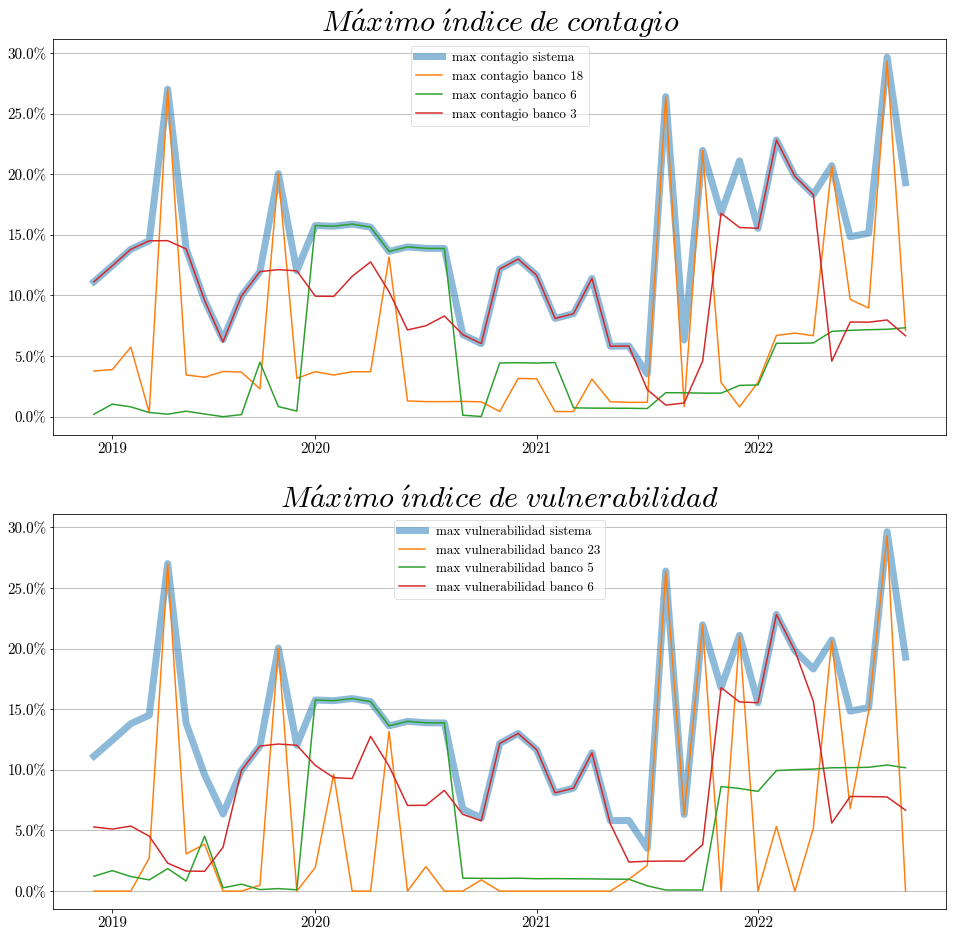

In [ ]:
fig, (ax_a, ax_b) = plt.subplots(2, figsize=(16, 16))


overlapping = 0.5

ax_a.plot(df_max_contagios.index,
        df_max_contagios, alpha=overlapping, linewidth = 7)
ax_a.plot(df_contagion_max_cred_inst_t[f'banco_18'].index,
        df_contagion_max_cred_inst_t[f'banco_18'], 
        )
ax_a.plot(df_contagion_max_cred_inst_t[f'banco_6'].index,
        df_contagion_max_cred_inst_t[f'banco_6'], 
        )
ax_a.plot(df_contagion_max_cred_inst_t[f'banco_3'].index,
        df_contagion_max_cred_inst_t[f'banco_3'], 
        )



ax_a.set_title(r'$M\acute{a}ximo\;\acute{\imath}ndice\;de\;contagio$', fontdict = {'fontsize': 30})

ax_a.set_xticks([1, 12, 24, 36], minor=False)
ax_a.set_xticklabels(['2019','2020','2021','2022'])
ax_a.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


ax_a.tick_params(axis='both', which='major', labelsize=15)

ax_a.legend(['max contagio sistema', 'max contagio banco 18', 'max contagio banco 6', 'max contagio banco 3'], fontsize = 13, framealpha = 0.6)

#below 1

ax_b.plot(df_max_contagios.index,
        df_max_contagios, alpha=overlapping, linewidth = 7)
ax_b.plot(df_vulnerability_max_cred_inst_t[f'banco_23'].index,
        df_vulnerability_max_cred_inst_t[f'banco_23'], 
        )
ax_b.plot(df_vulnerability_max_cred_inst_t[f'banco_5'].index,
        df_vulnerability_max_cred_inst_t[f'banco_5'], 
        )
ax_b.plot(df_vulnerability_max_cred_inst_t[f'banco_6'].index,
        df_vulnerability_max_cred_inst_t[f'banco_6'], 
        )



ax_b.set_title(r'$M\acute{a}ximo\;\acute{\imath}ndice\;de\;vulnerabilidad$', fontdict = {'fontsize': 30})

ax_b.set_xticks([1, 12, 24, 36], minor=False)
ax_b.set_xticklabels(['2019','2020','2021','2022'])
ax_b.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


ax_b.tick_params(axis='both', which='major', labelsize=15)

ax_b.legend(['max vulnerabilidad sistema', 'max vulnerabilidad banco 23', 'max vulnerabilidad banco 5', 'max vulnerabilidad banco 6'], fontsize = 13, framealpha = 0.6)

#grid
ax_a.grid(axis = 'y')
ax_b.grid(axis = 'y')


if d_descargas_figuras == 'Y':
  plt.savefig(f"4. subplot_4.pdf")
  files.download(f"4. subplot_4.pdf") 

# Apéndice

Tabla bancos destacados

In [ ]:
#bancos top out: bancos 3, 15, 18, 20, 21
#bancos top in: bancos 8, 24, 18, 19 y 15

bancos_top_out = ['banco_3', 'banco_15', 'banco_18', 'banco_20', 'banco_21']
bancos_top_in = ['banco_8', 'banco_24', 'banco_18', 'banco_19', 'banco_15']
bancos_top_in_out = ['banco_3', 'banco_15', 'banco_18', 'banco_20', 'banco_21', 'banco_8', 'banco_24', 'banco_19']
indicadores = lista_indicadores_locales

iterables_index = [bancos_top_in_out, indicadores] #hacemos multiíndices (banco, indicador)
index = pd.MultiIndex.from_product(iterables_index, names=["banco", "indicador"])

periodos_tabla = ['2019', '2020', '2021']
columnas_descriptivas = ['min', 'P25', 'prom', 'P50', 'P75', 'max', 'sd']
iterables_columns = [periodos_tabla, columnas_descriptivas] #hacemos multiíndices (año, estadístico)
columns = pd.MultiIndex.from_product(iterables_columns, names=["año", "stat"])

df_resumen_tops = pd.DataFrame(index = index, columns = columns) #creamos tablas con índices: (banco, indicador) y columnas: (año, estadístico)

for banco in bancos_top_in_out: #recorremos todos los bancos
  d_aux_indicadores = {} #para cada banco definimos el mismo diccionario auxiliar

  for indicador in indicadores: #recorremos todas los indicadores locales para cada banco
    for year in periodos_tabla: #recorremos los años 2019, 2020, 2021 
      d_aux_indicadores[f'lista_aux_{indicador}'] = [] #lista que guarda cada indicador en el tiempo para cada año y cada banco
      for periodo in df_cap['periodo'].unique(): #recorremos todos los periodos
        if year == str(periodo)[0:4]: #solo consideramos los periodos pertenecientes al año de interés
          if banco in d_metricas_f1[f'df_metricas_cred_inst_f1_{periodo}'].index: #llenamos con la métrica del banco en el período para el indicador si es que el banco fue nodo (participó en exposiciones)
            d_aux_indicadores[f'lista_aux_{indicador}'].append(d_metricas_f1[f'df_metricas_cred_inst_f1_{periodo}'].at[banco, f'{indicador}'])
      d_aux_indicadores[f'lista_aux_{indicador}'] = np.array(d_aux_indicadores[f'lista_aux_{indicador}']) #tenemos un array con los valores del indicador para el banco en el año de interés

      #rellenado de estadísticos
      df_resumen_tops.loc[(f'{banco}', f'{indicador}'), (f'{year}', 'min')] = d_aux_indicadores[f'lista_aux_{indicador}'].min()
      df_resumen_tops.loc[(f'{banco}', f'{indicador}'), (f'{year}', 'P25')] = np.percentile(d_aux_indicadores[f'lista_aux_{indicador}'], 25)
      df_resumen_tops.loc[(f'{banco}', f'{indicador}'), (f'{year}', 'prom')] = d_aux_indicadores[f'lista_aux_{indicador}'].mean()
      df_resumen_tops.loc[(f'{banco}', f'{indicador}'), (f'{year}', 'P50')] = np.percentile(d_aux_indicadores[f'lista_aux_{indicador}'], 50)
      df_resumen_tops.loc[(f'{banco}', f'{indicador}'), (f'{year}', 'P75')] = np.percentile(d_aux_indicadores[f'lista_aux_{indicador}'], 75)
      df_resumen_tops.loc[(f'{banco}', f'{indicador}'), (f'{year}', 'max')] = d_aux_indicadores[f'lista_aux_{indicador}'].max()
      df_resumen_tops.loc[(f'{banco}', f'{indicador}'), (f'{year}', 'sd')] = d_aux_indicadores[f'lista_aux_{indicador}'].std()





if d_descargas_tablas == 'Y':
  writer = pd.ExcelWriter('hey.xlsx')
  df_resumen_tops.to_excel(writer)
  writer.save()
  files.download('hey.xlsx')


In [ ]:
df_resumen_tops

año                                    2019                                \
stat                                    min       P25      prom       P50   
banco    indicador                                                          
banco_3  IHH_saliente              0.154531  0.167925  0.175197     0.176   
         IHH_entrante              0.349784  0.416999  0.500574  0.491838   
         vector_propio_saliente_w  0.660987  0.747678  0.803038  0.780536   
         vector_propio_entrante_w  0.052245  0.126789  0.155119  0.153305   
         closeness_saliente        0.653333  0.739375  0.759037  0.768627   
...                                     ...       ...       ...       ...   
banco_19 fuerza_entrante           0.090681  0.118376  0.142158  0.139685   
         grado_entrante                   7       7.0      7.75       7.5   
         grado_saliente                   0       0.0      0.75       0.0   
         afinidad_saliente              0.0       0.0  1.405093       0.0   
         afinidad_entrante         0.407407   0.44898  0.492162  0.469262   

año                                                                  2020  \
stat                                    P75       max        sd       min   
banco    indicador                                                          
banco_3  IHH_saliente               0.18497  0.189548  0.011079  0.161729   
         IHH_entrante              0.568581  0.678004  0.100784  0.224726   
         vector_propio_saliente_w  0.885211  0.956868  0.085848  0.332212   
         vector_propio_entrante_w  0.196427  0.218983  0.050011  0.012941   
         closeness_saliente        0.773839  0.882353  0.057379       0.6   
...                                     ...       ...       ...       ...   
banco_19 fuerza_entrante           0.170885  0.184593  0.030273  0.128315   
         grado_entrante                8.25         9  0.829156         3   
         grado_saliente                1.25         3  1.010363         0   
         afinidad_saliente         1.840278       8.0   2.32429       0.0   
         afinidad_entrante         0.530612   0.65625  0.063571  0.694444   

año                                                    ...            \
stat                                    P25      prom  ...       P75   
banco    indicador                                     ...             
banco_3  IHH_saliente              0.178417  0.202423  ...  0.210704   
         IHH_entrante              0.347587  0.432954  ...   0.49882   
         vector_propio_saliente_w  0.701537  0.725544  ...  0.809613   
         vector_propio_entrante_w  0.062617  0.107511  ...  0.147032   
         closeness_saliente        0.712103  0.736986  ...  0.770015   
...                                     ...       ...  ...       ...   
banco_19 fuerza_entrante           0.153193   0.17252  ...  0.195493   
         grado_entrante                 5.0  5.416667  ...       6.0   
         grado_saliente                 0.0  0.166667  ...       0.0   
         afinidad_saliente              0.0    0.1875  ...       0.0   
         afinidad_entrante         0.839184  1.008947  ...  1.030833   

año                                                        2021            \
stat                                    max        sd       min       P25   
banco    indicador                                                          
banco_3  IHH_saliente               0.29465  0.038206  0.162995  0.200433   
         IHH_entrante              0.689659   0.11905  0.333249  0.424089   
         vector_propio_saliente_w  0.902998  0.137352  0.000091  0.283954   
         vector_propio_entrante_w  0.207012  0.062145  0.011005  0.067927   
         closeness_saliente        0.823529  0.065579  0.285714  0.564893   
...                                     ...       ...       ...       ...   
banco_19 fuerza_entrante           0.215954  0.027667  0.095846  0.114544   
         grado_entrante                   7  1.114924         5

In [ ]:
df_resumen_tops.to_latex(decimal = ',', multicolumn = True, multirow = True, float_format="{:0.2f}".format) #luego se reemplaza cada nombre de cada medida por su símbolo (LaTeX)

'\\begin{tabular}{lllllllllllllllllllllll}\n\\toprule\n         & año & \\multicolumn{7}{l}{2019} & \\multicolumn{7}{l}{2020} & \\multicolumn{7}{l}{2021} \\\\\n         & stat &  min &   P25 &  prom &   P50 &   P75 &  max &   sd &  min &  P25 &  prom &   P50 &   P75 &   max &   sd &  min &  P25 & prom &  P50 &  P75 &  max &   sd \\\\\nbanco & indicador &      &       &       &       &       &      &      &      &      &       &       &       &       &      &      &      &      &      &      &      &      \\\\\n\\midrule\n\\multirow{13}{*}{banco\\_3} & IHH\\_saliente & 0.15 &  0.17 &  0.18 &  0.18 &  0.18 & 0.19 & 0.01 & 0.16 & 0.18 &  0.20 &  0.19 &  0.21 &  0.29 & 0.04 & 0.16 & 0.20 & 0.29 & 0.28 & 0.32 & 0.55 & 0.11 \\\\\n         & IHH\\_entrante & 0.35 &  0.42 &  0.50 &  0.49 &  0.57 & 0.68 & 0.10 & 0.22 & 0.35 &  0.43 &  0.43 &  0.50 &  0.69 & 0.12 & 0.33 & 0.42 & 0.52 & 0.48 & 0.53 & 0.85 & 0.16 \\\\\n         & vector\\_propio\\_saliente\\_w & 0.66 &  0.75 &  0.80 &  0.78 &  0.8

Correlaciones

In [ ]:
lista_indicadores_corr = ['n_nodos', 'n_aristas', 'reciprocidad', 'densidad']
df_correlacion_global = pd.DataFrame()

for i, indicador in enumerate(lista_indicadores_corr):
  if i == 0:
    df_correlacion_global = d_indicadores_globales[f'df_{indicador}_t']
  else:
    df_correlacion_global = df_correlacion_global.merge(d_indicadores_globales[f'df_{indicador}_t'], left_index = True, right_index = True)


from scipy.stats import pearsonr

rho = df_correlacion_global.corr()
pval = df_correlacion_global.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho = rho.round(2).astype(str) + p
rho

n_nodos n_aristas reciprocidad  densidad
n_nodos         1.0***     -0.06        -0.28  -0.48***
n_aristas        -0.06    1.0***      0.91***    0.9***
reciprocidad     -0.28   0.91***       1.0***   0.92***
densidad      -0.48***    0.9***      0.92***    1.0***

In [ ]:
rho.to_latex()

'\\begin{tabular}{lllll}\n\\toprule\n{} &   n\\_nodos & n\\_aristas & reciprocidad &  densidad \\\\\n\\midrule\nn\\_nodos      &    1.0*** &     -0.06 &        -0.28 &  -0.48*** \\\\\nn\\_aristas    &     -0.06 &    1.0*** &      0.91*** &    0.9*** \\\\\nreciprocidad &     -0.28 &   0.91*** &       1.0*** &   0.92*** \\\\\ndensidad     &  -0.48*** &    0.9*** &      0.92*** &    1.0*** \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
df_correlacion_global = pd.DataFrame()
df_correlacion_global = d_indicadores_globales[f'df_n_nodos_t']
df_correlacion_global = df_correlacion_global.merge(d_indicadores_extra[f'df_grado_entrante_extras_t'][f'grado_entrante_prom'].to_frame(), left_index = True, right_index = True)


from scipy.stats import pearsonr

rho = df_correlacion_global.corr()
pval = df_correlacion_global.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p
rho = rho.round(2).astype(str) + p
rho

n_nodos grado_entrante_prom
n_nodos              1.0***               -0.3*
grado_entrante_prom   -0.3*              1.0***

In [ ]:
rho.to_latex()

'\\begin{tabular}{lll}\n\\toprule\n{} & n\\_nodos & grado\\_entrante\\_prom \\\\\n\\midrule\nn\\_nodos             &  1.0*** &               -0.3* \\\\\ngrado\\_entrante\\_prom &   -0.3* &              1.0*** \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
df_correlacion_global = pd.DataFrame()
df_correlacion_global = d_indicadores_globales[f'df_n_aristas_t']
df_correlacion_global = df_correlacion_global.merge(d_indicadores_globales[f'df_densidad_t'], left_index = True, right_index = True)
df_correlacion_global = df_correlacion_global.merge(d_indicadores_extra[f'df_grado_entrante_extras_t'][f'grado_entrante_prom'].to_frame(), left_index = True, right_index = True)


from scipy.stats import pearsonr

rho = df_correlacion_global.corr()
pval = df_correlacion_global.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p
rho = rho.round(2).astype(str) + p
rho

n_aristas densidad grado_entrante_prom
n_aristas              1.0***   0.9***             0.97***
densidad               0.9***   1.0***             0.98***
grado_entrante_prom   0.97***  0.98***              1.0***

In [ ]:
rho.to_latex()

'\\begin{tabular}{llll}\n\\toprule\n{} & n\\_aristas & densidad & grado\\_entrante\\_prom \\\\\n\\midrule\nn\\_aristas           &    1.0*** &   0.9*** &             0.97*** \\\\\ndensidad            &    0.9*** &   1.0*** &             0.98*** \\\\\ngrado\\_entrante\\_prom &   0.97*** &  0.98*** &              1.0*** \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
lista_indicadores_corr = ['closeness_saliente', 'grado_saliente']
df_correlacion_global = pd.DataFrame()

for i, indicador in enumerate(lista_indicadores_corr):
  if i == 0:
    df_correlacion_global = d_indicadores_extra[f'df_{indicador}_extras_t'][f'{indicador}_prom'].to_frame()
    df_correlacion_global = df_correlacion_global.merge(d_indicadores_extra[f'df_{indicador}_extras_t'][f'{indicador}_max'].to_frame(), left_index = True, right_index = True)
  else:
    df_correlacion_global = df_correlacion_global.merge(d_indicadores_extra[f'df_{indicador}_extras_t'][f'{indicador}_prom'].to_frame(), left_index = True, right_index = True)
    df_correlacion_global = df_correlacion_global.merge(d_indicadores_extra[f'df_{indicador}_extras_t'][f'{indicador}_max'].to_frame(), left_index = True, right_index = True)


from scipy.stats import pearsonr

rho = df_correlacion_global.corr()
pval = df_correlacion_global.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p
rho = rho.round(2).astype(str) + p
rho

closeness_saliente_prom closeness_saliente_max  \
closeness_saliente_prom                  1.0***                0.91***   
closeness_saliente_max                  0.91***                 1.0***   
grado_saliente_prom                     0.96***                 0.9***   
grado_saliente_max                      0.67***                0.83***   

                        grado_saliente_prom grado_saliente_max  
closeness_saliente_prom             0.96***            0.67***  
closeness_saliente_max               0.9***            0.83***  
grado_saliente_prom                  1.0***            0.75***  
grado_saliente_max                  0.75***             1.0***

In [ ]:
rho.to_latex()

'\\begin{tabular}{lllll}\n\\toprule\n{} & closeness\\_saliente\\_prom & closeness\\_saliente\\_max & grado\\_saliente\\_prom & grado\\_saliente\\_max \\\\\n\\midrule\ncloseness\\_saliente\\_prom &                  1.0*** &                0.91*** &             0.96*** &            0.67*** \\\\\ncloseness\\_saliente\\_max  &                 0.91*** &                 1.0*** &              0.9*** &            0.83*** \\\\\ngrado\\_saliente\\_prom     &                 0.96*** &                 0.9*** &              1.0*** &            0.75*** \\\\\ngrado\\_saliente\\_max      &                 0.67*** &                0.83*** &             0.75*** &             1.0*** \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
lista_indicadores_corr = ['closeness_entrante', 'grado_entrante']
df_correlacion_global = pd.DataFrame()

for i, indicador in enumerate(lista_indicadores_corr):
  if i == 0:
    df_correlacion_global = d_indicadores_extra[f'df_{indicador}_extras_t'][f'{indicador}_prom'].to_frame()
    df_correlacion_global = df_correlacion_global.merge(d_indicadores_extra[f'df_{indicador}_extras_t'][f'{indicador}_max'].to_frame(), left_index = True, right_index = True)
  else:
    df_correlacion_global = df_correlacion_global.merge(d_indicadores_extra[f'df_{indicador}_extras_t'][f'{indicador}_prom'].to_frame(), left_index = True, right_index = True)
    df_correlacion_global = df_correlacion_global.merge(d_indicadores_extra[f'df_{indicador}_extras_t'][f'{indicador}_max'].to_frame(), left_index = True, right_index = True)


from scipy.stats import pearsonr

rho = df_correlacion_global.corr()
pval = df_correlacion_global.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p
rho = rho.round(2).astype(str) + p
rho

closeness_entrante_prom closeness_entrante_max  \
closeness_entrante_prom                  1.0***                0.91***   
closeness_entrante_max                  0.91***                 1.0***   
grado_entrante_prom                     0.95***                0.92***   
grado_entrante_max                      0.75***                0.89***   

                        grado_entrante_prom grado_entrante_max  
closeness_entrante_prom             0.95***            0.75***  
closeness_entrante_max              0.92***            0.89***  
grado_entrante_prom                  1.0***            0.85***  
grado_entrante_max                  0.85***             1.0***

In [ ]:
rho.to_latex()

'\\begin{tabular}{lllll}\n\\toprule\n{} & closeness\\_entrante\\_prom & closeness\\_entrante\\_max & grado\\_entrante\\_prom & grado\\_entrante\\_max \\\\\n\\midrule\ncloseness\\_entrante\\_prom &                  1.0*** &                0.91*** &             0.95*** &            0.75*** \\\\\ncloseness\\_entrante\\_max  &                 0.91*** &                 1.0*** &             0.92*** &            0.89*** \\\\\ngrado\\_entrante\\_prom     &                 0.95*** &                0.92*** &              1.0*** &            0.85*** \\\\\ngrado\\_entrante\\_max      &                 0.75*** &                0.89*** &             0.85*** &             1.0*** \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
lista_indicadores_corr = ['IHH_saliente', 'grado_saliente', 'fuerza_saliente']
df_correlacion_global = pd.DataFrame()

for i, indicador in enumerate(lista_indicadores_corr):
  if i == 0:
    df_correlacion_global = d_indicadores_extra[f'df_{indicador}_extras_t'][f'{indicador}_prom'].to_frame()
    df_correlacion_global = df_correlacion_global.merge(d_indicadores_extra[f'df_{indicador}_extras_t'][f'{indicador}_max'].to_frame(), left_index = True, right_index = True)
  else:
    df_correlacion_global = df_correlacion_global.merge(d_indicadores_extra[f'df_{indicador}_extras_t'][f'{indicador}_prom'].to_frame(), left_index = True, right_index = True)
    df_correlacion_global = df_correlacion_global.merge(d_indicadores_extra[f'df_{indicador}_extras_t'][f'{indicador}_max'].to_frame(), left_index = True, right_index = True)


from scipy.stats import pearsonr

rho = df_correlacion_global.corr()
pval = df_correlacion_global.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p
rho = rho.round(2).astype(str) + p
rho

IHH_saliente_prom IHH_saliente_max grado_saliente_prom  \
IHH_saliente_prom               1.0***          0.55***             -0.41**   
IHH_saliente_max               0.55***           1.0***                0.17   
grado_saliente_prom            -0.41**             0.17              1.0***   
grado_saliente_max                -0.0            0.34*             0.75***   
fuerza_saliente_prom          -0.57***            -0.24                0.29   
fuerza_saliente_max             0.38**            -0.01               -0.21   

                     grado_saliente_max fuerza_saliente_prom  \
IHH_saliente_prom                  -0.0             -0.57***   
IHH_saliente_max                  0.34*                -0.24   
grado_saliente_prom             0.75***                 0.29   
grado_saliente_max               1.0***                -0.26   
fuerza_saliente_prom              -0.26               1.0***   
fuerza_saliente_max                0.17             -0.61***   

                     fuerza_saliente_max  
IHH_saliente_prom                 0.38**  
IHH_saliente_max                   -0.01  
grado_saliente_prom                -0.21  
grado_saliente_max                  0.17  
fuerza_saliente_prom            -0.61***  
fuerza_saliente_max               1.0***

In [ ]:
rho.to_latex()

'\\begin{tabular}{lllllll}\n\\toprule\n{} & IHH\\_saliente\\_prom & IHH\\_saliente\\_max & grado\\_saliente\\_prom & grado\\_saliente\\_max & fuerza\\_saliente\\_prom & fuerza\\_saliente\\_max \\\\\n\\midrule\nIHH\\_saliente\\_prom    &            1.0*** &          0.55*** &             -0.41** &               -0.0 &             -0.57*** &              0.38** \\\\\nIHH\\_saliente\\_max     &           0.55*** &           1.0*** &                0.17 &              0.34* &                -0.24 &               -0.01 \\\\\ngrado\\_saliente\\_prom  &           -0.41** &             0.17 &              1.0*** &            0.75*** &                 0.29 &               -0.21 \\\\\ngrado\\_saliente\\_max   &              -0.0 &            0.34* &             0.75*** &             1.0*** &                -0.26 &                0.17 \\\\\nfuerza\\_saliente\\_prom &          -0.57*** &            -0.24 &                0.29 &              -0.26 &               1.0*** &            -0.61*** \\\\\n

In [ ]:
lista_indicadores_corr = ['IHH_entrante', 'grado_entrante', 'fuerza_entrante']
df_correlacion_global = pd.DataFrame()

for i, indicador in enumerate(lista_indicadores_corr):
  if i == 0:
    df_correlacion_global = d_indicadores_extra[f'df_{indicador}_extras_t'][f'{indicador}_prom'].to_frame()
    df_correlacion_global = df_correlacion_global.merge(d_indicadores_extra[f'df_{indicador}_extras_t'][f'{indicador}_max'].to_frame(), left_index = True, right_index = True)
  else:
    df_correlacion_global = df_correlacion_global.merge(d_indicadores_extra[f'df_{indicador}_extras_t'][f'{indicador}_prom'].to_frame(), left_index = True, right_index = True)
    df_correlacion_global = df_correlacion_global.merge(d_indicadores_extra[f'df_{indicador}_extras_t'][f'{indicador}_max'].to_frame(), left_index = True, right_index = True)


from scipy.stats import pearsonr

rho = df_correlacion_global.corr()
pval = df_correlacion_global.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p
rho = rho.round(2).astype(str) + p
rho

IHH_entrante_prom IHH_entrante_max grado_entrante_prom  \
IHH_entrante_prom               1.0***             0.23            -0.59***   
IHH_entrante_max                  0.23           1.0***              -0.32*   
grado_entrante_prom           -0.59***           -0.32*              1.0***   
grado_entrante_max            -0.53***            -0.16             0.85***   
fuerza_entrante_prom            -0.31*           -0.33*                0.29   
fuerza_entrante_max               0.27            -0.08               -0.09   

                     grado_entrante_max fuerza_entrante_prom  \
IHH_entrante_prom              -0.53***               -0.31*   
IHH_entrante_max                  -0.16               -0.33*   
grado_entrante_prom             0.85***                 0.29   
grado_entrante_max               1.0***                -0.03   
fuerza_entrante_prom              -0.03               1.0***   
fuerza_entrante_max               -0.19                 0.09   

                     fuerza_entrante_max  
IHH_entrante_prom                   0.27  
IHH_entrante_max                   -0.08  
grado_entrante_prom                -0.09  
grado_entrante_max                 -0.19  
fuerza_entrante_prom                0.09  
fuerza_entrante_max               1.0***

In [ ]:
rho.to_latex()

'\\begin{tabular}{lllllll}\n\\toprule\n{} & IHH\\_entrante\\_prom & IHH\\_entrante\\_max & grado\\_entrante\\_prom & grado\\_entrante\\_max & fuerza\\_entrante\\_prom & fuerza\\_entrante\\_max \\\\\n\\midrule\nIHH\\_entrante\\_prom    &            1.0*** &             0.23 &            -0.59*** &           -0.53*** &               -0.31* &                0.27 \\\\\nIHH\\_entrante\\_max     &              0.23 &           1.0*** &              -0.32* &              -0.16 &               -0.33* &               -0.08 \\\\\ngrado\\_entrante\\_prom  &          -0.59*** &           -0.32* &              1.0*** &            0.85*** &                 0.29 &               -0.09 \\\\\ngrado\\_entrante\\_max   &          -0.53*** &            -0.16 &             0.85*** &             1.0*** &                -0.03 &               -0.19 \\\\\nfuerza\\_entrante\\_prom &            -0.31* &           -0.33* &                0.29 &              -0.03 &               1.0*** &                0.09 \\\\\n

In [ ]:
d_exp_cred_inst_t = {}
for periodo in df_cap['periodo'].unique():
  df_exp_cred_inst_aux = pd.DataFrame(0, index = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique(), columns = df_cap[df_cap['periodo'] == periodo]['cod_01'].unique()).astype(float)
  for prestamista in d_exp_cred_t[f"d_mat_cred_{periodo}"].index:
    for deudor in d_exp_cred_t[f"d_mat_cred_{periodo}"].index:
      df_exp_cred_inst_aux.at[prestamista, deudor] = d_exp_cred_t[f"d_mat_cred_{periodo}"].at[prestamista, deudor] + d_exp_inst_t[f"d_mat_inst_{periodo}"].at[prestamista, deudor]
  d_exp_cred_inst_t[f"df_exp_cred_inst_{periodo}"] = df_exp_cred_inst_aux

In [ ]:
lista_max_v = []
for periodo in df_cap['periodo'].unique():
  lista_max_v.append(d_exp_cred_inst_t[f"df_exp_cred_inst_{periodo}"].max(axis=1).max())

[308197.286477,
 333554.25434,
 372353.178596,
 388929.02665,
 393938.03148,
 373837.75336,
 266579.200353,
 215697.990086,
 245775.503896,
 280137.229472,
 300868.801528,
 302563.944492,
 265813.112783,
 241584.259333,
 273445.757,
 261680.63464,
 214647.718294,
 141173.741472,
 146579.610752,
 86906.842368,
 110871.257648,
 52068.328112,
 98241.810944,
 114428.182656,
 160001.0,
 71869.506048,
 72703.21404,
 160000.0,
 46444.765464,
 120053.291932,
 100053.171096,
 25000.520833,
 20095.095872,
 140446.367488,
 253998.5856,
 286499.034816,
 268855.068928,
 709526.41672,
 689598.243728,
 646228.374288,
 327701.627111,
 477746.522178,
 541653.414721,
 1069132.498709,
 525606.151241]

In [ ]:
d_max_v = {}
d_max_c = {}

for i in [18, 6, 3]:
  d_max_v[f'banco_{i}'] = []
  for periodo in df_cap['periodo'].unique():
    d_max_v[f'banco_{i}'].append(d_exp_cred_inst_t[f"df_exp_cred_inst_{periodo}"].max(axis=1)[i])

for i in [23, 5, 6]:
  d_max_c[f'banco_{i}'] = []
  for periodo in df_cap['periodo'].unique():
    d_max_c[f'banco_{i}'].append(d_exp_cred_inst_t[f"df_exp_cred_inst_{periodo}"].max(axis=0)[i])



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

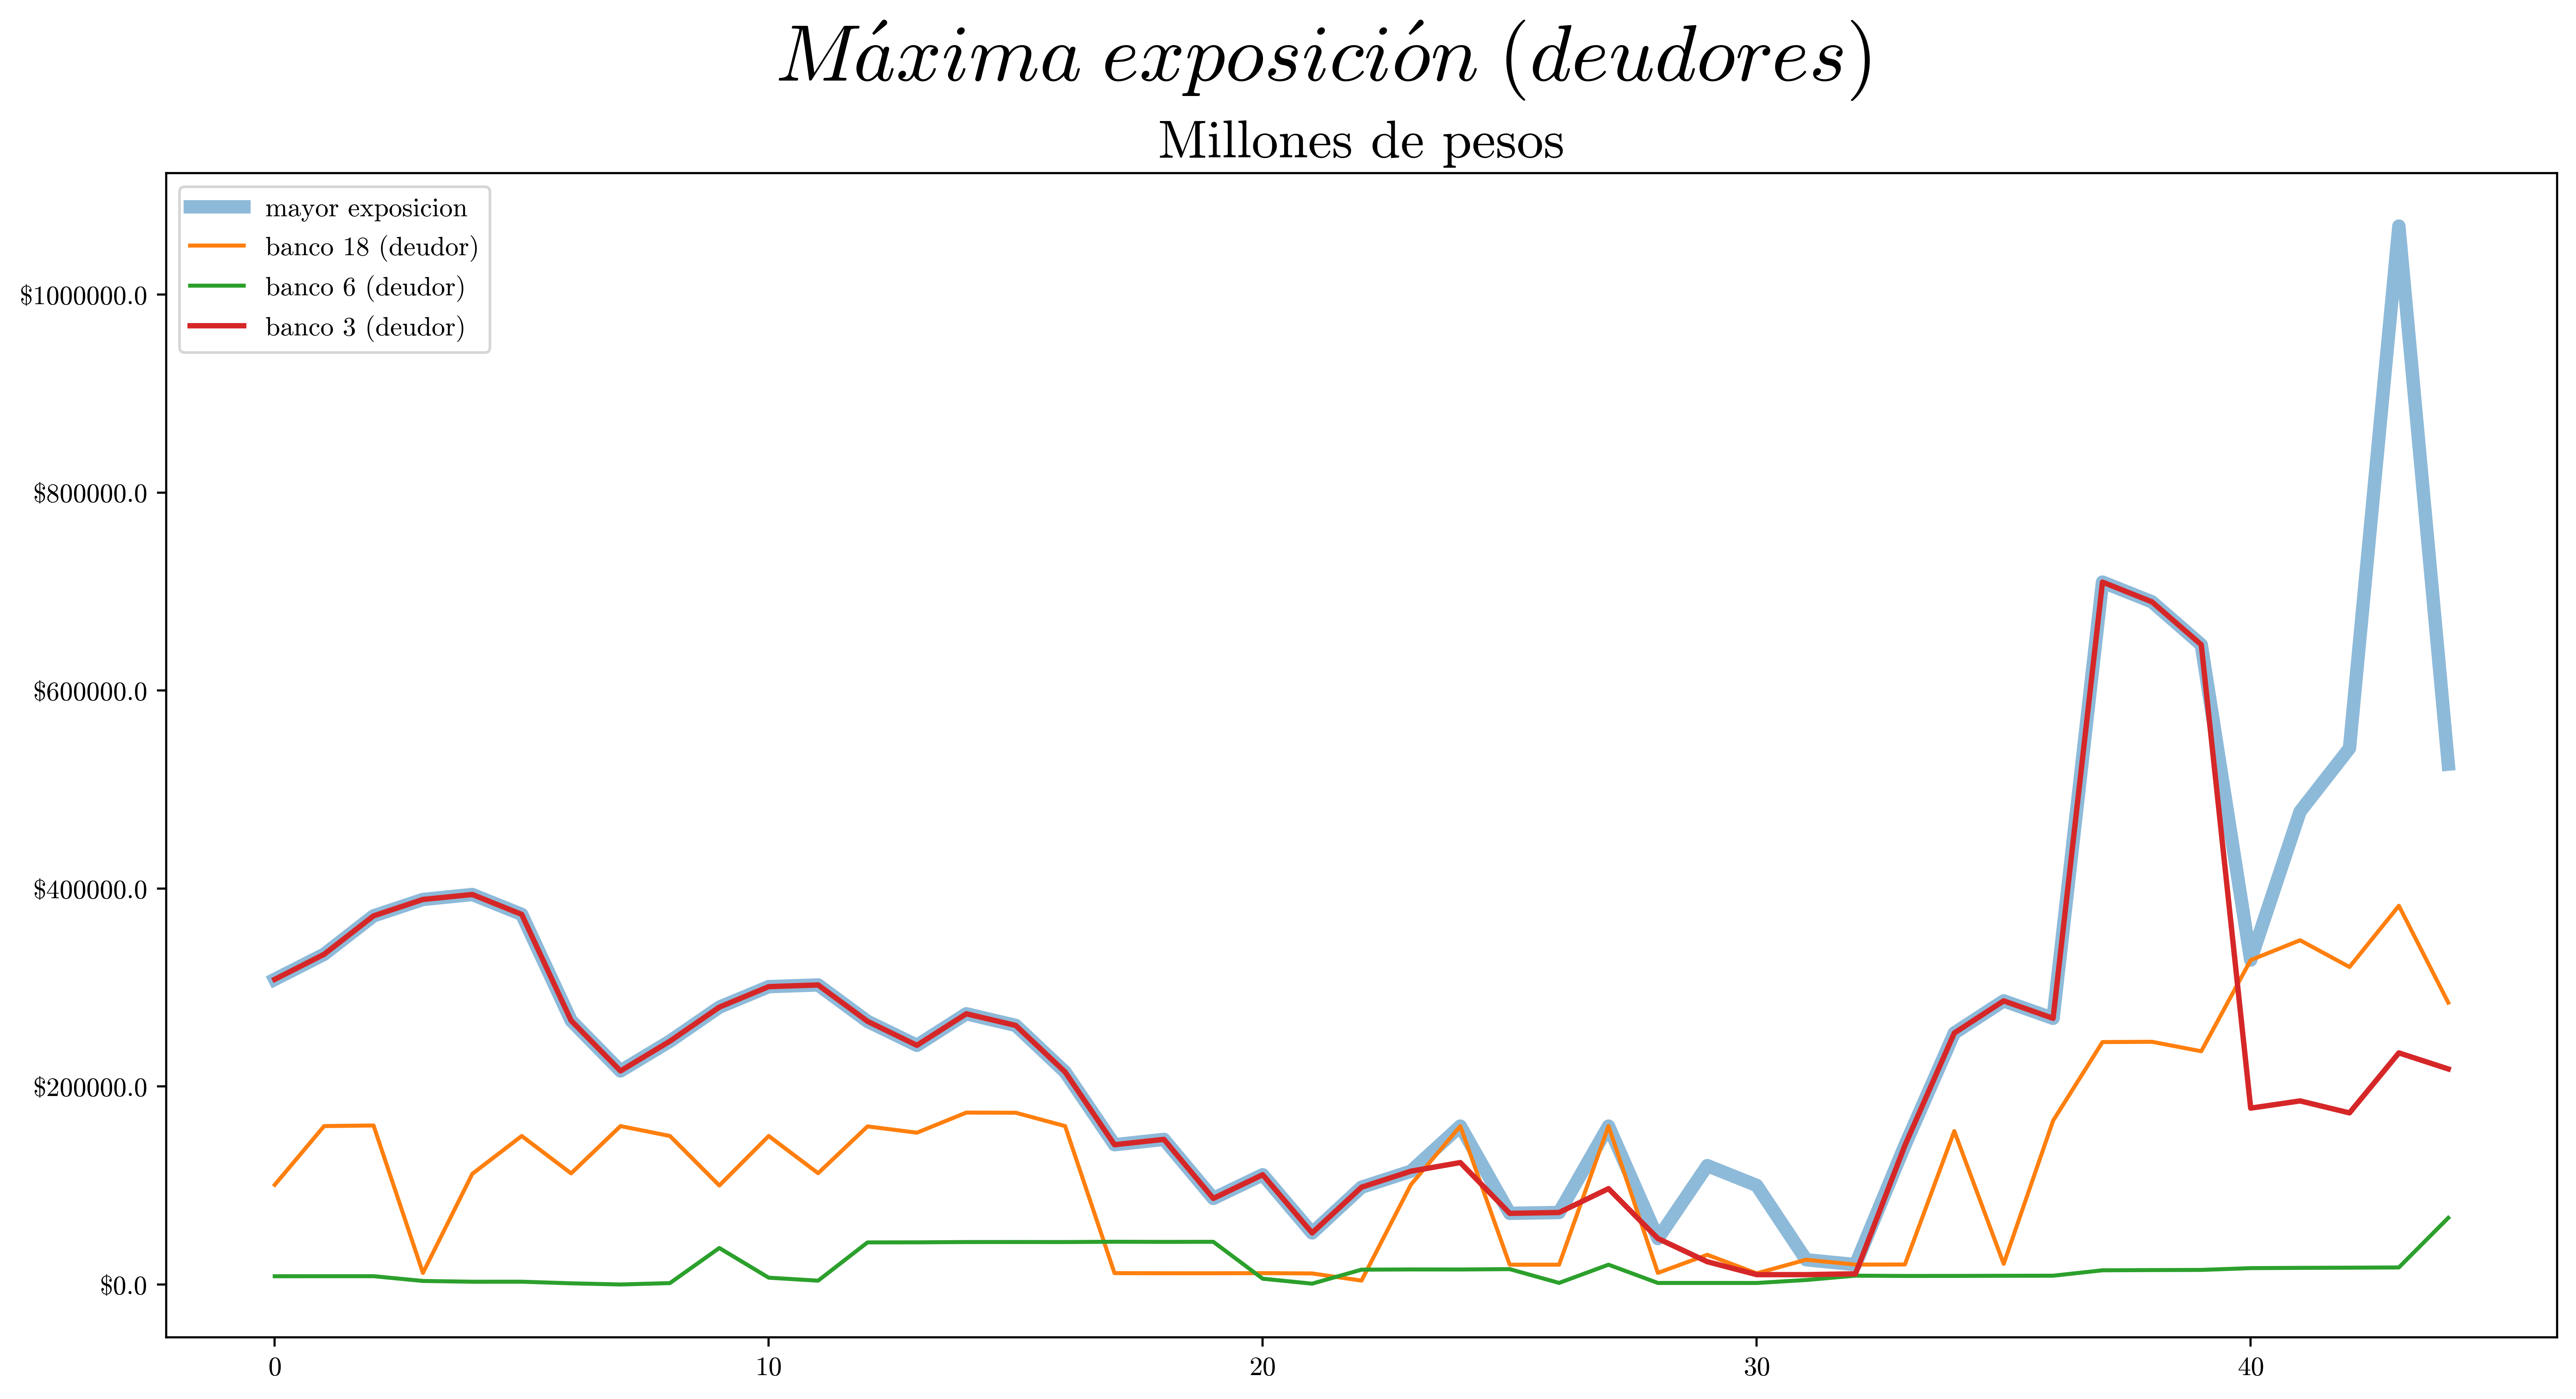

In [ ]:
overlapping = 0.5
plt.figure(figsize=(16, 8), dpi = 500)
plt.plot(lista_max_v, alpha = overlapping, linewidth = 5)
for i in [18, 6, 3]:
  if i == 3:
    plt.plot(d_max_v[f'banco_{i}'], linewidth = 2)
  else:
    plt.plot(d_max_v[f'banco_{i}'])

plt.suptitle(r'$M\acute{a}xima\;exposici\acute{o}n\;(deudores)$', size = 30)
plt.title('Millones de pesos', size = 20)

#formato eje
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('$%s'))

plt.legend(['mayor exposicion','banco 18 (deudor)', 'banco 6 (deudor)', 'banco 3 (deudor)'])

d_descargas_figuras = 'Y'

if d_descargas_figuras == 'Y':
  plt.savefig(f"deudores.pdf")
  files.download(f"deudores.pdf") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

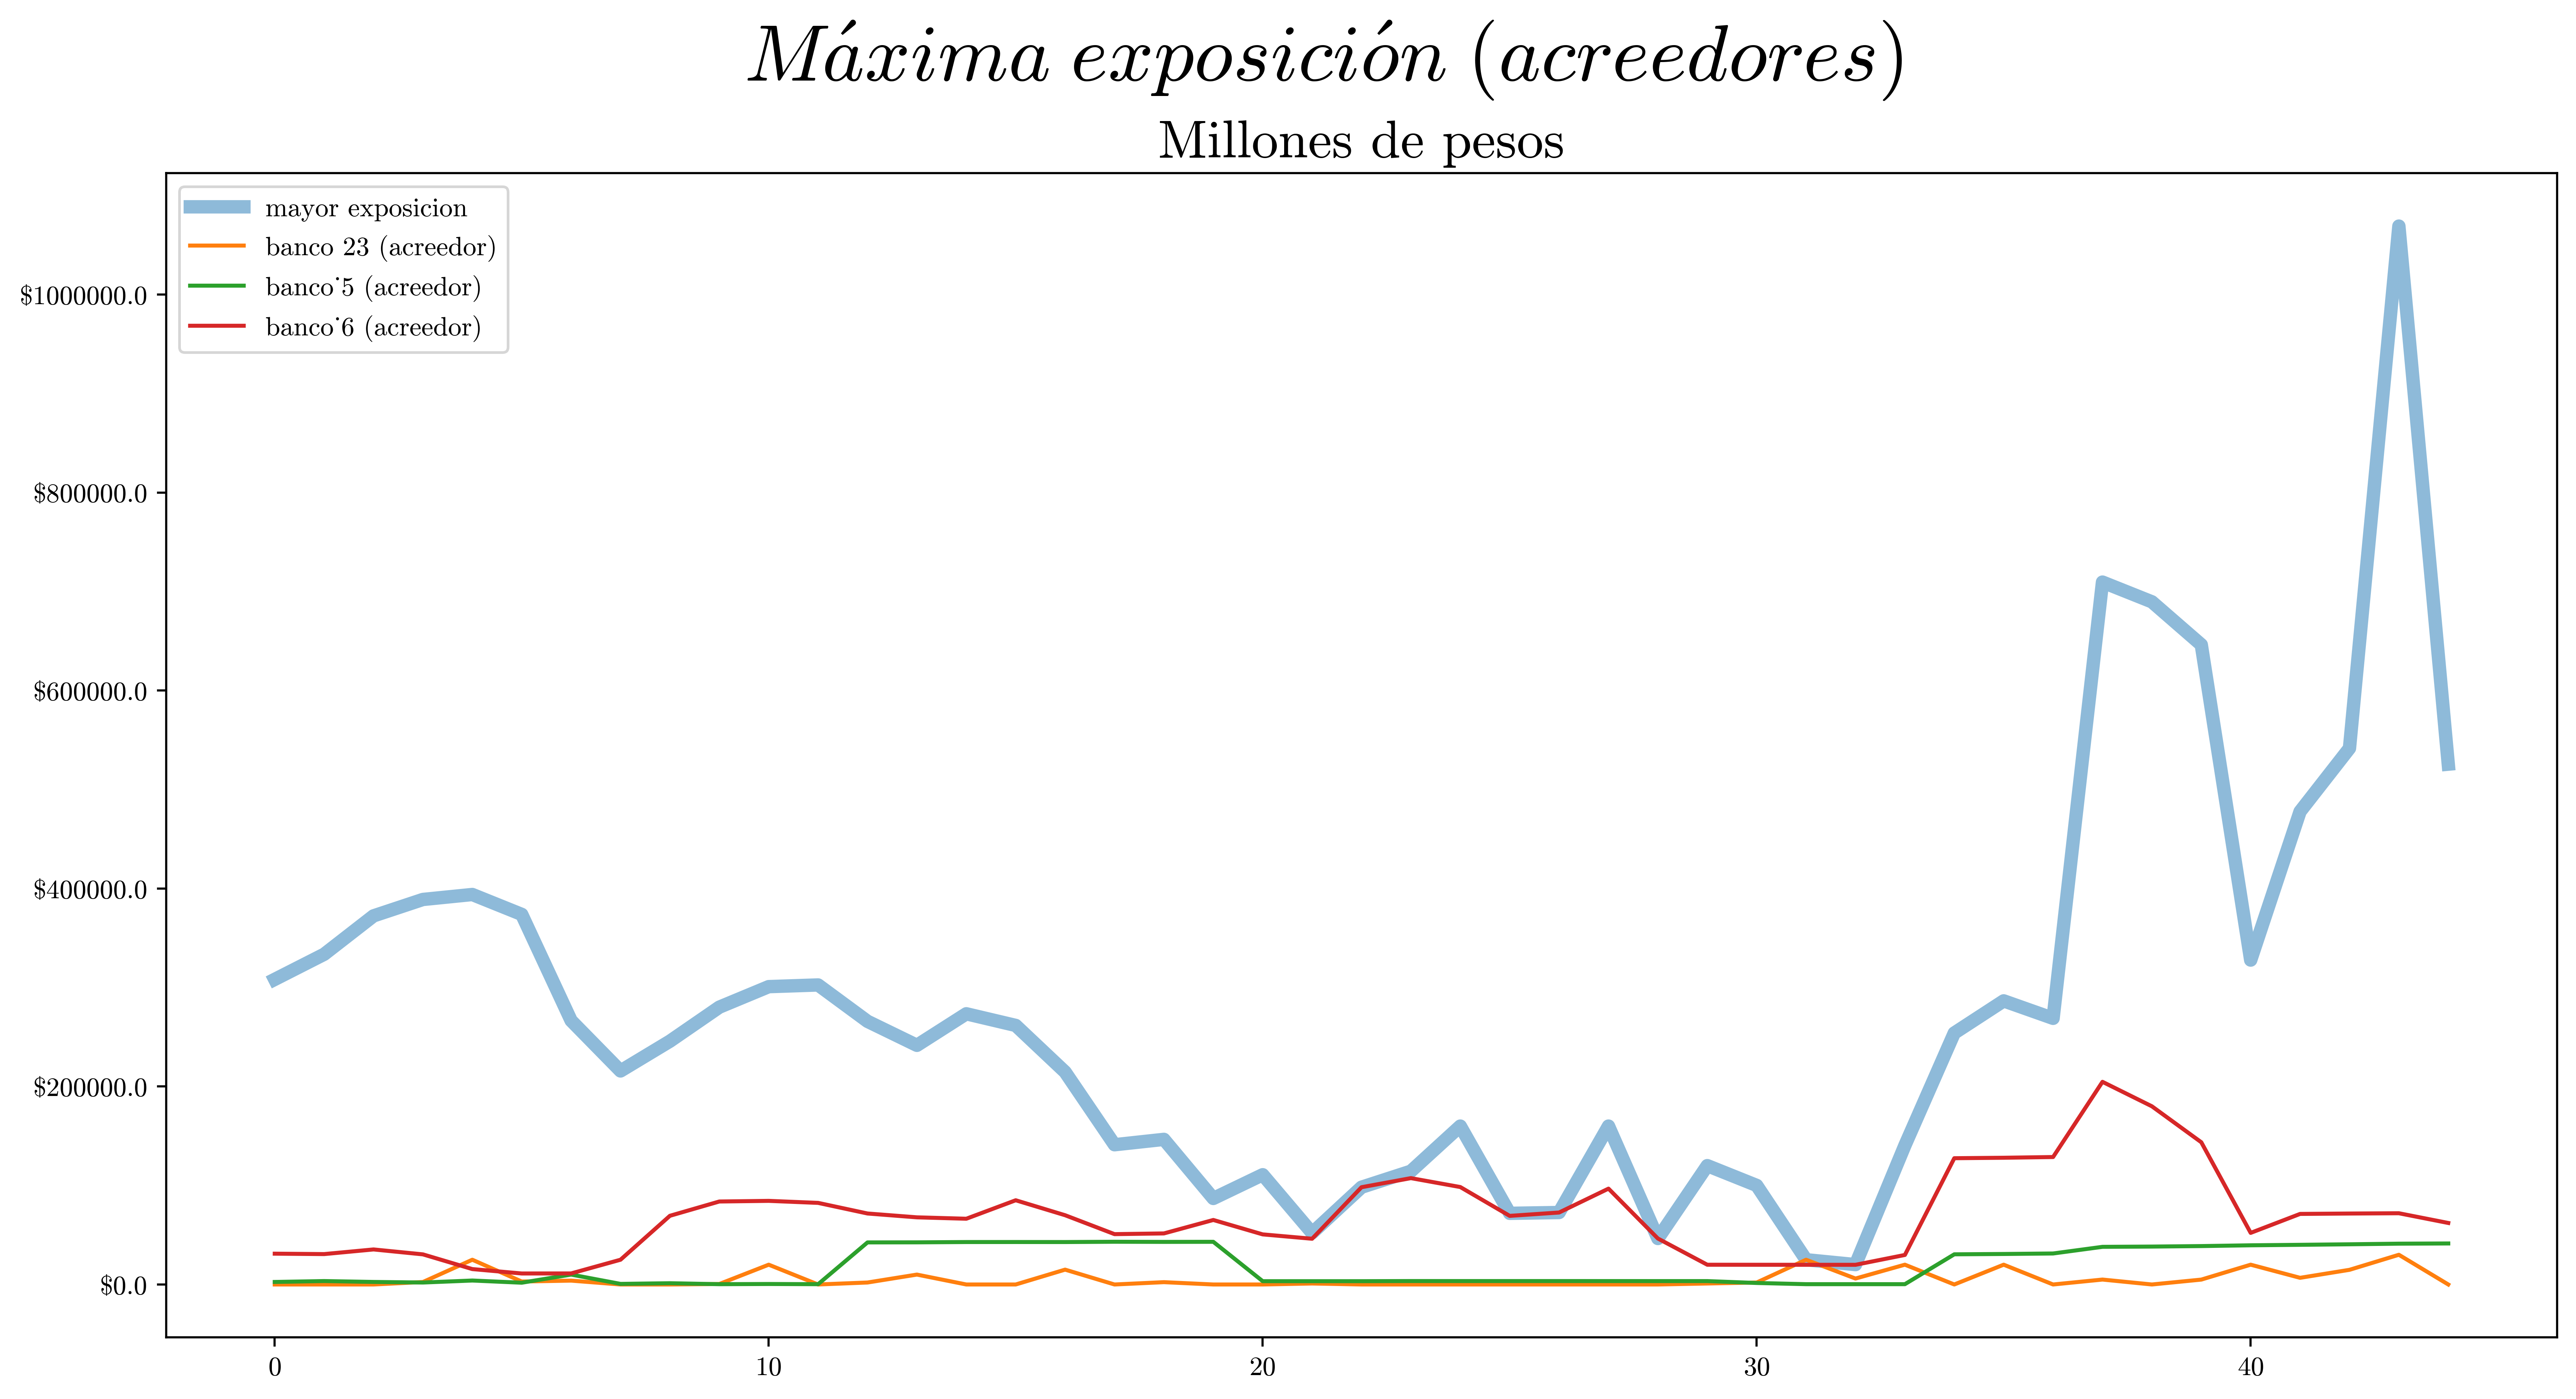

In [ ]:
overlapping = 0.5
plt.figure(figsize=(16, 8), dpi = 500)


plt.plot(lista_max_v, alpha = overlapping, linewidth = 5)

for i in [23, 5, 6]:
  plt.plot(d_max_c[f'banco_{i}'])

plt.suptitle(r'$M\acute{a}xima\;exposici\acute{o}n\;(acreedores)$', size = 30)
plt.title('Millones de pesos', size = 20)

#formato eje
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('$%s'))

plt.legend(['mayor exposicion','banco 23 (acreedor)', 'banco_5 (acreedor)', 'banco_6 (acreedor)'])

if d_descargas_figuras == 'Y':
  plt.savefig(f"acreedores.pdf")
  files.download(f"acreedores.pdf") 